<div>
<img src="https://geekflare.com/wp-content/uploads/2022/08/google-JAX.png" width="500" style="margin: 55px auto; display: block; position: relative; left: -30px;" />
</div>

<!--NAVIGATION-->
# [PyTorch Primer](1-pytorch.ipynb) | [TensorFlow Primer](2-tf.ipynb) | [PyTorch vs TensorFlow](3-pytorch_vs_tf.ipynb) | JAX Primer

## Submodule -1.4 : A Primer on PyTorch and Tensorflow

## Table of Contents

#### 1. [Installation](#Installing-JAX)
#### 2. [Visualizing graph based computation](#Cosntruct-the-Graph-(Tree)-of-following-expressions)
#### 3. [Basics of PyTorch](#Basics-of-PyTorch)
#### 4. [Automatic Differentiation](#Automatic-Differentiation)
#### 5. [Function Approximations](#Function-Approximations)


# Installing JAX

### Install JAX

In [2]:
!pip install "jax[cuda11_cudnn82]" -f \
https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

###### Why JAX ?

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

In [2]:
# Define a function for computing the Matrix Powers and summing it
def fn(x):
    return x + x*x + x*x*x + x*x*x*x

In [10]:
## NumPy Evaluation
x = np.random.randn(10000, 10000).astype(dtype='float32')
%timeit -n5 -r5 fn(x)

614 ms ± 17.9 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [11]:
## JAX NumPy Evaluation
x = np.random.randn(10000, 10000).astype(dtype='float32')
jax_fn = jit(fn)
x = jnp.array(x)
%timeit -n5 -r5 jax_fn(x).block_until_ready()

91.5 ms ± 5.31 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [6]:
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

### Scaler Valued function
### define f(x) = abs(x**3)
def abs_cube(x):
    r = 1   
    if x < 0.:
        for i in range(3):
            r *= x
        r = -r
    else:
        for i in range(3):
            r *= x
    return r

grad_fn = grad(abs_cube)

print(f"x = 8.0   f(x) = {abs_cube(8)}   f'(x) =  3x^2 = {grad_fn(8.0)}")
print(f"x = -6.0  f(x) = {abs_cube(-6)}  f'(x) = -3x^2 = {grad_fn(-6.0)}")

x = 8.0   f(x) = 512   f'(x) =  3x^2 = 192.0
x = -6.0  f(x) = 216  f'(x) = -3x^2 = -108.0


In [14]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap, jacfwd, jacrev
import numpy as np
## Vector valued function
def vec_fn(v):
    x = v[0]
    y = v[1]
    z = v[2]
    return jnp.array([x**3, y*z])

#[d/dx x**3 , d/dy x**3, d/dz x**3]
#[d/dx y*z , d/dy y*z, d/dz y*z]
# [3*x**2 , 0, 0]
# [0 , z, y]

f = jax.jacfwd(vec_fn)
v = jnp.array([4., 5., 9.])
print(f(v))

[[48.  0.  0.]
 [ 0.  9.  5.]]


In [88]:
from jax import grad, jit, vmap, pmap, jacfwd, jacrev

def jax_hess(x):
    return jnp.sum(jnp.square(x))

jit_jax_fn = jit(jacrev(jacrev(jax_hess)))

x_np = np.random.rand(1000,1)
x = jnp.array(x_np)
%timeit jit_jax_fn(x).block_until_ready()

68.8 µs ± 527 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
import torch
def torch_hess(x):
    return torch.sum(torch.mul(x,x))
  
x = torch.randn((1000,))
%timeit -n 10 -r 5 torch.autograd.functional.hessian(torch_hess, x, vectorize=False)
%timeit -n 100 -r 10 torch.autograd.functional.hessian(torch_hess, x, vectorize=True)

50.2 ms ± 848 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
909 µs ± 66.9 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [83]:
import tensorflow as tf
import os

def tf_hess(x):
    return tf.math.reduce_sum(x**2)

x = tf.random.uniform(shape=(1000,1))

@tf.function(jit_compile=True)
def hess(y_tf, x_tf):
    y_tf = tf_hess(x_tf)
    return tf.hessians(y_tf, x_tf, gate_gradients=False, aggregation_method=None,\
                       name='hessians')

%timeit  hess(y_tf, x_tf)
x = hess(y_tf, x_tf)

435 µs ± 6.05 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## JVP in JAX

In [40]:
#### JVP Compute

import jax
import jax.numpy as jnp

def f(x):
    u = jnp.array([x[0]**2*x[1]**2*x[2]**2*x[3]**3,
                  x[0]**4*x[1]**2*x[2]**5*x[3]**2,
                  x[0]**3*x[1]**2*x[2]**2*x[3]**2]
                 )
    return u
    
eval_points = jnp.array([1.0, 1.5, 0.2, 0.7])

f(eval_points)

jacobian_full = jax.jacfwd(f)(eval_points)
print(f"{jacobian_full=}")

v = jnp.array([0.2,0.3, 0.4, 0.8])

full_jvp = jacobian_full @ v

print(f"{full_jvp=}")
val, jax_jvp = jax.jvp(f, (eval_points, ), (v, )) 
print(f"{jax_jvp=} and {val=}")    


#### unitary matricies
e_1 = jnp.array([1.0, 0.0, 0.0, 0.0])
ve, jvp_e = jax.jvp(f, (eval_points, ), (e_1, ))
print(f"{ve=}, {jvp_e=}")

jacobian_full=DeviceArray([[0.06174   , 0.04116   , 0.3087    , 0.1323    ],
             [0.0014112 , 0.0004704 , 0.00882   , 0.001008  ],
             [0.1323    , 0.0588    , 0.44099998, 0.126     ]],            dtype=float32)
full_jvp=DeviceArray([0.254016  , 0.00475776, 0.3213    ], dtype=float32)
jax_jvp=DeviceArray([0.254016  , 0.00475776, 0.3213    ], dtype=float32) and val=DeviceArray([0.03087  , 0.0003528, 0.0441   ], dtype=float32)
ve=DeviceArray([0.03087  , 0.0003528, 0.0441   ], dtype=float32), jvp_e=DeviceArray([0.06174  , 0.0014112, 0.1323   ], dtype=float32)


In [37]:
#### JACOBIAN From JVP
def jacobian_jvp(f, eval_points):
    unit_vector = jnp.array([1.0, 0.0, 0.0, 0.0])
    n_col = len(eval_points)
    jac = []
    val = []
    for i in range(n_col):
        primal, ddx = jax.jvp(f, (eval_points, ), (jnp.roll(unit_vector, i), ))
        jac.append(ddx)
        val.append(primal)
        jac_f = jnp.stack(jac, axis=1)
        val_f = jnp.stack(val, axis=1)
        
    return val_f, jac_f
        
        
v, J = jacobian_jvp(f, eval_points)  
print(f"{v = }")
print(f"{J=}")

v = DeviceArray([[0.03087  , 0.03087  , 0.03087  , 0.03087  ],
             [0.0003528, 0.0003528, 0.0003528, 0.0003528],
             [0.0441   , 0.0441   , 0.0441   , 0.0441   ]], dtype=float32)
J=DeviceArray([[0.06174   , 0.04116   , 0.3087    , 0.1323    ],
             [0.0014112 , 0.0004704 , 0.00882   , 0.001008  ],
             [0.1323    , 0.0588    , 0.44099998, 0.126     ]],            dtype=float32)


eval_points shape= (100,)
eval_points shape= (100,)
14.3 µs ± 167 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.96 µs ± 57.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


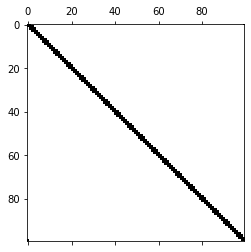

In [73]:
### benchmarking-
import matplotlib.pyplot as plt

def f(x):
    u = x**2 - jnp.roll(x, -1)**3 - jnp.roll(x, 1)**3
    return u

eval_points = jax.random.normal(jax.random.PRNGKey(100), (100,))
tangents = jax.random.normal(jax.random.PRNGKey(20), (100,))

print(f"eval_points shape= {eval_points.shape}")
print(f"eval_points shape= {f(eval_points).shape}")

full_jac = jax.jacfwd(f)(eval_points)
plt.spy(full_jac)

@jax.jit
def slow_jvp(eval_points, tangents):
    jvp_s = jax.jacfwd(f)(eval_points)
    #jvp_slow = jvp_s @ tangents 
    return jvp_s

@jax.jit
def fast_jvp(eval_points, tangents):
    jvp_fast = jax.jvp(f, (eval_points,), (tangents,))
    return jvp_fast

%timeit slow_jvp(eval_points, tangents)
%timeit  fast_jvp(eval_points, tangents)




## VJP in JAX

In [91]:
import jax
import jax.numpy as jnp

def f(x):
    u = jnp.array([x[0]**2*x[1]**2*x[2]**2*x[3]**3,
                  x[0]**4*x[1]**2*x[2]**5*x[3]**2,
                  x[0]**3*x[1]**2*x[2]**2*x[3]**2]
                 )
    return u
    
eval_points = jnp.array([1.0, 1.5, 0.2, 0.7])

print(f"f_eval_original={f(eval_points)}")

full_jac = jax.jacrev(f)(eval_points)
print(f"{full_jac=}")

left_mult_points = jnp.array([0.6, 0.8, 1.2])

vjp = left_mult_points.T @ full_jac
print(f"Full VJP: {vjp}")

### Compute VJP with out computing the full jacobian

f_evaluated, vjp_fn = jax.vjp(f, eval_points)

print(f"{f_evaluated=}")

vjp_prod = vjp_fn(left_mult_points.T)
print(vjp_prod)

f_eval_original=[0.03087   0.0003528 0.0441   ]
full_jac=DeviceArray([[0.06174   , 0.04116   , 0.3087    , 0.1323    ],
             [0.0014112 , 0.0004704 , 0.00882   , 0.001008  ],
             [0.1323    , 0.0588    , 0.44099998, 0.126     ]],            dtype=float32)
Full VJP: [0.19693297 0.09563232 0.721476   0.23138641]
f_evaluated=DeviceArray([0.03087  , 0.0003528, 0.0441   ], dtype=float32)
(DeviceArray([0.19693297, 0.09563233, 0.721476  , 0.23138642], dtype=float32),)


In [7]:
import jax.numpy as jnp
from jax import vmap
a = jnp.array([[1, 10], [43, 8]])
b = jnp.array([[7, 8], [9, 10]])

a1 = jnp.add(a, b)

a1

DeviceArray([[ 8, 18],
             [52, 18]], dtype=int32)

In [6]:
b1 = vmap(jnp.add, in_axes=(0, 0),out_axes=0)(a, b)
b1

DeviceArray([[ 8, 18],
             [52, 18]], dtype=int32)

In [4]:
import jax.numpy as jnp
from jax import make_jaxpr
def f(a, b):
    temp = a + 10.0 * jnp.sin(b)
    return jnp.sum(temp)

a = jnp.ones(10)
b = jnp.ones(10)

print(make_jaxpr(f)(a, b))

{ lambda ; a:f32[10] b:f32[10]. let
    c:f32[10] = sin b
    d:f32[10] = mul c 10.0
    e:f32[10] = add a d
    f:f32[] = reduce_sum[axes=(0,)] e
  in (f,) }


In [10]:
def fn_tanh(x):
    return (jnp.exp(-x) - jnp.exp(x))/(jnp.exp(-x) + jnp.exp(x))

x = jnp.arange(1000000)
%timeit fn_tanh(x).block_until_ready()

2.74 ms ± 78 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
from jax import jit
fn_tanh_jit = jit(fn_tanh)
%timeit fn_tanh_jit(x).block_until_ready()

592 µs ± 7.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
def f(x):
    if x > 0:
        return x
    else:
        return 4 * x
    
f_jit = jit(f)(15)


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function f at <ipython-input-11-97fc253e103f>:1 for jit, this concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [16]:
def f(x):
    if x > 0:
        return x
    else:
        return 4 * x
    
f_jit = jit(f)(15)


ValueError: Non-hashable static arguments are not supported. An error occured during a call to 'f' while trying to hash an object of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'>, Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>. The error was:
TypeError: unhashable type: 'DynamicJaxprTracer'


In [24]:
import numpy as np
#In-place Update
np_arr = np.zeros((3,3), dtype=np.float32)
print("original array:")
print(np_arr)

# In place, mutating update
np_arr[1, :] = 1.0
print("updated array:")
print(np_arr)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [25]:
jax_arr = jnp.zeros((3,3), dtype=jnp.float32)

# In place update of JAX's array will yield an error!
try:
  jax_array[1, :] = 1.0
except Exception as e:
  print("Exception {}".format(e))

Exception '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


In [27]:
updated_array = jax_array.at[1, :].set(1.0)
print("updated array:\n", updated_array)

updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [34]:
#Pytree
from jax.tree_util import tree_structure
tree_1 = [1, "a", object()]  # 3 leaves
tree_2 = (1, (2, 3), ())  # 3 leaves
tree_3 =[1, {"k1": 2, "k2": (3, 4)}, 5]  # 5 leaves

tree_struct_1=tree_structure(tree_1)
tree_struct_2=tree_structure(tree_2)
tree_struct_3=tree_structure(tree_3)


print(f"{tree_struct_1=}\n{tree_struct_2=}\n{tree_struct_2=}")


tree_struct_1=PyTreeDef([*, *, *])
tree_struct_2=PyTreeDef((*, (*, *), ()))
tree_struct_2=PyTreeDef((*, (*, *), ()))


In [44]:
from jax.tree_util import tree_flatten, tree_unflatten
import jax.numpy as jnp
v_structured = [1., (8., 10.)]
v_flat, v_tree = tree_flatten(v_structured)
print(f"{v_flat=}\n{v_tree=}")

#Using the map function
transformed_flat = list(map(lambda v: v ** 2., v_flat))
print(f"{transformed_flat=}")
# Reconstruct the structured output, using the PyTree
transformed_structured = tree_unflatten(v_tree, transformed_flat)
print(f"{transformed_structured=}\n")

v_flat=[1.0, 8.0, 10.0]
v_tree=PyTreeDef([*, (*, *)])
transformed_flat=[1.0, 64.0, 100.0]
transformed_structured=[1.0, (64.0, 100.0)]



In [108]:
from jax import random
from jax.nn import tanh
from jax import numpy as jnp
from jax import vmap, value_and_grad, jit

def get_random_layer_params(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights = 1/(jnp.sqrt(m+n)) * random.normal(w_key, (n, m))
    biases = jnp.zeros((n,)) 
    return weights, biases

def get_init_network_params(sizes, ran_key):
    keys = random.split(ran_key, len(sizes))
    return [get_random_layer_params(m, n, k) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def feedforward_prediction(params, x):     
    for w, b in params[:-1]:
        outputs = jnp.dot(w, x) + b  
        x = tanh(outputs)  
    w_final, b_final = params[-1] 
    final_outputs = jnp.dot(w_final, x) + b_final 
    return final_outputs  


batched_prediction = vmap(feedforward_prediction, in_axes=(None, 0))

@jit
def mse_loss(params, x, y):
    preds = batched_prediction(params, x)
    diff = preds - y
    return jnp.sum(diff*diff)/preds.shape[0]

@jit
def update(params, x, y, learning_rate):
    l, grads = value_and_grad(mse_loss)(params, x, y)
    return [(w - learning_rate * dw, b - learning_rate * db) 
            for (w, b), (dw, db) in zip(params, grads)], l



def f(x):
    return x**2

SEED = 1234
key = random.PRNGKey(SEED)
Niter = 100000
lr = 1e-02

num_features = 1
num_traget = 1
num_batches = 1000
layers = [1] + [32]*2 + [1]
params = get_init_network_params(layers, ran_key)
ran_key, func_key = random.split(key)

x_train = jnp.linspace(-1, 1, num_batches)
x_train = x_train.reshape((num_batches, num_features))
y_train = f(x_train)

for it in range(0, Niter):
    params, loss = update(params, x_train, y_train, lr)
    print(f"{it=} and {loss=}\n")
    
    



    





it=0 and loss=DeviceArray(0.29730567, dtype=float32)

it=1 and loss=DeviceArray(0.27545333, dtype=float32)

it=2 and loss=DeviceArray(0.25648537, dtype=float32)

it=3 and loss=DeviceArray(0.2400147, dtype=float32)

it=4 and loss=DeviceArray(0.22570859, dtype=float32)

it=5 and loss=DeviceArray(0.21328028, dtype=float32)

it=6 and loss=DeviceArray(0.20248201, dtype=float32)

it=7 and loss=DeviceArray(0.19309942, dtype=float32)

it=8 and loss=DeviceArray(0.18494676, dtype=float32)

it=9 and loss=DeviceArray(0.17786281, dtype=float32)

it=10 and loss=DeviceArray(0.17170766, dtype=float32)

it=11 and loss=DeviceArray(0.16635974, dtype=float32)

it=12 and loss=DeviceArray(0.16171335, dtype=float32)

it=13 and loss=DeviceArray(0.1576766, dtype=float32)

it=14 and loss=DeviceArray(0.15416966, dtype=float32)

it=15 and loss=DeviceArray(0.15112296, dtype=float32)

it=16 and loss=DeviceArray(0.14847608, dtype=float32)

it=17 and loss=DeviceArray(0.14617653, dtype=float32)

it=18 and loss=DeviceA

it=829 and loss=DeviceArray(0.12895635, dtype=float32)

it=830 and loss=DeviceArray(0.12895457, dtype=float32)

it=831 and loss=DeviceArray(0.12895279, dtype=float32)

it=832 and loss=DeviceArray(0.12895101, dtype=float32)

it=833 and loss=DeviceArray(0.12894924, dtype=float32)

it=834 and loss=DeviceArray(0.12894747, dtype=float32)

it=835 and loss=DeviceArray(0.1289457, dtype=float32)

it=836 and loss=DeviceArray(0.12894392, dtype=float32)

it=837 and loss=DeviceArray(0.12894213, dtype=float32)

it=838 and loss=DeviceArray(0.12894037, dtype=float32)

it=839 and loss=DeviceArray(0.1289386, dtype=float32)

it=840 and loss=DeviceArray(0.12893681, dtype=float32)

it=841 and loss=DeviceArray(0.12893502, dtype=float32)

it=842 and loss=DeviceArray(0.12893327, dtype=float32)

it=843 and loss=DeviceArray(0.12893148, dtype=float32)

it=844 and loss=DeviceArray(0.12892972, dtype=float32)

it=845 and loss=DeviceArray(0.12892793, dtype=float32)

it=846 and loss=DeviceArray(0.12892616, dtype=floa

it=1412 and loss=DeviceArray(0.12778929, dtype=float32)

it=1413 and loss=DeviceArray(0.1277869, dtype=float32)

it=1414 and loss=DeviceArray(0.12778452, dtype=float32)

it=1415 and loss=DeviceArray(0.12778215, dtype=float32)

it=1416 and loss=DeviceArray(0.12777975, dtype=float32)

it=1417 and loss=DeviceArray(0.12777738, dtype=float32)

it=1418 and loss=DeviceArray(0.12777498, dtype=float32)

it=1419 and loss=DeviceArray(0.1277726, dtype=float32)

it=1420 and loss=DeviceArray(0.12777019, dtype=float32)

it=1421 and loss=DeviceArray(0.12776782, dtype=float32)

it=1422 and loss=DeviceArray(0.12776542, dtype=float32)

it=1423 and loss=DeviceArray(0.12776302, dtype=float32)

it=1424 and loss=DeviceArray(0.12776063, dtype=float32)

it=1425 and loss=DeviceArray(0.12775822, dtype=float32)

it=1426 and loss=DeviceArray(0.1277558, dtype=float32)

it=1427 and loss=DeviceArray(0.1277534, dtype=float32)

it=1428 and loss=DeviceArray(0.127751, dtype=float32)

it=1429 and loss=DeviceArray(0.127748

it=2119 and loss=DeviceArray(0.12534119, dtype=float32)

it=2120 and loss=DeviceArray(0.12533605, dtype=float32)

it=2121 and loss=DeviceArray(0.12533091, dtype=float32)

it=2122 and loss=DeviceArray(0.12532575, dtype=float32)

it=2123 and loss=DeviceArray(0.1253206, dtype=float32)

it=2124 and loss=DeviceArray(0.12531543, dtype=float32)

it=2125 and loss=DeviceArray(0.12531026, dtype=float32)

it=2126 and loss=DeviceArray(0.12530509, dtype=float32)

it=2127 and loss=DeviceArray(0.12529987, dtype=float32)

it=2128 and loss=DeviceArray(0.12529469, dtype=float32)

it=2129 and loss=DeviceArray(0.1252895, dtype=float32)

it=2130 and loss=DeviceArray(0.1252843, dtype=float32)

it=2131 and loss=DeviceArray(0.12527907, dtype=float32)

it=2132 and loss=DeviceArray(0.12527384, dtype=float32)

it=2133 and loss=DeviceArray(0.12526862, dtype=float32)

it=2134 and loss=DeviceArray(0.12526338, dtype=float32)

it=2135 and loss=DeviceArray(0.12525813, dtype=float32)

it=2136 and loss=DeviceArray(0.125

it=2688 and loss=DeviceArray(0.12068848, dtype=float32)

it=2689 and loss=DeviceArray(0.12067579, dtype=float32)

it=2690 and loss=DeviceArray(0.12066308, dtype=float32)

it=2691 and loss=DeviceArray(0.12065035, dtype=float32)

it=2692 and loss=DeviceArray(0.12063759, dtype=float32)

it=2693 and loss=DeviceArray(0.12062478, dtype=float32)

it=2694 and loss=DeviceArray(0.12061198, dtype=float32)

it=2695 and loss=DeviceArray(0.12059914, dtype=float32)

it=2696 and loss=DeviceArray(0.1205863, dtype=float32)

it=2697 and loss=DeviceArray(0.12057342, dtype=float32)

it=2698 and loss=DeviceArray(0.12056053, dtype=float32)

it=2699 and loss=DeviceArray(0.12054761, dtype=float32)

it=2700 and loss=DeviceArray(0.12053464, dtype=float32)

it=2701 and loss=DeviceArray(0.12052166, dtype=float32)

it=2702 and loss=DeviceArray(0.12050869, dtype=float32)

it=2703 and loss=DeviceArray(0.12049564, dtype=float32)

it=2704 and loss=DeviceArray(0.12048259, dtype=float32)

it=2705 and loss=DeviceArray(0.1

it=3357 and loss=DeviceArray(0.10307004, dtype=float32)

it=3358 and loss=DeviceArray(0.10302129, dtype=float32)

it=3359 and loss=DeviceArray(0.10297244, dtype=float32)

it=3360 and loss=DeviceArray(0.10292351, dtype=float32)

it=3361 and loss=DeviceArray(0.10287445, dtype=float32)

it=3362 and loss=DeviceArray(0.10282528, dtype=float32)

it=3363 and loss=DeviceArray(0.10277603, dtype=float32)

it=3364 and loss=DeviceArray(0.10272665, dtype=float32)

it=3365 and loss=DeviceArray(0.10267719, dtype=float32)

it=3366 and loss=DeviceArray(0.10262763, dtype=float32)

it=3367 and loss=DeviceArray(0.10257795, dtype=float32)

it=3368 and loss=DeviceArray(0.10252817, dtype=float32)

it=3369 and loss=DeviceArray(0.10247829, dtype=float32)

it=3370 and loss=DeviceArray(0.10242829, dtype=float32)

it=3371 and loss=DeviceArray(0.10237821, dtype=float32)

it=3372 and loss=DeviceArray(0.10232802, dtype=float32)

it=3373 and loss=DeviceArray(0.10227771, dtype=float32)

it=3374 and loss=DeviceArray(0.

it=3850 and loss=DeviceArray(0.06383402, dtype=float32)

it=3851 and loss=DeviceArray(0.06372324, dtype=float32)

it=3852 and loss=DeviceArray(0.06361236, dtype=float32)

it=3853 and loss=DeviceArray(0.06350141, dtype=float32)

it=3854 and loss=DeviceArray(0.06339037, dtype=float32)

it=3855 and loss=DeviceArray(0.06327923, dtype=float32)

it=3856 and loss=DeviceArray(0.06316801, dtype=float32)

it=3857 and loss=DeviceArray(0.06305669, dtype=float32)

it=3858 and loss=DeviceArray(0.06294533, dtype=float32)

it=3859 and loss=DeviceArray(0.06283385, dtype=float32)

it=3860 and loss=DeviceArray(0.06272229, dtype=float32)

it=3861 and loss=DeviceArray(0.06261067, dtype=float32)

it=3862 and loss=DeviceArray(0.06249893, dtype=float32)

it=3863 and loss=DeviceArray(0.06238715, dtype=float32)

it=3864 and loss=DeviceArray(0.06227529, dtype=float32)

it=3865 and loss=DeviceArray(0.06216333, dtype=float32)

it=3866 and loss=DeviceArray(0.0620513, dtype=float32)

it=3867 and loss=DeviceArray(0.0

it=4618 and loss=DeviceArray(0.00488821, dtype=float32)

it=4619 and loss=DeviceArray(0.00487221, dtype=float32)

it=4620 and loss=DeviceArray(0.0048563, dtype=float32)

it=4621 and loss=DeviceArray(0.0048405, dtype=float32)

it=4622 and loss=DeviceArray(0.00482476, dtype=float32)

it=4623 and loss=DeviceArray(0.00480914, dtype=float32)

it=4624 and loss=DeviceArray(0.00479359, dtype=float32)

it=4625 and loss=DeviceArray(0.00477813, dtype=float32)

it=4626 and loss=DeviceArray(0.00476278, dtype=float32)

it=4627 and loss=DeviceArray(0.00474751, dtype=float32)

it=4628 and loss=DeviceArray(0.00473232, dtype=float32)

it=4629 and loss=DeviceArray(0.00471722, dtype=float32)

it=4630 and loss=DeviceArray(0.00470222, dtype=float32)

it=4631 and loss=DeviceArray(0.00468729, dtype=float32)

it=4632 and loss=DeviceArray(0.00467246, dtype=float32)

it=4633 and loss=DeviceArray(0.0046577, dtype=float32)

it=4634 and loss=DeviceArray(0.00464305, dtype=float32)

it=4635 and loss=DeviceArray(0.004

it=5237 and loss=DeviceArray(0.00229406, dtype=float32)

it=5238 and loss=DeviceArray(0.00229351, dtype=float32)

it=5239 and loss=DeviceArray(0.00229297, dtype=float32)

it=5240 and loss=DeviceArray(0.00229242, dtype=float32)

it=5241 and loss=DeviceArray(0.00229187, dtype=float32)

it=5242 and loss=DeviceArray(0.00229133, dtype=float32)

it=5243 and loss=DeviceArray(0.00229079, dtype=float32)

it=5244 and loss=DeviceArray(0.00229026, dtype=float32)

it=5245 and loss=DeviceArray(0.00228971, dtype=float32)

it=5246 and loss=DeviceArray(0.00228918, dtype=float32)

it=5247 and loss=DeviceArray(0.00228865, dtype=float32)

it=5248 and loss=DeviceArray(0.00228811, dtype=float32)

it=5249 and loss=DeviceArray(0.00228758, dtype=float32)

it=5250 and loss=DeviceArray(0.00228705, dtype=float32)

it=5251 and loss=DeviceArray(0.00228652, dtype=float32)

it=5252 and loss=DeviceArray(0.00228599, dtype=float32)

it=5253 and loss=DeviceArray(0.00228547, dtype=float32)

it=5254 and loss=DeviceArray(0.

it=5970 and loss=DeviceArray(0.00203077, dtype=float32)

it=5971 and loss=DeviceArray(0.00203048, dtype=float32)

it=5972 and loss=DeviceArray(0.00203018, dtype=float32)

it=5973 and loss=DeviceArray(0.00202988, dtype=float32)

it=5974 and loss=DeviceArray(0.00202958, dtype=float32)

it=5975 and loss=DeviceArray(0.00202929, dtype=float32)

it=5976 and loss=DeviceArray(0.00202899, dtype=float32)

it=5977 and loss=DeviceArray(0.00202869, dtype=float32)

it=5978 and loss=DeviceArray(0.0020284, dtype=float32)

it=5979 and loss=DeviceArray(0.0020281, dtype=float32)

it=5980 and loss=DeviceArray(0.00202779, dtype=float32)

it=5981 and loss=DeviceArray(0.0020275, dtype=float32)

it=5982 and loss=DeviceArray(0.0020272, dtype=float32)

it=5983 and loss=DeviceArray(0.00202691, dtype=float32)

it=5984 and loss=DeviceArray(0.00202662, dtype=float32)

it=5985 and loss=DeviceArray(0.00202631, dtype=float32)

it=5986 and loss=DeviceArray(0.00202602, dtype=float32)

it=5987 and loss=DeviceArray(0.0020

it=6471 and loss=DeviceArray(0.00189021, dtype=float32)

it=6472 and loss=DeviceArray(0.00188995, dtype=float32)

it=6473 and loss=DeviceArray(0.00188968, dtype=float32)

it=6474 and loss=DeviceArray(0.00188942, dtype=float32)

it=6475 and loss=DeviceArray(0.00188915, dtype=float32)

it=6476 and loss=DeviceArray(0.00188889, dtype=float32)

it=6477 and loss=DeviceArray(0.00188863, dtype=float32)

it=6478 and loss=DeviceArray(0.00188836, dtype=float32)

it=6479 and loss=DeviceArray(0.0018881, dtype=float32)

it=6480 and loss=DeviceArray(0.00188783, dtype=float32)

it=6481 and loss=DeviceArray(0.00188757, dtype=float32)

it=6482 and loss=DeviceArray(0.00188731, dtype=float32)

it=6483 and loss=DeviceArray(0.00188705, dtype=float32)

it=6484 and loss=DeviceArray(0.00188678, dtype=float32)

it=6485 and loss=DeviceArray(0.00188652, dtype=float32)

it=6486 and loss=DeviceArray(0.00188626, dtype=float32)

it=6487 and loss=DeviceArray(0.00188599, dtype=float32)

it=6488 and loss=DeviceArray(0.0

it=7153 and loss=DeviceArray(0.00172347, dtype=float32)

it=7154 and loss=DeviceArray(0.00172324, dtype=float32)

it=7155 and loss=DeviceArray(0.00172301, dtype=float32)

it=7156 and loss=DeviceArray(0.00172279, dtype=float32)

it=7157 and loss=DeviceArray(0.00172256, dtype=float32)

it=7158 and loss=DeviceArray(0.00172234, dtype=float32)

it=7159 and loss=DeviceArray(0.00172211, dtype=float32)

it=7160 and loss=DeviceArray(0.00172189, dtype=float32)

it=7161 and loss=DeviceArray(0.00172167, dtype=float32)

it=7162 and loss=DeviceArray(0.00172144, dtype=float32)

it=7163 and loss=DeviceArray(0.00172121, dtype=float32)

it=7164 and loss=DeviceArray(0.00172098, dtype=float32)

it=7165 and loss=DeviceArray(0.00172076, dtype=float32)

it=7166 and loss=DeviceArray(0.00172053, dtype=float32)

it=7167 and loss=DeviceArray(0.00172031, dtype=float32)

it=7168 and loss=DeviceArray(0.00172009, dtype=float32)

it=7169 and loss=DeviceArray(0.00171986, dtype=float32)

it=7170 and loss=DeviceArray(0.


it=7729 and loss=DeviceArray(0.00160112, dtype=float32)

it=7730 and loss=DeviceArray(0.00160091, dtype=float32)

it=7731 and loss=DeviceArray(0.00160072, dtype=float32)

it=7732 and loss=DeviceArray(0.00160052, dtype=float32)

it=7733 and loss=DeviceArray(0.00160032, dtype=float32)

it=7734 and loss=DeviceArray(0.00160012, dtype=float32)

it=7735 and loss=DeviceArray(0.00159992, dtype=float32)

it=7736 and loss=DeviceArray(0.00159972, dtype=float32)

it=7737 and loss=DeviceArray(0.00159952, dtype=float32)

it=7738 and loss=DeviceArray(0.00159933, dtype=float32)

it=7739 and loss=DeviceArray(0.00159912, dtype=float32)

it=7740 and loss=DeviceArray(0.00159893, dtype=float32)

it=7741 and loss=DeviceArray(0.00159873, dtype=float32)

it=7742 and loss=DeviceArray(0.00159853, dtype=float32)

it=7743 and loss=DeviceArray(0.00159832, dtype=float32)

it=7744 and loss=DeviceArray(0.00159813, dtype=float32)

it=7745 and loss=DeviceArray(0.00159793, dtype=float32)

it=7746 and loss=DeviceArray(0

it=8349 and loss=DeviceArray(0.00148511, dtype=float32)

it=8350 and loss=DeviceArray(0.00148494, dtype=float32)

it=8351 and loss=DeviceArray(0.00148476, dtype=float32)

it=8352 and loss=DeviceArray(0.00148459, dtype=float32)

it=8353 and loss=DeviceArray(0.00148441, dtype=float32)

it=8354 and loss=DeviceArray(0.00148423, dtype=float32)

it=8355 and loss=DeviceArray(0.00148406, dtype=float32)

it=8356 and loss=DeviceArray(0.00148388, dtype=float32)

it=8357 and loss=DeviceArray(0.00148371, dtype=float32)

it=8358 and loss=DeviceArray(0.00148354, dtype=float32)

it=8359 and loss=DeviceArray(0.00148336, dtype=float32)

it=8360 and loss=DeviceArray(0.00148318, dtype=float32)

it=8361 and loss=DeviceArray(0.00148301, dtype=float32)

it=8362 and loss=DeviceArray(0.00148283, dtype=float32)

it=8363 and loss=DeviceArray(0.00148266, dtype=float32)

it=8364 and loss=DeviceArray(0.00148248, dtype=float32)

it=8365 and loss=DeviceArray(0.00148231, dtype=float32)

it=8366 and loss=DeviceArray(0.


it=8886 and loss=DeviceArray(0.00139578, dtype=float32)

it=8887 and loss=DeviceArray(0.00139562, dtype=float32)

it=8888 and loss=DeviceArray(0.00139546, dtype=float32)

it=8889 and loss=DeviceArray(0.0013953, dtype=float32)

it=8890 and loss=DeviceArray(0.00139514, dtype=float32)

it=8891 and loss=DeviceArray(0.00139499, dtype=float32)

it=8892 and loss=DeviceArray(0.00139483, dtype=float32)

it=8893 and loss=DeviceArray(0.00139467, dtype=float32)

it=8894 and loss=DeviceArray(0.00139451, dtype=float32)

it=8895 and loss=DeviceArray(0.00139435, dtype=float32)

it=8896 and loss=DeviceArray(0.0013942, dtype=float32)

it=8897 and loss=DeviceArray(0.00139404, dtype=float32)

it=8898 and loss=DeviceArray(0.00139388, dtype=float32)

it=8899 and loss=DeviceArray(0.00139372, dtype=float32)

it=8900 and loss=DeviceArray(0.00139357, dtype=float32)

it=8901 and loss=DeviceArray(0.00139341, dtype=float32)

it=8902 and loss=DeviceArray(0.00139326, dtype=float32)

it=8903 and loss=DeviceArray(0.0


it=9555 and loss=DeviceArray(0.00129668, dtype=float32)

it=9556 and loss=DeviceArray(0.00129654, dtype=float32)

it=9557 and loss=DeviceArray(0.0012964, dtype=float32)

it=9558 and loss=DeviceArray(0.00129627, dtype=float32)

it=9559 and loss=DeviceArray(0.00129613, dtype=float32)

it=9560 and loss=DeviceArray(0.00129599, dtype=float32)

it=9561 and loss=DeviceArray(0.00129585, dtype=float32)

it=9562 and loss=DeviceArray(0.00129571, dtype=float32)

it=9563 and loss=DeviceArray(0.00129557, dtype=float32)

it=9564 and loss=DeviceArray(0.00129543, dtype=float32)

it=9565 and loss=DeviceArray(0.0012953, dtype=float32)

it=9566 and loss=DeviceArray(0.00129516, dtype=float32)

it=9567 and loss=DeviceArray(0.00129501, dtype=float32)

it=9568 and loss=DeviceArray(0.00129488, dtype=float32)

it=9569 and loss=DeviceArray(0.00129474, dtype=float32)

it=9570 and loss=DeviceArray(0.0012946, dtype=float32)

it=9571 and loss=DeviceArray(0.00129446, dtype=float32)

it=9572 and loss=DeviceArray(0.00

it=10169 and loss=DeviceArray(0.00121588, dtype=float32)

it=10170 and loss=DeviceArray(0.00121576, dtype=float32)

it=10171 and loss=DeviceArray(0.00121563, dtype=float32)

it=10172 and loss=DeviceArray(0.00121551, dtype=float32)

it=10173 and loss=DeviceArray(0.00121539, dtype=float32)

it=10174 and loss=DeviceArray(0.00121526, dtype=float32)

it=10175 and loss=DeviceArray(0.00121513, dtype=float32)

it=10176 and loss=DeviceArray(0.00121501, dtype=float32)

it=10177 and loss=DeviceArray(0.00121489, dtype=float32)

it=10178 and loss=DeviceArray(0.00121476, dtype=float32)

it=10179 and loss=DeviceArray(0.00121464, dtype=float32)

it=10180 and loss=DeviceArray(0.00121451, dtype=float32)

it=10181 and loss=DeviceArray(0.00121439, dtype=float32)

it=10182 and loss=DeviceArray(0.00121427, dtype=float32)

it=10183 and loss=DeviceArray(0.00121415, dtype=float32)

it=10184 and loss=DeviceArray(0.00121401, dtype=float32)

it=10185 and loss=DeviceArray(0.00121389, dtype=float32)

it=10186 and l

it=10845 and loss=DeviceArray(0.00113641, dtype=float32)

it=10846 and loss=DeviceArray(0.00113629, dtype=float32)

it=10847 and loss=DeviceArray(0.00113619, dtype=float32)

it=10848 and loss=DeviceArray(0.00113607, dtype=float32)

it=10849 and loss=DeviceArray(0.00113597, dtype=float32)

it=10850 and loss=DeviceArray(0.00113585, dtype=float32)

it=10851 and loss=DeviceArray(0.00113574, dtype=float32)

it=10852 and loss=DeviceArray(0.00113563, dtype=float32)

it=10853 and loss=DeviceArray(0.00113552, dtype=float32)

it=10854 and loss=DeviceArray(0.00113541, dtype=float32)

it=10855 and loss=DeviceArray(0.00113529, dtype=float32)

it=10856 and loss=DeviceArray(0.00113519, dtype=float32)

it=10857 and loss=DeviceArray(0.00113507, dtype=float32)

it=10858 and loss=DeviceArray(0.00113497, dtype=float32)

it=10859 and loss=DeviceArray(0.00113485, dtype=float32)

it=10860 and loss=DeviceArray(0.00113475, dtype=float32)

it=10861 and loss=DeviceArray(0.00113463, dtype=float32)

it=10862 and l

it=11397 and loss=DeviceArray(0.00107784, dtype=float32)

it=11398 and loss=DeviceArray(0.00107774, dtype=float32)

it=11399 and loss=DeviceArray(0.00107764, dtype=float32)

it=11400 and loss=DeviceArray(0.00107754, dtype=float32)

it=11401 and loss=DeviceArray(0.00107744, dtype=float32)

it=11402 and loss=DeviceArray(0.00107734, dtype=float32)

it=11403 and loss=DeviceArray(0.00107723, dtype=float32)

it=11404 and loss=DeviceArray(0.00107713, dtype=float32)

it=11405 and loss=DeviceArray(0.00107703, dtype=float32)

it=11406 and loss=DeviceArray(0.00107693, dtype=float32)

it=11407 and loss=DeviceArray(0.00107683, dtype=float32)

it=11408 and loss=DeviceArray(0.00107672, dtype=float32)

it=11409 and loss=DeviceArray(0.00107662, dtype=float32)

it=11410 and loss=DeviceArray(0.00107652, dtype=float32)

it=11411 and loss=DeviceArray(0.00107642, dtype=float32)

it=11412 and loss=DeviceArray(0.00107632, dtype=float32)

it=11413 and loss=DeviceArray(0.00107622, dtype=float32)

it=11414 and l

it=12081 and loss=DeviceArray(0.00101206, dtype=float32)

it=12082 and loss=DeviceArray(0.00101197, dtype=float32)

it=12083 and loss=DeviceArray(0.00101188, dtype=float32)

it=12084 and loss=DeviceArray(0.00101179, dtype=float32)

it=12085 and loss=DeviceArray(0.0010117, dtype=float32)

it=12086 and loss=DeviceArray(0.00101161, dtype=float32)

it=12087 and loss=DeviceArray(0.00101151, dtype=float32)

it=12088 and loss=DeviceArray(0.00101142, dtype=float32)

it=12089 and loss=DeviceArray(0.00101133, dtype=float32)

it=12090 and loss=DeviceArray(0.00101124, dtype=float32)

it=12091 and loss=DeviceArray(0.00101115, dtype=float32)

it=12092 and loss=DeviceArray(0.00101106, dtype=float32)

it=12093 and loss=DeviceArray(0.00101097, dtype=float32)

it=12094 and loss=DeviceArray(0.00101088, dtype=float32)

it=12095 and loss=DeviceArray(0.00101079, dtype=float32)

it=12096 and loss=DeviceArray(0.0010107, dtype=float32)

it=12097 and loss=DeviceArray(0.0010106, dtype=float32)

it=12098 and loss


it=12670 and loss=DeviceArray(0.00096066, dtype=float32)

it=12671 and loss=DeviceArray(0.00096058, dtype=float32)

it=12672 and loss=DeviceArray(0.00096049, dtype=float32)

it=12673 and loss=DeviceArray(0.00096041, dtype=float32)

it=12674 and loss=DeviceArray(0.00096032, dtype=float32)

it=12675 and loss=DeviceArray(0.00096024, dtype=float32)

it=12676 and loss=DeviceArray(0.00096015, dtype=float32)

it=12677 and loss=DeviceArray(0.00096007, dtype=float32)

it=12678 and loss=DeviceArray(0.00095999, dtype=float32)

it=12679 and loss=DeviceArray(0.00095991, dtype=float32)

it=12680 and loss=DeviceArray(0.00095982, dtype=float32)

it=12681 and loss=DeviceArray(0.00095974, dtype=float32)

it=12682 and loss=DeviceArray(0.00095966, dtype=float32)

it=12683 and loss=DeviceArray(0.00095957, dtype=float32)

it=12684 and loss=DeviceArray(0.00095949, dtype=float32)

it=12685 and loss=DeviceArray(0.0009594, dtype=float32)

it=12686 and loss=DeviceArray(0.00095932, dtype=float32)

it=12687 and l

it=13330 and loss=DeviceArray(0.00090806, dtype=float32)

it=13331 and loss=DeviceArray(0.00090798, dtype=float32)

it=13332 and loss=DeviceArray(0.0009079, dtype=float32)

it=13333 and loss=DeviceArray(0.00090783, dtype=float32)

it=13334 and loss=DeviceArray(0.00090775, dtype=float32)

it=13335 and loss=DeviceArray(0.00090768, dtype=float32)

it=13336 and loss=DeviceArray(0.0009076, dtype=float32)

it=13337 and loss=DeviceArray(0.00090752, dtype=float32)

it=13338 and loss=DeviceArray(0.00090745, dtype=float32)

it=13339 and loss=DeviceArray(0.00090737, dtype=float32)

it=13340 and loss=DeviceArray(0.0009073, dtype=float32)

it=13341 and loss=DeviceArray(0.00090722, dtype=float32)

it=13342 and loss=DeviceArray(0.00090715, dtype=float32)

it=13343 and loss=DeviceArray(0.00090707, dtype=float32)

it=13344 and loss=DeviceArray(0.00090699, dtype=float32)

it=13345 and loss=DeviceArray(0.00090692, dtype=float32)

it=13346 and loss=DeviceArray(0.00090684, dtype=float32)

it=13347 and loss

it=13939 and loss=DeviceArray(0.00086363, dtype=float32)

it=13940 and loss=DeviceArray(0.00086356, dtype=float32)

it=13941 and loss=DeviceArray(0.00086349, dtype=float32)

it=13942 and loss=DeviceArray(0.00086342, dtype=float32)

it=13943 and loss=DeviceArray(0.00086335, dtype=float32)

it=13944 and loss=DeviceArray(0.00086328, dtype=float32)

it=13945 and loss=DeviceArray(0.00086321, dtype=float32)

it=13946 and loss=DeviceArray(0.00086314, dtype=float32)

it=13947 and loss=DeviceArray(0.00086307, dtype=float32)

it=13948 and loss=DeviceArray(0.000863, dtype=float32)

it=13949 and loss=DeviceArray(0.00086293, dtype=float32)

it=13950 and loss=DeviceArray(0.00086286, dtype=float32)

it=13951 and loss=DeviceArray(0.00086279, dtype=float32)

it=13952 and loss=DeviceArray(0.00086272, dtype=float32)

it=13953 and loss=DeviceArray(0.00086265, dtype=float32)

it=13954 and loss=DeviceArray(0.00086258, dtype=float32)

it=13955 and loss=DeviceArray(0.00086251, dtype=float32)

it=13956 and los


it=14570 and loss=DeviceArray(0.00082127, dtype=float32)

it=14571 and loss=DeviceArray(0.0008212, dtype=float32)

it=14572 and loss=DeviceArray(0.00082114, dtype=float32)

it=14573 and loss=DeviceArray(0.00082108, dtype=float32)

it=14574 and loss=DeviceArray(0.00082101, dtype=float32)

it=14575 and loss=DeviceArray(0.00082095, dtype=float32)

it=14576 and loss=DeviceArray(0.00082088, dtype=float32)

it=14577 and loss=DeviceArray(0.00082082, dtype=float32)

it=14578 and loss=DeviceArray(0.00082075, dtype=float32)

it=14579 and loss=DeviceArray(0.00082069, dtype=float32)

it=14580 and loss=DeviceArray(0.00082063, dtype=float32)

it=14581 and loss=DeviceArray(0.00082056, dtype=float32)

it=14582 and loss=DeviceArray(0.0008205, dtype=float32)

it=14583 and loss=DeviceArray(0.00082043, dtype=float32)

it=14584 and loss=DeviceArray(0.00082037, dtype=float32)

it=14585 and loss=DeviceArray(0.0008203, dtype=float32)

it=14586 and loss=DeviceArray(0.00082024, dtype=float32)

it=14587 and los

it=15132 and loss=DeviceArray(0.00078632, dtype=float32)

it=15133 and loss=DeviceArray(0.00078626, dtype=float32)

it=15134 and loss=DeviceArray(0.0007862, dtype=float32)

it=15135 and loss=DeviceArray(0.00078614, dtype=float32)

it=15136 and loss=DeviceArray(0.00078608, dtype=float32)

it=15137 and loss=DeviceArray(0.00078602, dtype=float32)

it=15138 and loss=DeviceArray(0.00078596, dtype=float32)

it=15139 and loss=DeviceArray(0.00078591, dtype=float32)

it=15140 and loss=DeviceArray(0.00078585, dtype=float32)

it=15141 and loss=DeviceArray(0.00078578, dtype=float32)

it=15142 and loss=DeviceArray(0.00078572, dtype=float32)

it=15143 and loss=DeviceArray(0.00078567, dtype=float32)

it=15144 and loss=DeviceArray(0.0007856, dtype=float32)

it=15145 and loss=DeviceArray(0.00078554, dtype=float32)

it=15146 and loss=DeviceArray(0.00078548, dtype=float32)

it=15147 and loss=DeviceArray(0.00078542, dtype=float32)

it=15148 and loss=DeviceArray(0.00078537, dtype=float32)

it=15149 and los

it=15825 and loss=DeviceArray(0.00074645, dtype=float32)

it=15826 and loss=DeviceArray(0.0007464, dtype=float32)

it=15827 and loss=DeviceArray(0.00074634, dtype=float32)

it=15828 and loss=DeviceArray(0.00074629, dtype=float32)

it=15829 and loss=DeviceArray(0.00074623, dtype=float32)

it=15830 and loss=DeviceArray(0.00074617, dtype=float32)

it=15831 and loss=DeviceArray(0.00074612, dtype=float32)

it=15832 and loss=DeviceArray(0.00074607, dtype=float32)

it=15833 and loss=DeviceArray(0.00074601, dtype=float32)

it=15834 and loss=DeviceArray(0.00074596, dtype=float32)

it=15835 and loss=DeviceArray(0.0007459, dtype=float32)

it=15836 and loss=DeviceArray(0.00074585, dtype=float32)

it=15837 and loss=DeviceArray(0.00074579, dtype=float32)

it=15838 and loss=DeviceArray(0.00074574, dtype=float32)

it=15839 and loss=DeviceArray(0.00074568, dtype=float32)

it=15840 and loss=DeviceArray(0.00074563, dtype=float32)

it=15841 and loss=DeviceArray(0.00074557, dtype=float32)

it=15842 and los

it=16435 and loss=DeviceArray(0.00071399, dtype=float32)

it=16436 and loss=DeviceArray(0.00071393, dtype=float32)

it=16437 and loss=DeviceArray(0.00071388, dtype=float32)

it=16438 and loss=DeviceArray(0.00071383, dtype=float32)

it=16439 and loss=DeviceArray(0.00071378, dtype=float32)

it=16440 and loss=DeviceArray(0.00071373, dtype=float32)

it=16441 and loss=DeviceArray(0.00071368, dtype=float32)

it=16442 and loss=DeviceArray(0.00071362, dtype=float32)

it=16443 and loss=DeviceArray(0.00071357, dtype=float32)

it=16444 and loss=DeviceArray(0.00071353, dtype=float32)

it=16445 and loss=DeviceArray(0.00071347, dtype=float32)

it=16446 and loss=DeviceArray(0.00071342, dtype=float32)

it=16447 and loss=DeviceArray(0.00071337, dtype=float32)

it=16448 and loss=DeviceArray(0.00071332, dtype=float32)

it=16449 and loss=DeviceArray(0.00071327, dtype=float32)

it=16450 and loss=DeviceArray(0.00071321, dtype=float32)

it=16451 and loss=DeviceArray(0.00071317, dtype=float32)

it=16452 and l


it=17104 and loss=DeviceArray(0.00068089, dtype=float32)

it=17105 and loss=DeviceArray(0.00068084, dtype=float32)

it=17106 and loss=DeviceArray(0.00068079, dtype=float32)

it=17107 and loss=DeviceArray(0.00068075, dtype=float32)

it=17108 and loss=DeviceArray(0.0006807, dtype=float32)

it=17109 and loss=DeviceArray(0.00068065, dtype=float32)

it=17110 and loss=DeviceArray(0.0006806, dtype=float32)

it=17111 and loss=DeviceArray(0.00068056, dtype=float32)

it=17112 and loss=DeviceArray(0.00068051, dtype=float32)

it=17113 and loss=DeviceArray(0.00068046, dtype=float32)

it=17114 and loss=DeviceArray(0.00068041, dtype=float32)

it=17115 and loss=DeviceArray(0.00068037, dtype=float32)

it=17116 and loss=DeviceArray(0.00068032, dtype=float32)

it=17117 and loss=DeviceArray(0.00068027, dtype=float32)

it=17118 and loss=DeviceArray(0.00068022, dtype=float32)

it=17119 and loss=DeviceArray(0.00068018, dtype=float32)

it=17120 and loss=DeviceArray(0.00068013, dtype=float32)

it=17121 and lo

it=17685 and loss=DeviceArray(0.00065408, dtype=float32)

it=17686 and loss=DeviceArray(0.00065403, dtype=float32)

it=17687 and loss=DeviceArray(0.00065399, dtype=float32)

it=17688 and loss=DeviceArray(0.00065394, dtype=float32)

it=17689 and loss=DeviceArray(0.0006539, dtype=float32)

it=17690 and loss=DeviceArray(0.00065386, dtype=float32)

it=17691 and loss=DeviceArray(0.00065381, dtype=float32)

it=17692 and loss=DeviceArray(0.00065376, dtype=float32)

it=17693 and loss=DeviceArray(0.00065372, dtype=float32)

it=17694 and loss=DeviceArray(0.00065368, dtype=float32)

it=17695 and loss=DeviceArray(0.00065363, dtype=float32)

it=17696 and loss=DeviceArray(0.00065359, dtype=float32)

it=17697 and loss=DeviceArray(0.00065354, dtype=float32)

it=17698 and loss=DeviceArray(0.0006535, dtype=float32)

it=17699 and loss=DeviceArray(0.00065345, dtype=float32)

it=17700 and loss=DeviceArray(0.00065341, dtype=float32)

it=17701 and loss=DeviceArray(0.00065336, dtype=float32)

it=17702 and los

it=18352 and loss=DeviceArray(0.00062529, dtype=float32)

it=18353 and loss=DeviceArray(0.00062524, dtype=float32)

it=18354 and loss=DeviceArray(0.0006252, dtype=float32)

it=18355 and loss=DeviceArray(0.00062516, dtype=float32)

it=18356 and loss=DeviceArray(0.00062512, dtype=float32)

it=18357 and loss=DeviceArray(0.00062508, dtype=float32)

it=18358 and loss=DeviceArray(0.00062504, dtype=float32)

it=18359 and loss=DeviceArray(0.000625, dtype=float32)

it=18360 and loss=DeviceArray(0.00062495, dtype=float32)

it=18361 and loss=DeviceArray(0.00062491, dtype=float32)

it=18362 and loss=DeviceArray(0.00062487, dtype=float32)

it=18363 and loss=DeviceArray(0.00062483, dtype=float32)

it=18364 and loss=DeviceArray(0.00062479, dtype=float32)

it=18365 and loss=DeviceArray(0.00062475, dtype=float32)

it=18366 and loss=DeviceArray(0.0006247, dtype=float32)

it=18367 and loss=DeviceArray(0.00062466, dtype=float32)

it=18368 and loss=DeviceArray(0.00062462, dtype=float32)

it=18369 and loss=

it=18929 and loss=DeviceArray(0.00060194, dtype=float32)

it=18930 and loss=DeviceArray(0.00060191, dtype=float32)

it=18931 and loss=DeviceArray(0.00060186, dtype=float32)

it=18932 and loss=DeviceArray(0.00060183, dtype=float32)

it=18933 and loss=DeviceArray(0.00060179, dtype=float32)

it=18934 and loss=DeviceArray(0.00060175, dtype=float32)

it=18935 and loss=DeviceArray(0.00060171, dtype=float32)

it=18936 and loss=DeviceArray(0.00060167, dtype=float32)

it=18937 and loss=DeviceArray(0.00060163, dtype=float32)

it=18938 and loss=DeviceArray(0.00060159, dtype=float32)

it=18939 and loss=DeviceArray(0.00060155, dtype=float32)

it=18940 and loss=DeviceArray(0.00060151, dtype=float32)

it=18941 and loss=DeviceArray(0.00060147, dtype=float32)

it=18942 and loss=DeviceArray(0.00060143, dtype=float32)

it=18943 and loss=DeviceArray(0.00060139, dtype=float32)

it=18944 and loss=DeviceArray(0.00060136, dtype=float32)

it=18945 and loss=DeviceArray(0.00060132, dtype=float32)

it=18946 and l

it=19726 and loss=DeviceArray(0.00057185, dtype=float32)

it=19727 and loss=DeviceArray(0.00057181, dtype=float32)

it=19728 and loss=DeviceArray(0.00057177, dtype=float32)

it=19729 and loss=DeviceArray(0.00057174, dtype=float32)

it=19730 and loss=DeviceArray(0.0005717, dtype=float32)

it=19731 and loss=DeviceArray(0.00057166, dtype=float32)

it=19732 and loss=DeviceArray(0.00057163, dtype=float32)

it=19733 and loss=DeviceArray(0.00057159, dtype=float32)

it=19734 and loss=DeviceArray(0.00057155, dtype=float32)

it=19735 and loss=DeviceArray(0.00057152, dtype=float32)

it=19736 and loss=DeviceArray(0.00057148, dtype=float32)

it=19737 and loss=DeviceArray(0.00057145, dtype=float32)

it=19738 and loss=DeviceArray(0.00057141, dtype=float32)

it=19739 and loss=DeviceArray(0.00057137, dtype=float32)

it=19740 and loss=DeviceArray(0.00057134, dtype=float32)

it=19741 and loss=DeviceArray(0.0005713, dtype=float32)

it=19742 and loss=DeviceArray(0.00057127, dtype=float32)

it=19743 and los

it=20329 and loss=DeviceArray(0.00055058, dtype=float32)

it=20330 and loss=DeviceArray(0.00055054, dtype=float32)

it=20331 and loss=DeviceArray(0.00055051, dtype=float32)

it=20332 and loss=DeviceArray(0.00055047, dtype=float32)

it=20333 and loss=DeviceArray(0.00055044, dtype=float32)

it=20334 and loss=DeviceArray(0.0005504, dtype=float32)

it=20335 and loss=DeviceArray(0.00055037, dtype=float32)

it=20336 and loss=DeviceArray(0.00055034, dtype=float32)

it=20337 and loss=DeviceArray(0.0005503, dtype=float32)

it=20338 and loss=DeviceArray(0.00055027, dtype=float32)

it=20339 and loss=DeviceArray(0.00055024, dtype=float32)

it=20340 and loss=DeviceArray(0.0005502, dtype=float32)

it=20341 and loss=DeviceArray(0.00055017, dtype=float32)

it=20342 and loss=DeviceArray(0.00055013, dtype=float32)

it=20343 and loss=DeviceArray(0.0005501, dtype=float32)

it=20344 and loss=DeviceArray(0.00055006, dtype=float32)

it=20345 and loss=DeviceArray(0.00055003, dtype=float32)

it=20346 and loss=

it=21060 and loss=DeviceArray(0.00052636, dtype=float32)

it=21061 and loss=DeviceArray(0.00052633, dtype=float32)

it=21062 and loss=DeviceArray(0.0005263, dtype=float32)

it=21063 and loss=DeviceArray(0.00052626, dtype=float32)

it=21064 and loss=DeviceArray(0.00052623, dtype=float32)

it=21065 and loss=DeviceArray(0.0005262, dtype=float32)

it=21066 and loss=DeviceArray(0.00052617, dtype=float32)

it=21067 and loss=DeviceArray(0.00052614, dtype=float32)

it=21068 and loss=DeviceArray(0.0005261, dtype=float32)

it=21069 and loss=DeviceArray(0.00052607, dtype=float32)

it=21070 and loss=DeviceArray(0.00052604, dtype=float32)

it=21071 and loss=DeviceArray(0.00052601, dtype=float32)

it=21072 and loss=DeviceArray(0.00052598, dtype=float32)

it=21073 and loss=DeviceArray(0.00052594, dtype=float32)

it=21074 and loss=DeviceArray(0.00052591, dtype=float32)

it=21075 and loss=DeviceArray(0.00052588, dtype=float32)

it=21076 and loss=DeviceArray(0.00052585, dtype=float32)

it=21077 and loss

it=21687 and loss=DeviceArray(0.00050684, dtype=float32)

it=21688 and loss=DeviceArray(0.00050681, dtype=float32)

it=21689 and loss=DeviceArray(0.00050678, dtype=float32)

it=21690 and loss=DeviceArray(0.00050675, dtype=float32)

it=21691 and loss=DeviceArray(0.00050672, dtype=float32)

it=21692 and loss=DeviceArray(0.00050669, dtype=float32)

it=21693 and loss=DeviceArray(0.00050666, dtype=float32)

it=21694 and loss=DeviceArray(0.00050663, dtype=float32)

it=21695 and loss=DeviceArray(0.0005066, dtype=float32)

it=21696 and loss=DeviceArray(0.00050657, dtype=float32)

it=21697 and loss=DeviceArray(0.00050654, dtype=float32)

it=21698 and loss=DeviceArray(0.00050651, dtype=float32)

it=21699 and loss=DeviceArray(0.00050648, dtype=float32)

it=21700 and loss=DeviceArray(0.00050645, dtype=float32)

it=21701 and loss=DeviceArray(0.00050642, dtype=float32)

it=21702 and loss=DeviceArray(0.00050639, dtype=float32)

it=21703 and loss=DeviceArray(0.00050636, dtype=float32)

it=21704 and lo

it=22449 and loss=DeviceArray(0.00048455, dtype=float32)

it=22450 and loss=DeviceArray(0.00048452, dtype=float32)

it=22451 and loss=DeviceArray(0.00048449, dtype=float32)

it=22452 and loss=DeviceArray(0.00048447, dtype=float32)

it=22453 and loss=DeviceArray(0.00048444, dtype=float32)

it=22454 and loss=DeviceArray(0.00048441, dtype=float32)

it=22455 and loss=DeviceArray(0.00048438, dtype=float32)

it=22456 and loss=DeviceArray(0.00048435, dtype=float32)

it=22457 and loss=DeviceArray(0.00048432, dtype=float32)

it=22458 and loss=DeviceArray(0.0004843, dtype=float32)

it=22459 and loss=DeviceArray(0.00048427, dtype=float32)

it=22460 and loss=DeviceArray(0.00048424, dtype=float32)

it=22461 and loss=DeviceArray(0.00048421, dtype=float32)

it=22462 and loss=DeviceArray(0.00048418, dtype=float32)

it=22463 and loss=DeviceArray(0.00048416, dtype=float32)

it=22464 and loss=DeviceArray(0.00048413, dtype=float32)

it=22465 and loss=DeviceArray(0.0004841, dtype=float32)

it=22466 and los

it=23064 and loss=DeviceArray(0.0004676, dtype=float32)

it=23065 and loss=DeviceArray(0.00046757, dtype=float32)

it=23066 and loss=DeviceArray(0.00046755, dtype=float32)

it=23067 and loss=DeviceArray(0.00046752, dtype=float32)

it=23068 and loss=DeviceArray(0.00046749, dtype=float32)

it=23069 and loss=DeviceArray(0.00046747, dtype=float32)

it=23070 and loss=DeviceArray(0.00046744, dtype=float32)

it=23071 and loss=DeviceArray(0.00046741, dtype=float32)

it=23072 and loss=DeviceArray(0.00046739, dtype=float32)

it=23073 and loss=DeviceArray(0.00046736, dtype=float32)

it=23074 and loss=DeviceArray(0.00046733, dtype=float32)

it=23075 and loss=DeviceArray(0.0004673, dtype=float32)

it=23076 and loss=DeviceArray(0.00046728, dtype=float32)

it=23077 and loss=DeviceArray(0.00046725, dtype=float32)

it=23078 and loss=DeviceArray(0.00046723, dtype=float32)

it=23079 and loss=DeviceArray(0.0004672, dtype=float32)

it=23080 and loss=DeviceArray(0.00046717, dtype=float32)

it=23081 and loss

it=23785 and loss=DeviceArray(0.00044882, dtype=float32)

it=23786 and loss=DeviceArray(0.0004488, dtype=float32)

it=23787 and loss=DeviceArray(0.00044877, dtype=float32)

it=23788 and loss=DeviceArray(0.00044874, dtype=float32)

it=23789 and loss=DeviceArray(0.00044872, dtype=float32)

it=23790 and loss=DeviceArray(0.00044869, dtype=float32)

it=23791 and loss=DeviceArray(0.00044867, dtype=float32)

it=23792 and loss=DeviceArray(0.00044864, dtype=float32)

it=23793 and loss=DeviceArray(0.00044862, dtype=float32)

it=23794 and loss=DeviceArray(0.00044859, dtype=float32)

it=23795 and loss=DeviceArray(0.00044857, dtype=float32)

it=23796 and loss=DeviceArray(0.00044854, dtype=float32)

it=23797 and loss=DeviceArray(0.00044852, dtype=float32)

it=23798 and loss=DeviceArray(0.00044849, dtype=float32)

it=23799 and loss=DeviceArray(0.00044847, dtype=float32)

it=23800 and loss=DeviceArray(0.00044844, dtype=float32)

it=23801 and loss=DeviceArray(0.00044841, dtype=float32)

it=23802 and lo

it=24430 and loss=DeviceArray(0.00043294, dtype=float32)

it=24431 and loss=DeviceArray(0.00043291, dtype=float32)

it=24432 and loss=DeviceArray(0.00043289, dtype=float32)

it=24433 and loss=DeviceArray(0.00043286, dtype=float32)

it=24434 and loss=DeviceArray(0.00043284, dtype=float32)

it=24435 and loss=DeviceArray(0.00043281, dtype=float32)

it=24436 and loss=DeviceArray(0.00043279, dtype=float32)

it=24437 and loss=DeviceArray(0.00043277, dtype=float32)

it=24438 and loss=DeviceArray(0.00043274, dtype=float32)

it=24439 and loss=DeviceArray(0.00043272, dtype=float32)

it=24440 and loss=DeviceArray(0.00043269, dtype=float32)

it=24441 and loss=DeviceArray(0.00043267, dtype=float32)

it=24442 and loss=DeviceArray(0.00043265, dtype=float32)

it=24443 and loss=DeviceArray(0.00043262, dtype=float32)

it=24444 and loss=DeviceArray(0.0004326, dtype=float32)

it=24445 and loss=DeviceArray(0.00043258, dtype=float32)

it=24446 and loss=DeviceArray(0.00043255, dtype=float32)

it=24447 and lo

it=25225 and loss=DeviceArray(0.00041446, dtype=float32)

it=25226 and loss=DeviceArray(0.00041444, dtype=float32)

it=25227 and loss=DeviceArray(0.00041441, dtype=float32)

it=25228 and loss=DeviceArray(0.00041439, dtype=float32)

it=25229 and loss=DeviceArray(0.00041437, dtype=float32)

it=25230 and loss=DeviceArray(0.00041435, dtype=float32)

it=25231 and loss=DeviceArray(0.00041432, dtype=float32)

it=25232 and loss=DeviceArray(0.0004143, dtype=float32)

it=25233 and loss=DeviceArray(0.00041428, dtype=float32)

it=25234 and loss=DeviceArray(0.00041426, dtype=float32)

it=25235 and loss=DeviceArray(0.00041424, dtype=float32)

it=25236 and loss=DeviceArray(0.00041421, dtype=float32)

it=25237 and loss=DeviceArray(0.00041419, dtype=float32)

it=25238 and loss=DeviceArray(0.00041417, dtype=float32)

it=25239 and loss=DeviceArray(0.00041414, dtype=float32)

it=25240 and loss=DeviceArray(0.00041412, dtype=float32)

it=25241 and loss=DeviceArray(0.0004141, dtype=float32)

it=25242 and los

it=25848 and loss=DeviceArray(0.00040077, dtype=float32)

it=25849 and loss=DeviceArray(0.00040075, dtype=float32)

it=25850 and loss=DeviceArray(0.00040073, dtype=float32)

it=25851 and loss=DeviceArray(0.0004007, dtype=float32)

it=25852 and loss=DeviceArray(0.00040068, dtype=float32)

it=25853 and loss=DeviceArray(0.00040066, dtype=float32)

it=25854 and loss=DeviceArray(0.00040064, dtype=float32)

it=25855 and loss=DeviceArray(0.00040062, dtype=float32)

it=25856 and loss=DeviceArray(0.0004006, dtype=float32)

it=25857 and loss=DeviceArray(0.00040058, dtype=float32)

it=25858 and loss=DeviceArray(0.00040055, dtype=float32)

it=25859 and loss=DeviceArray(0.00040053, dtype=float32)

it=25860 and loss=DeviceArray(0.00040051, dtype=float32)

it=25861 and loss=DeviceArray(0.00040049, dtype=float32)

it=25862 and loss=DeviceArray(0.00040047, dtype=float32)

it=25863 and loss=DeviceArray(0.00040045, dtype=float32)

it=25864 and loss=DeviceArray(0.00040043, dtype=float32)

it=25865 and los

it=26591 and loss=DeviceArray(0.00038527, dtype=float32)

it=26592 and loss=DeviceArray(0.00038525, dtype=float32)

it=26593 and loss=DeviceArray(0.00038523, dtype=float32)

it=26594 and loss=DeviceArray(0.00038521, dtype=float32)

it=26595 and loss=DeviceArray(0.00038519, dtype=float32)

it=26596 and loss=DeviceArray(0.00038517, dtype=float32)

it=26597 and loss=DeviceArray(0.00038515, dtype=float32)

it=26598 and loss=DeviceArray(0.00038513, dtype=float32)

it=26599 and loss=DeviceArray(0.00038511, dtype=float32)

it=26600 and loss=DeviceArray(0.00038509, dtype=float32)

it=26601 and loss=DeviceArray(0.00038507, dtype=float32)

it=26602 and loss=DeviceArray(0.00038505, dtype=float32)

it=26603 and loss=DeviceArray(0.00038503, dtype=float32)

it=26604 and loss=DeviceArray(0.00038501, dtype=float32)

it=26605 and loss=DeviceArray(0.00038498, dtype=float32)

it=26606 and loss=DeviceArray(0.00038496, dtype=float32)

it=26607 and loss=DeviceArray(0.00038494, dtype=float32)

it=26608 and l

it=27152 and loss=DeviceArray(0.00037413, dtype=float32)

it=27153 and loss=DeviceArray(0.00037411, dtype=float32)

it=27154 and loss=DeviceArray(0.00037409, dtype=float32)

it=27155 and loss=DeviceArray(0.00037407, dtype=float32)

it=27156 and loss=DeviceArray(0.00037405, dtype=float32)

it=27157 and loss=DeviceArray(0.00037403, dtype=float32)

it=27158 and loss=DeviceArray(0.00037402, dtype=float32)

it=27159 and loss=DeviceArray(0.00037399, dtype=float32)

it=27160 and loss=DeviceArray(0.00037398, dtype=float32)

it=27161 and loss=DeviceArray(0.00037396, dtype=float32)

it=27162 and loss=DeviceArray(0.00037394, dtype=float32)

it=27163 and loss=DeviceArray(0.00037391, dtype=float32)

it=27164 and loss=DeviceArray(0.0003739, dtype=float32)

it=27165 and loss=DeviceArray(0.00037388, dtype=float32)

it=27166 and loss=DeviceArray(0.00037386, dtype=float32)

it=27167 and loss=DeviceArray(0.00037384, dtype=float32)

it=27168 and loss=DeviceArray(0.00037382, dtype=float32)

it=27169 and lo


it=27901 and loss=DeviceArray(0.00035995, dtype=float32)

it=27902 and loss=DeviceArray(0.00035994, dtype=float32)

it=27903 and loss=DeviceArray(0.00035991, dtype=float32)

it=27904 and loss=DeviceArray(0.0003599, dtype=float32)

it=27905 and loss=DeviceArray(0.00035988, dtype=float32)

it=27906 and loss=DeviceArray(0.00035986, dtype=float32)

it=27907 and loss=DeviceArray(0.00035984, dtype=float32)

it=27908 and loss=DeviceArray(0.00035982, dtype=float32)

it=27909 and loss=DeviceArray(0.00035981, dtype=float32)

it=27910 and loss=DeviceArray(0.00035979, dtype=float32)

it=27911 and loss=DeviceArray(0.00035977, dtype=float32)

it=27912 and loss=DeviceArray(0.00035975, dtype=float32)

it=27913 and loss=DeviceArray(0.00035973, dtype=float32)

it=27914 and loss=DeviceArray(0.00035971, dtype=float32)

it=27915 and loss=DeviceArray(0.00035969, dtype=float32)

it=27916 and loss=DeviceArray(0.00035968, dtype=float32)

it=27917 and loss=DeviceArray(0.00035966, dtype=float32)

it=27918 and l

it=28538 and loss=DeviceArray(0.00034848, dtype=float32)

it=28539 and loss=DeviceArray(0.00034847, dtype=float32)

it=28540 and loss=DeviceArray(0.00034845, dtype=float32)

it=28541 and loss=DeviceArray(0.00034843, dtype=float32)

it=28542 and loss=DeviceArray(0.00034841, dtype=float32)

it=28543 and loss=DeviceArray(0.00034839, dtype=float32)

it=28544 and loss=DeviceArray(0.00034838, dtype=float32)

it=28545 and loss=DeviceArray(0.00034836, dtype=float32)

it=28546 and loss=DeviceArray(0.00034834, dtype=float32)

it=28547 and loss=DeviceArray(0.00034833, dtype=float32)

it=28548 and loss=DeviceArray(0.00034831, dtype=float32)

it=28549 and loss=DeviceArray(0.00034829, dtype=float32)

it=28550 and loss=DeviceArray(0.00034827, dtype=float32)

it=28551 and loss=DeviceArray(0.00034826, dtype=float32)

it=28552 and loss=DeviceArray(0.00034824, dtype=float32)

it=28553 and loss=DeviceArray(0.00034822, dtype=float32)

it=28554 and loss=DeviceArray(0.0003482, dtype=float32)

it=28555 and lo

it=29239 and loss=DeviceArray(0.00033645, dtype=float32)

it=29240 and loss=DeviceArray(0.00033644, dtype=float32)

it=29241 and loss=DeviceArray(0.00033642, dtype=float32)

it=29242 and loss=DeviceArray(0.0003364, dtype=float32)

it=29243 and loss=DeviceArray(0.00033639, dtype=float32)

it=29244 and loss=DeviceArray(0.00033637, dtype=float32)

it=29245 and loss=DeviceArray(0.00033635, dtype=float32)

it=29246 and loss=DeviceArray(0.00033634, dtype=float32)

it=29247 and loss=DeviceArray(0.00033632, dtype=float32)

it=29248 and loss=DeviceArray(0.0003363, dtype=float32)

it=29249 and loss=DeviceArray(0.00033629, dtype=float32)

it=29250 and loss=DeviceArray(0.00033627, dtype=float32)

it=29251 and loss=DeviceArray(0.00033625, dtype=float32)

it=29252 and loss=DeviceArray(0.00033623, dtype=float32)

it=29253 and loss=DeviceArray(0.00033622, dtype=float32)

it=29254 and loss=DeviceArray(0.0003362, dtype=float32)

it=29255 and loss=DeviceArray(0.00033619, dtype=float32)

it=29256 and loss

it=29828 and loss=DeviceArray(0.00032678, dtype=float32)

it=29829 and loss=DeviceArray(0.00032677, dtype=float32)

it=29830 and loss=DeviceArray(0.00032675, dtype=float32)

it=29831 and loss=DeviceArray(0.00032674, dtype=float32)

it=29832 and loss=DeviceArray(0.00032672, dtype=float32)

it=29833 and loss=DeviceArray(0.0003267, dtype=float32)

it=29834 and loss=DeviceArray(0.00032669, dtype=float32)

it=29835 and loss=DeviceArray(0.00032667, dtype=float32)

it=29836 and loss=DeviceArray(0.00032666, dtype=float32)

it=29837 and loss=DeviceArray(0.00032664, dtype=float32)

it=29838 and loss=DeviceArray(0.00032662, dtype=float32)

it=29839 and loss=DeviceArray(0.00032661, dtype=float32)

it=29840 and loss=DeviceArray(0.00032659, dtype=float32)

it=29841 and loss=DeviceArray(0.00032657, dtype=float32)

it=29842 and loss=DeviceArray(0.00032656, dtype=float32)

it=29843 and loss=DeviceArray(0.00032654, dtype=float32)

it=29844 and loss=DeviceArray(0.00032653, dtype=float32)

it=29845 and lo

it=30504 and loss=DeviceArray(0.00031616, dtype=float32)

it=30505 and loss=DeviceArray(0.00031615, dtype=float32)

it=30506 and loss=DeviceArray(0.00031613, dtype=float32)

it=30507 and loss=DeviceArray(0.00031611, dtype=float32)

it=30508 and loss=DeviceArray(0.0003161, dtype=float32)

it=30509 and loss=DeviceArray(0.00031608, dtype=float32)

it=30510 and loss=DeviceArray(0.00031607, dtype=float32)

it=30511 and loss=DeviceArray(0.00031606, dtype=float32)

it=30512 and loss=DeviceArray(0.00031604, dtype=float32)

it=30513 and loss=DeviceArray(0.00031602, dtype=float32)

it=30514 and loss=DeviceArray(0.00031601, dtype=float32)

it=30515 and loss=DeviceArray(0.00031599, dtype=float32)

it=30516 and loss=DeviceArray(0.00031598, dtype=float32)

it=30517 and loss=DeviceArray(0.00031596, dtype=float32)

it=30518 and loss=DeviceArray(0.00031595, dtype=float32)

it=30519 and loss=DeviceArray(0.00031593, dtype=float32)

it=30520 and loss=DeviceArray(0.00031592, dtype=float32)

it=30521 and lo

it=31052 and loss=DeviceArray(0.0003079, dtype=float32)

it=31053 and loss=DeviceArray(0.00030789, dtype=float32)

it=31054 and loss=DeviceArray(0.00030787, dtype=float32)

it=31055 and loss=DeviceArray(0.00030785, dtype=float32)

it=31056 and loss=DeviceArray(0.00030784, dtype=float32)

it=31057 and loss=DeviceArray(0.00030782, dtype=float32)

it=31058 and loss=DeviceArray(0.00030781, dtype=float32)

it=31059 and loss=DeviceArray(0.0003078, dtype=float32)

it=31060 and loss=DeviceArray(0.00030778, dtype=float32)

it=31061 and loss=DeviceArray(0.00030776, dtype=float32)

it=31062 and loss=DeviceArray(0.00030775, dtype=float32)

it=31063 and loss=DeviceArray(0.00030773, dtype=float32)

it=31064 and loss=DeviceArray(0.00030772, dtype=float32)

it=31065 and loss=DeviceArray(0.00030771, dtype=float32)

it=31066 and loss=DeviceArray(0.00030769, dtype=float32)

it=31067 and loss=DeviceArray(0.00030767, dtype=float32)

it=31068 and loss=DeviceArray(0.00030766, dtype=float32)

it=31069 and los

it=31759 and loss=DeviceArray(0.00029768, dtype=float32)

it=31760 and loss=DeviceArray(0.00029766, dtype=float32)

it=31761 and loss=DeviceArray(0.00029765, dtype=float32)

it=31762 and loss=DeviceArray(0.00029764, dtype=float32)

it=31763 and loss=DeviceArray(0.00029762, dtype=float32)

it=31764 and loss=DeviceArray(0.00029761, dtype=float32)

it=31765 and loss=DeviceArray(0.00029759, dtype=float32)

it=31766 and loss=DeviceArray(0.00029758, dtype=float32)

it=31767 and loss=DeviceArray(0.00029756, dtype=float32)

it=31768 and loss=DeviceArray(0.00029755, dtype=float32)

it=31769 and loss=DeviceArray(0.00029753, dtype=float32)

it=31770 and loss=DeviceArray(0.00029752, dtype=float32)

it=31771 and loss=DeviceArray(0.00029751, dtype=float32)

it=31772 and loss=DeviceArray(0.0002975, dtype=float32)

it=31773 and loss=DeviceArray(0.00029748, dtype=float32)

it=31774 and loss=DeviceArray(0.00029747, dtype=float32)

it=31775 and loss=DeviceArray(0.00029745, dtype=float32)

it=31776 and lo

it=32389 and loss=DeviceArray(0.00028896, dtype=float32)

it=32390 and loss=DeviceArray(0.00028895, dtype=float32)

it=32391 and loss=DeviceArray(0.00028893, dtype=float32)

it=32392 and loss=DeviceArray(0.00028892, dtype=float32)

it=32393 and loss=DeviceArray(0.0002889, dtype=float32)

it=32394 and loss=DeviceArray(0.00028889, dtype=float32)

it=32395 and loss=DeviceArray(0.00028888, dtype=float32)

it=32396 and loss=DeviceArray(0.00028886, dtype=float32)

it=32397 and loss=DeviceArray(0.00028885, dtype=float32)

it=32398 and loss=DeviceArray(0.00028883, dtype=float32)

it=32399 and loss=DeviceArray(0.00028882, dtype=float32)

it=32400 and loss=DeviceArray(0.00028881, dtype=float32)

it=32401 and loss=DeviceArray(0.0002888, dtype=float32)

it=32402 and loss=DeviceArray(0.00028878, dtype=float32)

it=32403 and loss=DeviceArray(0.00028877, dtype=float32)

it=32404 and loss=DeviceArray(0.00028875, dtype=float32)

it=32405 and loss=DeviceArray(0.00028874, dtype=float32)

it=32406 and los

it=33053 and loss=DeviceArray(0.00028014, dtype=float32)

it=33054 and loss=DeviceArray(0.00028012, dtype=float32)

it=33055 and loss=DeviceArray(0.00028011, dtype=float32)

it=33056 and loss=DeviceArray(0.0002801, dtype=float32)

it=33057 and loss=DeviceArray(0.00028008, dtype=float32)

it=33058 and loss=DeviceArray(0.00028007, dtype=float32)

it=33059 and loss=DeviceArray(0.00028006, dtype=float32)

it=33060 and loss=DeviceArray(0.00028005, dtype=float32)

it=33061 and loss=DeviceArray(0.00028003, dtype=float32)

it=33062 and loss=DeviceArray(0.00028002, dtype=float32)

it=33063 and loss=DeviceArray(0.00028001, dtype=float32)

it=33064 and loss=DeviceArray(0.00027999, dtype=float32)

it=33065 and loss=DeviceArray(0.00027998, dtype=float32)

it=33066 and loss=DeviceArray(0.00027997, dtype=float32)

it=33067 and loss=DeviceArray(0.00027995, dtype=float32)

it=33068 and loss=DeviceArray(0.00027994, dtype=float32)

it=33069 and loss=DeviceArray(0.00027993, dtype=float32)

it=33070 and lo

it=33512 and loss=DeviceArray(0.00027425, dtype=float32)

it=33513 and loss=DeviceArray(0.00027424, dtype=float32)

it=33514 and loss=DeviceArray(0.00027423, dtype=float32)

it=33515 and loss=DeviceArray(0.00027421, dtype=float32)

it=33516 and loss=DeviceArray(0.0002742, dtype=float32)

it=33517 and loss=DeviceArray(0.00027419, dtype=float32)

it=33518 and loss=DeviceArray(0.00027418, dtype=float32)

it=33519 and loss=DeviceArray(0.00027416, dtype=float32)

it=33520 and loss=DeviceArray(0.00027415, dtype=float32)

it=33521 and loss=DeviceArray(0.00027414, dtype=float32)

it=33522 and loss=DeviceArray(0.00027413, dtype=float32)

it=33523 and loss=DeviceArray(0.00027411, dtype=float32)

it=33524 and loss=DeviceArray(0.0002741, dtype=float32)

it=33525 and loss=DeviceArray(0.00027409, dtype=float32)

it=33526 and loss=DeviceArray(0.00027407, dtype=float32)

it=33527 and loss=DeviceArray(0.00027406, dtype=float32)

it=33528 and loss=DeviceArray(0.00027405, dtype=float32)

it=33529 and los

it=34309 and loss=DeviceArray(0.00026443, dtype=float32)

it=34310 and loss=DeviceArray(0.00026442, dtype=float32)

it=34311 and loss=DeviceArray(0.0002644, dtype=float32)

it=34312 and loss=DeviceArray(0.00026439, dtype=float32)

it=34313 and loss=DeviceArray(0.00026438, dtype=float32)

it=34314 and loss=DeviceArray(0.00026437, dtype=float32)

it=34315 and loss=DeviceArray(0.00026436, dtype=float32)

it=34316 and loss=DeviceArray(0.00026434, dtype=float32)

it=34317 and loss=DeviceArray(0.00026433, dtype=float32)

it=34318 and loss=DeviceArray(0.00026432, dtype=float32)

it=34319 and loss=DeviceArray(0.00026431, dtype=float32)

it=34320 and loss=DeviceArray(0.00026429, dtype=float32)

it=34321 and loss=DeviceArray(0.00026428, dtype=float32)

it=34322 and loss=DeviceArray(0.00026427, dtype=float32)

it=34323 and loss=DeviceArray(0.00026426, dtype=float32)

it=34324 and loss=DeviceArray(0.00026425, dtype=float32)

it=34325 and loss=DeviceArray(0.00026423, dtype=float32)

it=34326 and lo

it=34948 and loss=DeviceArray(0.00025689, dtype=float32)

it=34949 and loss=DeviceArray(0.00025688, dtype=float32)

it=34950 and loss=DeviceArray(0.00025687, dtype=float32)

it=34951 and loss=DeviceArray(0.00025686, dtype=float32)

it=34952 and loss=DeviceArray(0.00025685, dtype=float32)

it=34953 and loss=DeviceArray(0.00025684, dtype=float32)

it=34954 and loss=DeviceArray(0.00025683, dtype=float32)

it=34955 and loss=DeviceArray(0.00025681, dtype=float32)

it=34956 and loss=DeviceArray(0.0002568, dtype=float32)

it=34957 and loss=DeviceArray(0.00025679, dtype=float32)

it=34958 and loss=DeviceArray(0.00025678, dtype=float32)

it=34959 and loss=DeviceArray(0.00025677, dtype=float32)

it=34960 and loss=DeviceArray(0.00025676, dtype=float32)

it=34961 and loss=DeviceArray(0.00025674, dtype=float32)

it=34962 and loss=DeviceArray(0.00025673, dtype=float32)

it=34963 and loss=DeviceArray(0.00025672, dtype=float32)

it=34964 and loss=DeviceArray(0.00025671, dtype=float32)

it=34965 and lo

it=35528 and loss=DeviceArray(0.00025031, dtype=float32)

it=35529 and loss=DeviceArray(0.0002503, dtype=float32)

it=35530 and loss=DeviceArray(0.00025029, dtype=float32)

it=35531 and loss=DeviceArray(0.00025027, dtype=float32)

it=35532 and loss=DeviceArray(0.00025026, dtype=float32)

it=35533 and loss=DeviceArray(0.00025025, dtype=float32)

it=35534 and loss=DeviceArray(0.00025024, dtype=float32)

it=35535 and loss=DeviceArray(0.00025023, dtype=float32)

it=35536 and loss=DeviceArray(0.00025022, dtype=float32)

it=35537 and loss=DeviceArray(0.00025021, dtype=float32)

it=35538 and loss=DeviceArray(0.00025019, dtype=float32)

it=35539 and loss=DeviceArray(0.00025018, dtype=float32)

it=35540 and loss=DeviceArray(0.00025017, dtype=float32)

it=35541 and loss=DeviceArray(0.00025016, dtype=float32)

it=35542 and loss=DeviceArray(0.00025015, dtype=float32)

it=35543 and loss=DeviceArray(0.00025014, dtype=float32)

it=35544 and loss=DeviceArray(0.00025013, dtype=float32)

it=35545 and lo

it=36094 and loss=DeviceArray(0.0002441, dtype=float32)

it=36095 and loss=DeviceArray(0.00024409, dtype=float32)

it=36096 and loss=DeviceArray(0.00024408, dtype=float32)

it=36097 and loss=DeviceArray(0.00024407, dtype=float32)

it=36098 and loss=DeviceArray(0.00024406, dtype=float32)

it=36099 and loss=DeviceArray(0.00024404, dtype=float32)

it=36100 and loss=DeviceArray(0.00024403, dtype=float32)

it=36101 and loss=DeviceArray(0.00024402, dtype=float32)

it=36102 and loss=DeviceArray(0.00024401, dtype=float32)

it=36103 and loss=DeviceArray(0.000244, dtype=float32)

it=36104 and loss=DeviceArray(0.00024399, dtype=float32)

it=36105 and loss=DeviceArray(0.00024398, dtype=float32)

it=36106 and loss=DeviceArray(0.00024397, dtype=float32)

it=36107 and loss=DeviceArray(0.00024396, dtype=float32)

it=36108 and loss=DeviceArray(0.00024395, dtype=float32)

it=36109 and loss=DeviceArray(0.00024394, dtype=float32)

it=36110 and loss=DeviceArray(0.00024392, dtype=float32)

it=36111 and loss

it=36821 and loss=DeviceArray(0.00023641, dtype=float32)

it=36822 and loss=DeviceArray(0.0002364, dtype=float32)

it=36823 and loss=DeviceArray(0.00023639, dtype=float32)

it=36824 and loss=DeviceArray(0.00023638, dtype=float32)

it=36825 and loss=DeviceArray(0.00023637, dtype=float32)

it=36826 and loss=DeviceArray(0.00023636, dtype=float32)

it=36827 and loss=DeviceArray(0.00023635, dtype=float32)

it=36828 and loss=DeviceArray(0.00023634, dtype=float32)

it=36829 and loss=DeviceArray(0.00023633, dtype=float32)

it=36830 and loss=DeviceArray(0.00023632, dtype=float32)

it=36831 and loss=DeviceArray(0.00023631, dtype=float32)

it=36832 and loss=DeviceArray(0.0002363, dtype=float32)

it=36833 and loss=DeviceArray(0.00023629, dtype=float32)

it=36834 and loss=DeviceArray(0.00023628, dtype=float32)

it=36835 and loss=DeviceArray(0.00023627, dtype=float32)

it=36836 and loss=DeviceArray(0.00023626, dtype=float32)

it=36837 and loss=DeviceArray(0.00023625, dtype=float32)

it=36838 and los

it=37412 and loss=DeviceArray(0.00023041, dtype=float32)

it=37413 and loss=DeviceArray(0.0002304, dtype=float32)

it=37414 and loss=DeviceArray(0.00023039, dtype=float32)

it=37415 and loss=DeviceArray(0.00023038, dtype=float32)

it=37416 and loss=DeviceArray(0.00023037, dtype=float32)

it=37417 and loss=DeviceArray(0.00023036, dtype=float32)

it=37418 and loss=DeviceArray(0.00023035, dtype=float32)

it=37419 and loss=DeviceArray(0.00023034, dtype=float32)

it=37420 and loss=DeviceArray(0.00023033, dtype=float32)

it=37421 and loss=DeviceArray(0.00023032, dtype=float32)

it=37422 and loss=DeviceArray(0.00023031, dtype=float32)

it=37423 and loss=DeviceArray(0.0002303, dtype=float32)

it=37424 and loss=DeviceArray(0.00023029, dtype=float32)

it=37425 and loss=DeviceArray(0.00023028, dtype=float32)

it=37426 and loss=DeviceArray(0.00023027, dtype=float32)

it=37427 and loss=DeviceArray(0.00023026, dtype=float32)

it=37428 and loss=DeviceArray(0.00023025, dtype=float32)

it=37429 and los

it=38204 and loss=DeviceArray(0.00022267, dtype=float32)

it=38205 and loss=DeviceArray(0.00022266, dtype=float32)

it=38206 and loss=DeviceArray(0.00022265, dtype=float32)

it=38207 and loss=DeviceArray(0.00022264, dtype=float32)

it=38208 and loss=DeviceArray(0.00022263, dtype=float32)

it=38209 and loss=DeviceArray(0.00022262, dtype=float32)

it=38210 and loss=DeviceArray(0.00022261, dtype=float32)

it=38211 and loss=DeviceArray(0.0002226, dtype=float32)

it=38212 and loss=DeviceArray(0.00022259, dtype=float32)

it=38213 and loss=DeviceArray(0.00022259, dtype=float32)

it=38214 and loss=DeviceArray(0.00022258, dtype=float32)

it=38215 and loss=DeviceArray(0.00022257, dtype=float32)

it=38216 and loss=DeviceArray(0.00022256, dtype=float32)

it=38217 and loss=DeviceArray(0.00022255, dtype=float32)

it=38218 and loss=DeviceArray(0.00022254, dtype=float32)

it=38219 and loss=DeviceArray(0.00022253, dtype=float32)

it=38220 and loss=DeviceArray(0.00022252, dtype=float32)

it=38221 and lo


it=38783 and loss=DeviceArray(0.00021723, dtype=float32)

it=38784 and loss=DeviceArray(0.00021722, dtype=float32)

it=38785 and loss=DeviceArray(0.00021722, dtype=float32)

it=38786 and loss=DeviceArray(0.00021721, dtype=float32)

it=38787 and loss=DeviceArray(0.0002172, dtype=float32)

it=38788 and loss=DeviceArray(0.00021719, dtype=float32)

it=38789 and loss=DeviceArray(0.00021718, dtype=float32)

it=38790 and loss=DeviceArray(0.00021717, dtype=float32)

it=38791 and loss=DeviceArray(0.00021716, dtype=float32)

it=38792 and loss=DeviceArray(0.00021715, dtype=float32)

it=38793 and loss=DeviceArray(0.00021714, dtype=float32)

it=38794 and loss=DeviceArray(0.00021713, dtype=float32)

it=38795 and loss=DeviceArray(0.00021712, dtype=float32)

it=38796 and loss=DeviceArray(0.00021711, dtype=float32)

it=38797 and loss=DeviceArray(0.0002171, dtype=float32)

it=38798 and loss=DeviceArray(0.0002171, dtype=float32)

it=38799 and loss=DeviceArray(0.00021709, dtype=float32)

it=38800 and los

it=39461 and loss=DeviceArray(0.00021108, dtype=float32)

it=39462 and loss=DeviceArray(0.00021107, dtype=float32)

it=39463 and loss=DeviceArray(0.00021107, dtype=float32)

it=39464 and loss=DeviceArray(0.00021106, dtype=float32)

it=39465 and loss=DeviceArray(0.00021104, dtype=float32)

it=39466 and loss=DeviceArray(0.00021104, dtype=float32)

it=39467 and loss=DeviceArray(0.00021103, dtype=float32)

it=39468 and loss=DeviceArray(0.00021102, dtype=float32)

it=39469 and loss=DeviceArray(0.00021101, dtype=float32)

it=39470 and loss=DeviceArray(0.000211, dtype=float32)

it=39471 and loss=DeviceArray(0.000211, dtype=float32)

it=39472 and loss=DeviceArray(0.00021099, dtype=float32)

it=39473 and loss=DeviceArray(0.00021098, dtype=float32)

it=39474 and loss=DeviceArray(0.00021097, dtype=float32)

it=39475 and loss=DeviceArray(0.00021096, dtype=float32)

it=39476 and loss=DeviceArray(0.00021095, dtype=float32)

it=39477 and loss=DeviceArray(0.00021094, dtype=float32)

it=39478 and loss=

it=40120 and loss=DeviceArray(0.00020533, dtype=float32)

it=40121 and loss=DeviceArray(0.00020532, dtype=float32)

it=40122 and loss=DeviceArray(0.00020531, dtype=float32)

it=40123 and loss=DeviceArray(0.0002053, dtype=float32)

it=40124 and loss=DeviceArray(0.00020529, dtype=float32)

it=40125 and loss=DeviceArray(0.00020528, dtype=float32)

it=40126 and loss=DeviceArray(0.00020527, dtype=float32)

it=40127 and loss=DeviceArray(0.00020526, dtype=float32)

it=40128 and loss=DeviceArray(0.00020526, dtype=float32)

it=40129 and loss=DeviceArray(0.00020525, dtype=float32)

it=40130 and loss=DeviceArray(0.00020524, dtype=float32)

it=40131 and loss=DeviceArray(0.00020523, dtype=float32)

it=40132 and loss=DeviceArray(0.00020522, dtype=float32)

it=40133 and loss=DeviceArray(0.00020521, dtype=float32)

it=40134 and loss=DeviceArray(0.00020521, dtype=float32)

it=40135 and loss=DeviceArray(0.0002052, dtype=float32)

it=40136 and loss=DeviceArray(0.00020519, dtype=float32)

it=40137 and los

it=40900 and loss=DeviceArray(0.00019877, dtype=float32)

it=40901 and loss=DeviceArray(0.00019876, dtype=float32)

it=40902 and loss=DeviceArray(0.00019875, dtype=float32)

it=40903 and loss=DeviceArray(0.00019875, dtype=float32)

it=40904 and loss=DeviceArray(0.00019874, dtype=float32)

it=40905 and loss=DeviceArray(0.00019873, dtype=float32)

it=40906 and loss=DeviceArray(0.00019872, dtype=float32)

it=40907 and loss=DeviceArray(0.00019871, dtype=float32)

it=40908 and loss=DeviceArray(0.00019871, dtype=float32)

it=40909 and loss=DeviceArray(0.0001987, dtype=float32)

it=40910 and loss=DeviceArray(0.00019869, dtype=float32)

it=40911 and loss=DeviceArray(0.00019868, dtype=float32)

it=40912 and loss=DeviceArray(0.00019867, dtype=float32)

it=40913 and loss=DeviceArray(0.00019867, dtype=float32)

it=40914 and loss=DeviceArray(0.00019866, dtype=float32)

it=40915 and loss=DeviceArray(0.00019865, dtype=float32)

it=40916 and loss=DeviceArray(0.00019864, dtype=float32)

it=40917 and lo

it=41500 and loss=DeviceArray(0.00019392, dtype=float32)

it=41501 and loss=DeviceArray(0.00019391, dtype=float32)

it=41502 and loss=DeviceArray(0.00019391, dtype=float32)

it=41503 and loss=DeviceArray(0.0001939, dtype=float32)

it=41504 and loss=DeviceArray(0.00019389, dtype=float32)

it=41505 and loss=DeviceArray(0.00019388, dtype=float32)

it=41506 and loss=DeviceArray(0.00019387, dtype=float32)

it=41507 and loss=DeviceArray(0.00019387, dtype=float32)

it=41508 and loss=DeviceArray(0.00019386, dtype=float32)

it=41509 and loss=DeviceArray(0.00019385, dtype=float32)

it=41510 and loss=DeviceArray(0.00019384, dtype=float32)

it=41511 and loss=DeviceArray(0.00019383, dtype=float32)

it=41512 and loss=DeviceArray(0.00019383, dtype=float32)

it=41513 and loss=DeviceArray(0.00019381, dtype=float32)

it=41514 and loss=DeviceArray(0.00019381, dtype=float32)

it=41515 and loss=DeviceArray(0.0001938, dtype=float32)

it=41516 and loss=DeviceArray(0.00019379, dtype=float32)

it=41517 and los

it=42224 and loss=DeviceArray(0.00018827, dtype=float32)

it=42225 and loss=DeviceArray(0.00018826, dtype=float32)

it=42226 and loss=DeviceArray(0.00018825, dtype=float32)

it=42227 and loss=DeviceArray(0.00018825, dtype=float32)

it=42228 and loss=DeviceArray(0.00018824, dtype=float32)

it=42229 and loss=DeviceArray(0.00018823, dtype=float32)

it=42230 and loss=DeviceArray(0.00018822, dtype=float32)

it=42231 and loss=DeviceArray(0.00018822, dtype=float32)

it=42232 and loss=DeviceArray(0.00018821, dtype=float32)

it=42233 and loss=DeviceArray(0.0001882, dtype=float32)

it=42234 and loss=DeviceArray(0.00018819, dtype=float32)

it=42235 and loss=DeviceArray(0.00018819, dtype=float32)

it=42236 and loss=DeviceArray(0.00018818, dtype=float32)

it=42237 and loss=DeviceArray(0.00018817, dtype=float32)

it=42238 and loss=DeviceArray(0.00018816, dtype=float32)

it=42239 and loss=DeviceArray(0.00018815, dtype=float32)

it=42240 and loss=DeviceArray(0.00018815, dtype=float32)

it=42241 and lo

it=42846 and loss=DeviceArray(0.00018358, dtype=float32)

it=42847 and loss=DeviceArray(0.00018357, dtype=float32)

it=42848 and loss=DeviceArray(0.00018356, dtype=float32)

it=42849 and loss=DeviceArray(0.00018355, dtype=float32)

it=42850 and loss=DeviceArray(0.00018355, dtype=float32)

it=42851 and loss=DeviceArray(0.00018354, dtype=float32)

it=42852 and loss=DeviceArray(0.00018353, dtype=float32)

it=42853 and loss=DeviceArray(0.00018353, dtype=float32)

it=42854 and loss=DeviceArray(0.00018352, dtype=float32)

it=42855 and loss=DeviceArray(0.00018351, dtype=float32)

it=42856 and loss=DeviceArray(0.0001835, dtype=float32)

it=42857 and loss=DeviceArray(0.0001835, dtype=float32)

it=42858 and loss=DeviceArray(0.00018349, dtype=float32)

it=42859 and loss=DeviceArray(0.00018348, dtype=float32)

it=42860 and loss=DeviceArray(0.00018347, dtype=float32)

it=42861 and loss=DeviceArray(0.00018347, dtype=float32)

it=42862 and loss=DeviceArray(0.00018346, dtype=float32)

it=42863 and los

it=43539 and loss=DeviceArray(0.00017853, dtype=float32)

it=43540 and loss=DeviceArray(0.00017852, dtype=float32)

it=43541 and loss=DeviceArray(0.00017852, dtype=float32)

it=43542 and loss=DeviceArray(0.00017851, dtype=float32)

it=43543 and loss=DeviceArray(0.0001785, dtype=float32)

it=43544 and loss=DeviceArray(0.00017849, dtype=float32)

it=43545 and loss=DeviceArray(0.00017849, dtype=float32)

it=43546 and loss=DeviceArray(0.00017848, dtype=float32)

it=43547 and loss=DeviceArray(0.00017847, dtype=float32)

it=43548 and loss=DeviceArray(0.00017847, dtype=float32)

it=43549 and loss=DeviceArray(0.00017846, dtype=float32)

it=43550 and loss=DeviceArray(0.00017845, dtype=float32)

it=43551 and loss=DeviceArray(0.00017844, dtype=float32)

it=43552 and loss=DeviceArray(0.00017844, dtype=float32)

it=43553 and loss=DeviceArray(0.00017843, dtype=float32)

it=43554 and loss=DeviceArray(0.00017842, dtype=float32)

it=43555 and loss=DeviceArray(0.00017842, dtype=float32)

it=43556 and lo

it=44124 and loss=DeviceArray(0.00017441, dtype=float32)

it=44125 and loss=DeviceArray(0.0001744, dtype=float32)

it=44126 and loss=DeviceArray(0.0001744, dtype=float32)

it=44127 and loss=DeviceArray(0.00017439, dtype=float32)

it=44128 and loss=DeviceArray(0.00017438, dtype=float32)

it=44129 and loss=DeviceArray(0.00017438, dtype=float32)

it=44130 and loss=DeviceArray(0.00017437, dtype=float32)

it=44131 and loss=DeviceArray(0.00017436, dtype=float32)

it=44132 and loss=DeviceArray(0.00017436, dtype=float32)

it=44133 and loss=DeviceArray(0.00017435, dtype=float32)

it=44134 and loss=DeviceArray(0.00017434, dtype=float32)

it=44135 and loss=DeviceArray(0.00017433, dtype=float32)

it=44136 and loss=DeviceArray(0.00017433, dtype=float32)

it=44137 and loss=DeviceArray(0.00017432, dtype=float32)

it=44138 and loss=DeviceArray(0.00017431, dtype=float32)

it=44139 and loss=DeviceArray(0.00017431, dtype=float32)

it=44140 and loss=DeviceArray(0.0001743, dtype=float32)

it=44141 and loss

it=44823 and loss=DeviceArray(0.00016965, dtype=float32)

it=44824 and loss=DeviceArray(0.00016964, dtype=float32)

it=44825 and loss=DeviceArray(0.00016963, dtype=float32)

it=44826 and loss=DeviceArray(0.00016963, dtype=float32)

it=44827 and loss=DeviceArray(0.00016962, dtype=float32)

it=44828 and loss=DeviceArray(0.00016961, dtype=float32)

it=44829 and loss=DeviceArray(0.00016961, dtype=float32)

it=44830 and loss=DeviceArray(0.0001696, dtype=float32)

it=44831 and loss=DeviceArray(0.00016959, dtype=float32)

it=44832 and loss=DeviceArray(0.00016959, dtype=float32)

it=44833 and loss=DeviceArray(0.00016958, dtype=float32)

it=44834 and loss=DeviceArray(0.00016957, dtype=float32)

it=44835 and loss=DeviceArray(0.00016957, dtype=float32)

it=44836 and loss=DeviceArray(0.00016956, dtype=float32)

it=44837 and loss=DeviceArray(0.00016955, dtype=float32)

it=44838 and loss=DeviceArray(0.00016955, dtype=float32)

it=44839 and loss=DeviceArray(0.00016954, dtype=float32)

it=44840 and lo


it=45390 and loss=DeviceArray(0.0001659, dtype=float32)

it=45391 and loss=DeviceArray(0.00016589, dtype=float32)

it=45392 and loss=DeviceArray(0.00016588, dtype=float32)

it=45393 and loss=DeviceArray(0.00016588, dtype=float32)

it=45394 and loss=DeviceArray(0.00016587, dtype=float32)

it=45395 and loss=DeviceArray(0.00016586, dtype=float32)

it=45396 and loss=DeviceArray(0.00016586, dtype=float32)

it=45397 and loss=DeviceArray(0.00016585, dtype=float32)

it=45398 and loss=DeviceArray(0.00016584, dtype=float32)

it=45399 and loss=DeviceArray(0.00016584, dtype=float32)

it=45400 and loss=DeviceArray(0.00016583, dtype=float32)

it=45401 and loss=DeviceArray(0.00016583, dtype=float32)

it=45402 and loss=DeviceArray(0.00016582, dtype=float32)

it=45403 and loss=DeviceArray(0.00016581, dtype=float32)

it=45404 and loss=DeviceArray(0.0001658, dtype=float32)

it=45405 and loss=DeviceArray(0.0001658, dtype=float32)

it=45406 and loss=DeviceArray(0.00016579, dtype=float32)

it=45407 and los

it=46057 and loss=DeviceArray(0.00016162, dtype=float32)

it=46058 and loss=DeviceArray(0.00016161, dtype=float32)

it=46059 and loss=DeviceArray(0.00016161, dtype=float32)

it=46060 and loss=DeviceArray(0.0001616, dtype=float32)

it=46061 and loss=DeviceArray(0.00016159, dtype=float32)

it=46062 and loss=DeviceArray(0.00016159, dtype=float32)

it=46063 and loss=DeviceArray(0.00016158, dtype=float32)

it=46064 and loss=DeviceArray(0.00016158, dtype=float32)

it=46065 and loss=DeviceArray(0.00016157, dtype=float32)

it=46066 and loss=DeviceArray(0.00016156, dtype=float32)

it=46067 and loss=DeviceArray(0.00016156, dtype=float32)

it=46068 and loss=DeviceArray(0.00016155, dtype=float32)

it=46069 and loss=DeviceArray(0.00016155, dtype=float32)

it=46070 and loss=DeviceArray(0.00016154, dtype=float32)

it=46071 and loss=DeviceArray(0.00016153, dtype=float32)

it=46072 and loss=DeviceArray(0.00016153, dtype=float32)

it=46073 and loss=DeviceArray(0.00016152, dtype=float32)

it=46074 and lo

it=46565 and loss=DeviceArray(0.00015847, dtype=float32)

it=46566 and loss=DeviceArray(0.00015846, dtype=float32)

it=46567 and loss=DeviceArray(0.00015846, dtype=float32)

it=46568 and loss=DeviceArray(0.00015845, dtype=float32)

it=46569 and loss=DeviceArray(0.00015844, dtype=float32)

it=46570 and loss=DeviceArray(0.00015844, dtype=float32)

it=46571 and loss=DeviceArray(0.00015843, dtype=float32)

it=46572 and loss=DeviceArray(0.00015843, dtype=float32)

it=46573 and loss=DeviceArray(0.00015842, dtype=float32)

it=46574 and loss=DeviceArray(0.00015841, dtype=float32)

it=46575 and loss=DeviceArray(0.00015841, dtype=float32)

it=46576 and loss=DeviceArray(0.0001584, dtype=float32)

it=46577 and loss=DeviceArray(0.00015839, dtype=float32)

it=46578 and loss=DeviceArray(0.00015839, dtype=float32)

it=46579 and loss=DeviceArray(0.00015838, dtype=float32)

it=46580 and loss=DeviceArray(0.00015838, dtype=float32)

it=46581 and loss=DeviceArray(0.00015837, dtype=float32)

it=46582 and lo


it=47299 and loss=DeviceArray(0.00015404, dtype=float32)

it=47300 and loss=DeviceArray(0.00015403, dtype=float32)

it=47301 and loss=DeviceArray(0.00015403, dtype=float32)

it=47302 and loss=DeviceArray(0.00015402, dtype=float32)

it=47303 and loss=DeviceArray(0.00015401, dtype=float32)

it=47304 and loss=DeviceArray(0.00015401, dtype=float32)

it=47305 and loss=DeviceArray(0.000154, dtype=float32)

it=47306 and loss=DeviceArray(0.000154, dtype=float32)

it=47307 and loss=DeviceArray(0.00015399, dtype=float32)

it=47308 and loss=DeviceArray(0.00015398, dtype=float32)

it=47309 and loss=DeviceArray(0.00015398, dtype=float32)

it=47310 and loss=DeviceArray(0.00015397, dtype=float32)

it=47311 and loss=DeviceArray(0.00015397, dtype=float32)

it=47312 and loss=DeviceArray(0.00015396, dtype=float32)

it=47313 and loss=DeviceArray(0.00015396, dtype=float32)

it=47314 and loss=DeviceArray(0.00015395, dtype=float32)

it=47315 and loss=DeviceArray(0.00015394, dtype=float32)

it=47316 and loss

it=47940 and loss=DeviceArray(0.0001503, dtype=float32)

it=47941 and loss=DeviceArray(0.00015029, dtype=float32)

it=47942 and loss=DeviceArray(0.00015029, dtype=float32)

it=47943 and loss=DeviceArray(0.00015028, dtype=float32)

it=47944 and loss=DeviceArray(0.00015028, dtype=float32)

it=47945 and loss=DeviceArray(0.00015027, dtype=float32)

it=47946 and loss=DeviceArray(0.00015026, dtype=float32)

it=47947 and loss=DeviceArray(0.00015026, dtype=float32)

it=47948 and loss=DeviceArray(0.00015025, dtype=float32)

it=47949 and loss=DeviceArray(0.00015025, dtype=float32)

it=47950 and loss=DeviceArray(0.00015024, dtype=float32)

it=47951 and loss=DeviceArray(0.00015024, dtype=float32)

it=47952 and loss=DeviceArray(0.00015023, dtype=float32)

it=47953 and loss=DeviceArray(0.00015022, dtype=float32)

it=47954 and loss=DeviceArray(0.00015022, dtype=float32)

it=47955 and loss=DeviceArray(0.00015021, dtype=float32)

it=47956 and loss=DeviceArray(0.00015021, dtype=float32)

it=47957 and lo

it=48685 and loss=DeviceArray(0.0001461, dtype=float32)

it=48686 and loss=DeviceArray(0.00014609, dtype=float32)

it=48687 and loss=DeviceArray(0.00014609, dtype=float32)

it=48688 and loss=DeviceArray(0.00014608, dtype=float32)

it=48689 and loss=DeviceArray(0.00014608, dtype=float32)

it=48690 and loss=DeviceArray(0.00014607, dtype=float32)

it=48691 and loss=DeviceArray(0.00014606, dtype=float32)

it=48692 and loss=DeviceArray(0.00014606, dtype=float32)

it=48693 and loss=DeviceArray(0.00014605, dtype=float32)

it=48694 and loss=DeviceArray(0.00014605, dtype=float32)

it=48695 and loss=DeviceArray(0.00014604, dtype=float32)

it=48696 and loss=DeviceArray(0.00014604, dtype=float32)

it=48697 and loss=DeviceArray(0.00014603, dtype=float32)

it=48698 and loss=DeviceArray(0.00014603, dtype=float32)

it=48699 and loss=DeviceArray(0.00014602, dtype=float32)

it=48700 and loss=DeviceArray(0.00014602, dtype=float32)

it=48701 and loss=DeviceArray(0.00014601, dtype=float32)

it=48702 and lo

it=49319 and loss=DeviceArray(0.00014264, dtype=float32)

it=49320 and loss=DeviceArray(0.00014263, dtype=float32)

it=49321 and loss=DeviceArray(0.00014263, dtype=float32)

it=49322 and loss=DeviceArray(0.00014262, dtype=float32)

it=49323 and loss=DeviceArray(0.00014262, dtype=float32)

it=49324 and loss=DeviceArray(0.00014261, dtype=float32)

it=49325 and loss=DeviceArray(0.00014261, dtype=float32)

it=49326 and loss=DeviceArray(0.0001426, dtype=float32)

it=49327 and loss=DeviceArray(0.0001426, dtype=float32)

it=49328 and loss=DeviceArray(0.00014259, dtype=float32)

it=49329 and loss=DeviceArray(0.00014259, dtype=float32)

it=49330 and loss=DeviceArray(0.00014258, dtype=float32)

it=49331 and loss=DeviceArray(0.00014258, dtype=float32)

it=49332 and loss=DeviceArray(0.00014257, dtype=float32)

it=49333 and loss=DeviceArray(0.00014256, dtype=float32)

it=49334 and loss=DeviceArray(0.00014256, dtype=float32)

it=49335 and loss=DeviceArray(0.00014255, dtype=float32)

it=49336 and los

it=50061 and loss=DeviceArray(0.00013872, dtype=float32)

it=50062 and loss=DeviceArray(0.00013872, dtype=float32)

it=50063 and loss=DeviceArray(0.00013871, dtype=float32)

it=50064 and loss=DeviceArray(0.00013871, dtype=float32)

it=50065 and loss=DeviceArray(0.0001387, dtype=float32)

it=50066 and loss=DeviceArray(0.0001387, dtype=float32)

it=50067 and loss=DeviceArray(0.00013869, dtype=float32)

it=50068 and loss=DeviceArray(0.00013869, dtype=float32)

it=50069 and loss=DeviceArray(0.00013868, dtype=float32)

it=50070 and loss=DeviceArray(0.00013868, dtype=float32)

it=50071 and loss=DeviceArray(0.00013867, dtype=float32)

it=50072 and loss=DeviceArray(0.00013867, dtype=float32)

it=50073 and loss=DeviceArray(0.00013866, dtype=float32)

it=50074 and loss=DeviceArray(0.00013866, dtype=float32)

it=50075 and loss=DeviceArray(0.00013865, dtype=float32)

it=50076 and loss=DeviceArray(0.00013865, dtype=float32)

it=50077 and loss=DeviceArray(0.00013864, dtype=float32)

it=50078 and los

it=50686 and loss=DeviceArray(0.00013552, dtype=float32)

it=50687 and loss=DeviceArray(0.00013552, dtype=float32)

it=50688 and loss=DeviceArray(0.00013552, dtype=float32)

it=50689 and loss=DeviceArray(0.00013551, dtype=float32)

it=50690 and loss=DeviceArray(0.0001355, dtype=float32)

it=50691 and loss=DeviceArray(0.0001355, dtype=float32)

it=50692 and loss=DeviceArray(0.00013549, dtype=float32)

it=50693 and loss=DeviceArray(0.00013549, dtype=float32)

it=50694 and loss=DeviceArray(0.00013548, dtype=float32)

it=50695 and loss=DeviceArray(0.00013548, dtype=float32)

it=50696 and loss=DeviceArray(0.00013547, dtype=float32)

it=50697 and loss=DeviceArray(0.00013547, dtype=float32)

it=50698 and loss=DeviceArray(0.00013546, dtype=float32)

it=50699 and loss=DeviceArray(0.00013546, dtype=float32)

it=50700 and loss=DeviceArray(0.00013546, dtype=float32)

it=50701 and loss=DeviceArray(0.00013545, dtype=float32)

it=50702 and loss=DeviceArray(0.00013544, dtype=float32)

it=50703 and los

it=51474 and loss=DeviceArray(0.00013162, dtype=float32)

it=51475 and loss=DeviceArray(0.00013161, dtype=float32)

it=51476 and loss=DeviceArray(0.00013161, dtype=float32)

it=51477 and loss=DeviceArray(0.00013161, dtype=float32)

it=51478 and loss=DeviceArray(0.0001316, dtype=float32)

it=51479 and loss=DeviceArray(0.00013159, dtype=float32)

it=51480 and loss=DeviceArray(0.00013159, dtype=float32)

it=51481 and loss=DeviceArray(0.00013159, dtype=float32)

it=51482 and loss=DeviceArray(0.00013158, dtype=float32)

it=51483 and loss=DeviceArray(0.00013158, dtype=float32)

it=51484 and loss=DeviceArray(0.00013157, dtype=float32)

it=51485 and loss=DeviceArray(0.00013157, dtype=float32)

it=51486 and loss=DeviceArray(0.00013156, dtype=float32)

it=51487 and loss=DeviceArray(0.00013156, dtype=float32)

it=51488 and loss=DeviceArray(0.00013155, dtype=float32)

it=51489 and loss=DeviceArray(0.00013155, dtype=float32)

it=51490 and loss=DeviceArray(0.00013154, dtype=float32)

it=51491 and lo

it=52057 and loss=DeviceArray(0.00012883, dtype=float32)

it=52058 and loss=DeviceArray(0.00012883, dtype=float32)

it=52059 and loss=DeviceArray(0.00012882, dtype=float32)

it=52060 and loss=DeviceArray(0.00012882, dtype=float32)

it=52061 and loss=DeviceArray(0.00012881, dtype=float32)

it=52062 and loss=DeviceArray(0.00012881, dtype=float32)

it=52063 and loss=DeviceArray(0.00012881, dtype=float32)

it=52064 and loss=DeviceArray(0.0001288, dtype=float32)

it=52065 and loss=DeviceArray(0.0001288, dtype=float32)

it=52066 and loss=DeviceArray(0.00012879, dtype=float32)

it=52067 and loss=DeviceArray(0.00012878, dtype=float32)

it=52068 and loss=DeviceArray(0.00012878, dtype=float32)

it=52069 and loss=DeviceArray(0.00012878, dtype=float32)

it=52070 and loss=DeviceArray(0.00012877, dtype=float32)

it=52071 and loss=DeviceArray(0.00012877, dtype=float32)

it=52072 and loss=DeviceArray(0.00012876, dtype=float32)

it=52073 and loss=DeviceArray(0.00012876, dtype=float32)

it=52074 and los

it=52769 and loss=DeviceArray(0.00012551, dtype=float32)

it=52770 and loss=DeviceArray(0.00012551, dtype=float32)

it=52771 and loss=DeviceArray(0.0001255, dtype=float32)

it=52772 and loss=DeviceArray(0.00012549, dtype=float32)

it=52773 and loss=DeviceArray(0.00012549, dtype=float32)

it=52774 and loss=DeviceArray(0.00012549, dtype=float32)

it=52775 and loss=DeviceArray(0.00012548, dtype=float32)

it=52776 and loss=DeviceArray(0.00012548, dtype=float32)

it=52777 and loss=DeviceArray(0.00012547, dtype=float32)

it=52778 and loss=DeviceArray(0.00012547, dtype=float32)

it=52779 and loss=DeviceArray(0.00012546, dtype=float32)

it=52780 and loss=DeviceArray(0.00012546, dtype=float32)

it=52781 and loss=DeviceArray(0.00012545, dtype=float32)

it=52782 and loss=DeviceArray(0.00012545, dtype=float32)

it=52783 and loss=DeviceArray(0.00012545, dtype=float32)

it=52784 and loss=DeviceArray(0.00012544, dtype=float32)

it=52785 and loss=DeviceArray(0.00012544, dtype=float32)

it=52786 and lo

it=53354 and loss=DeviceArray(0.00012287, dtype=float32)

it=53355 and loss=DeviceArray(0.00012286, dtype=float32)

it=53356 and loss=DeviceArray(0.00012286, dtype=float32)

it=53357 and loss=DeviceArray(0.00012285, dtype=float32)

it=53358 and loss=DeviceArray(0.00012285, dtype=float32)

it=53359 and loss=DeviceArray(0.00012285, dtype=float32)

it=53360 and loss=DeviceArray(0.00012284, dtype=float32)

it=53361 and loss=DeviceArray(0.00012284, dtype=float32)

it=53362 and loss=DeviceArray(0.00012283, dtype=float32)

it=53363 and loss=DeviceArray(0.00012283, dtype=float32)

it=53364 and loss=DeviceArray(0.00012282, dtype=float32)

it=53365 and loss=DeviceArray(0.00012282, dtype=float32)

it=53366 and loss=DeviceArray(0.00012281, dtype=float32)

it=53367 and loss=DeviceArray(0.00012281, dtype=float32)

it=53368 and loss=DeviceArray(0.0001228, dtype=float32)

it=53369 and loss=DeviceArray(0.0001228, dtype=float32)

it=53370 and loss=DeviceArray(0.00012279, dtype=float32)

it=53371 and los

it=54030 and loss=DeviceArray(0.00011989, dtype=float32)

it=54031 and loss=DeviceArray(0.00011989, dtype=float32)

it=54032 and loss=DeviceArray(0.00011988, dtype=float32)

it=54033 and loss=DeviceArray(0.00011988, dtype=float32)

it=54034 and loss=DeviceArray(0.00011987, dtype=float32)

it=54035 and loss=DeviceArray(0.00011987, dtype=float32)

it=54036 and loss=DeviceArray(0.00011987, dtype=float32)

it=54037 and loss=DeviceArray(0.00011986, dtype=float32)

it=54038 and loss=DeviceArray(0.00011986, dtype=float32)

it=54039 and loss=DeviceArray(0.00011985, dtype=float32)

it=54040 and loss=DeviceArray(0.00011985, dtype=float32)

it=54041 and loss=DeviceArray(0.00011984, dtype=float32)

it=54042 and loss=DeviceArray(0.00011984, dtype=float32)

it=54043 and loss=DeviceArray(0.00011984, dtype=float32)

it=54044 and loss=DeviceArray(0.00011983, dtype=float32)

it=54045 and loss=DeviceArray(0.00011983, dtype=float32)

it=54046 and loss=DeviceArray(0.00011982, dtype=float32)

it=54047 and l

it=54590 and loss=DeviceArray(0.00011749, dtype=float32)

it=54591 and loss=DeviceArray(0.00011749, dtype=float32)

it=54592 and loss=DeviceArray(0.00011748, dtype=float32)

it=54593 and loss=DeviceArray(0.00011748, dtype=float32)

it=54594 and loss=DeviceArray(0.00011748, dtype=float32)

it=54595 and loss=DeviceArray(0.00011747, dtype=float32)

it=54596 and loss=DeviceArray(0.00011747, dtype=float32)

it=54597 and loss=DeviceArray(0.00011746, dtype=float32)

it=54598 and loss=DeviceArray(0.00011746, dtype=float32)

it=54599 and loss=DeviceArray(0.00011745, dtype=float32)

it=54600 and loss=DeviceArray(0.00011745, dtype=float32)

it=54601 and loss=DeviceArray(0.00011745, dtype=float32)

it=54602 and loss=DeviceArray(0.00011744, dtype=float32)

it=54603 and loss=DeviceArray(0.00011744, dtype=float32)

it=54604 and loss=DeviceArray(0.00011743, dtype=float32)

it=54605 and loss=DeviceArray(0.00011743, dtype=float32)

it=54606 and loss=DeviceArray(0.00011742, dtype=float32)

it=54607 and l

it=55289 and loss=DeviceArray(0.00011458, dtype=float32)

it=55290 and loss=DeviceArray(0.00011458, dtype=float32)

it=55291 and loss=DeviceArray(0.00011457, dtype=float32)

it=55292 and loss=DeviceArray(0.00011457, dtype=float32)

it=55293 and loss=DeviceArray(0.00011456, dtype=float32)

it=55294 and loss=DeviceArray(0.00011456, dtype=float32)

it=55295 and loss=DeviceArray(0.00011456, dtype=float32)

it=55296 and loss=DeviceArray(0.00011455, dtype=float32)

it=55297 and loss=DeviceArray(0.00011455, dtype=float32)

it=55298 and loss=DeviceArray(0.00011454, dtype=float32)

it=55299 and loss=DeviceArray(0.00011454, dtype=float32)

it=55300 and loss=DeviceArray(0.00011453, dtype=float32)

it=55301 and loss=DeviceArray(0.00011453, dtype=float32)

it=55302 and loss=DeviceArray(0.00011453, dtype=float32)

it=55303 and loss=DeviceArray(0.00011452, dtype=float32)

it=55304 and loss=DeviceArray(0.00011452, dtype=float32)

it=55305 and loss=DeviceArray(0.00011452, dtype=float32)

it=55306 and l

it=55826 and loss=DeviceArray(0.00011241, dtype=float32)

it=55827 and loss=DeviceArray(0.0001124, dtype=float32)

it=55828 and loss=DeviceArray(0.0001124, dtype=float32)

it=55829 and loss=DeviceArray(0.0001124, dtype=float32)

it=55830 and loss=DeviceArray(0.00011239, dtype=float32)

it=55831 and loss=DeviceArray(0.00011239, dtype=float32)

it=55832 and loss=DeviceArray(0.00011238, dtype=float32)

it=55833 and loss=DeviceArray(0.00011238, dtype=float32)

it=55834 and loss=DeviceArray(0.00011237, dtype=float32)

it=55835 and loss=DeviceArray(0.00011237, dtype=float32)

it=55836 and loss=DeviceArray(0.00011237, dtype=float32)

it=55837 and loss=DeviceArray(0.00011236, dtype=float32)

it=55838 and loss=DeviceArray(0.00011236, dtype=float32)

it=55839 and loss=DeviceArray(0.00011236, dtype=float32)

it=55840 and loss=DeviceArray(0.00011235, dtype=float32)

it=55841 and loss=DeviceArray(0.00011235, dtype=float32)

it=55842 and loss=DeviceArray(0.00011234, dtype=float32)

it=55843 and loss

it=56472 and loss=DeviceArray(0.00010986, dtype=float32)

it=56473 and loss=DeviceArray(0.00010986, dtype=float32)

it=56474 and loss=DeviceArray(0.00010985, dtype=float32)

it=56475 and loss=DeviceArray(0.00010985, dtype=float32)

it=56476 and loss=DeviceArray(0.00010985, dtype=float32)

it=56477 and loss=DeviceArray(0.00010984, dtype=float32)

it=56478 and loss=DeviceArray(0.00010983, dtype=float32)

it=56479 and loss=DeviceArray(0.00010983, dtype=float32)

it=56480 and loss=DeviceArray(0.00010983, dtype=float32)

it=56481 and loss=DeviceArray(0.00010982, dtype=float32)

it=56482 and loss=DeviceArray(0.00010982, dtype=float32)

it=56483 and loss=DeviceArray(0.00010982, dtype=float32)

it=56484 and loss=DeviceArray(0.00010981, dtype=float32)

it=56485 and loss=DeviceArray(0.00010981, dtype=float32)

it=56486 and loss=DeviceArray(0.0001098, dtype=float32)

it=56487 and loss=DeviceArray(0.0001098, dtype=float32)

it=56488 and loss=DeviceArray(0.0001098, dtype=float32)

it=56489 and loss

it=57013 and loss=DeviceArray(0.00010778, dtype=float32)

it=57014 and loss=DeviceArray(0.00010777, dtype=float32)

it=57015 and loss=DeviceArray(0.00010777, dtype=float32)

it=57016 and loss=DeviceArray(0.00010777, dtype=float32)

it=57017 and loss=DeviceArray(0.00010776, dtype=float32)

it=57018 and loss=DeviceArray(0.00010776, dtype=float32)

it=57019 and loss=DeviceArray(0.00010776, dtype=float32)

it=57020 and loss=DeviceArray(0.00010775, dtype=float32)

it=57021 and loss=DeviceArray(0.00010775, dtype=float32)

it=57022 and loss=DeviceArray(0.00010774, dtype=float32)

it=57023 and loss=DeviceArray(0.00010774, dtype=float32)

it=57024 and loss=DeviceArray(0.00010773, dtype=float32)

it=57025 and loss=DeviceArray(0.00010773, dtype=float32)

it=57026 and loss=DeviceArray(0.00010773, dtype=float32)

it=57027 and loss=DeviceArray(0.00010772, dtype=float32)

it=57028 and loss=DeviceArray(0.00010772, dtype=float32)

it=57029 and loss=DeviceArray(0.00010772, dtype=float32)

it=57030 and l

it=57794 and loss=DeviceArray(0.00010486, dtype=float32)

it=57795 and loss=DeviceArray(0.00010486, dtype=float32)

it=57796 and loss=DeviceArray(0.00010486, dtype=float32)

it=57797 and loss=DeviceArray(0.00010485, dtype=float32)

it=57798 and loss=DeviceArray(0.00010485, dtype=float32)

it=57799 and loss=DeviceArray(0.00010484, dtype=float32)

it=57800 and loss=DeviceArray(0.00010484, dtype=float32)

it=57801 and loss=DeviceArray(0.00010484, dtype=float32)

it=57802 and loss=DeviceArray(0.00010483, dtype=float32)

it=57803 and loss=DeviceArray(0.00010483, dtype=float32)

it=57804 and loss=DeviceArray(0.00010482, dtype=float32)

it=57805 and loss=DeviceArray(0.00010482, dtype=float32)

it=57806 and loss=DeviceArray(0.00010482, dtype=float32)

it=57807 and loss=DeviceArray(0.00010481, dtype=float32)

it=57808 and loss=DeviceArray(0.00010481, dtype=float32)

it=57809 and loss=DeviceArray(0.00010481, dtype=float32)

it=57810 and loss=DeviceArray(0.0001048, dtype=float32)

it=57811 and lo

it=58370 and loss=DeviceArray(0.00010276, dtype=float32)

it=58371 and loss=DeviceArray(0.00010276, dtype=float32)

it=58372 and loss=DeviceArray(0.00010276, dtype=float32)

it=58373 and loss=DeviceArray(0.00010275, dtype=float32)

it=58374 and loss=DeviceArray(0.00010275, dtype=float32)

it=58375 and loss=DeviceArray(0.00010274, dtype=float32)

it=58376 and loss=DeviceArray(0.00010274, dtype=float32)

it=58377 and loss=DeviceArray(0.00010274, dtype=float32)

it=58378 and loss=DeviceArray(0.00010273, dtype=float32)

it=58379 and loss=DeviceArray(0.00010273, dtype=float32)

it=58380 and loss=DeviceArray(0.00010273, dtype=float32)

it=58381 and loss=DeviceArray(0.00010272, dtype=float32)

it=58382 and loss=DeviceArray(0.00010272, dtype=float32)

it=58383 and loss=DeviceArray(0.00010272, dtype=float32)

it=58384 and loss=DeviceArray(0.00010271, dtype=float32)

it=58385 and loss=DeviceArray(0.00010271, dtype=float32)

it=58386 and loss=DeviceArray(0.0001027, dtype=float32)

it=58387 and lo

it=59006 and loss=DeviceArray(0.00010052, dtype=float32)

it=59007 and loss=DeviceArray(0.00010051, dtype=float32)

it=59008 and loss=DeviceArray(0.00010051, dtype=float32)

it=59009 and loss=DeviceArray(0.00010051, dtype=float32)

it=59010 and loss=DeviceArray(0.0001005, dtype=float32)

it=59011 and loss=DeviceArray(0.0001005, dtype=float32)

it=59012 and loss=DeviceArray(0.00010049, dtype=float32)

it=59013 and loss=DeviceArray(0.00010049, dtype=float32)

it=59014 and loss=DeviceArray(0.00010049, dtype=float32)

it=59015 and loss=DeviceArray(0.00010049, dtype=float32)

it=59016 and loss=DeviceArray(0.00010048, dtype=float32)

it=59017 and loss=DeviceArray(0.00010048, dtype=float32)

it=59018 and loss=DeviceArray(0.00010047, dtype=float32)

it=59019 and loss=DeviceArray(0.00010047, dtype=float32)

it=59020 and loss=DeviceArray(0.00010047, dtype=float32)

it=59021 and loss=DeviceArray(0.00010046, dtype=float32)

it=59022 and loss=DeviceArray(0.00010046, dtype=float32)

it=59023 and los

it=59583 and loss=DeviceArray(9.8525794e-05, dtype=float32)

it=59584 and loss=DeviceArray(9.852039e-05, dtype=float32)

it=59585 and loss=DeviceArray(9.851755e-05, dtype=float32)

it=59586 and loss=DeviceArray(9.851439e-05, dtype=float32)

it=59587 and loss=DeviceArray(9.8510725e-05, dtype=float32)

it=59588 and loss=DeviceArray(9.850791e-05, dtype=float32)

it=59589 and loss=DeviceArray(9.8504606e-05, dtype=float32)

it=59590 and loss=DeviceArray(9.850071e-05, dtype=float32)

it=59591 and loss=DeviceArray(9.849669e-05, dtype=float32)

it=59592 and loss=DeviceArray(9.849456e-05, dtype=float32)

it=59593 and loss=DeviceArray(9.849074e-05, dtype=float32)

it=59594 and loss=DeviceArray(9.848776e-05, dtype=float32)

it=59595 and loss=DeviceArray(9.848379e-05, dtype=float32)

it=59596 and loss=DeviceArray(9.848004e-05, dtype=float32)

it=59597 and loss=DeviceArray(9.847742e-05, dtype=float32)

it=59598 and loss=DeviceArray(9.847358e-05, dtype=float32)

it=59599 and loss=DeviceArray(9.84689

it=60306 and loss=DeviceArray(9.608713e-05, dtype=float32)

it=60307 and loss=DeviceArray(9.608425e-05, dtype=float32)

it=60308 and loss=DeviceArray(9.6080264e-05, dtype=float32)

it=60309 and loss=DeviceArray(9.607815e-05, dtype=float32)

it=60310 and loss=DeviceArray(9.60737e-05, dtype=float32)

it=60311 and loss=DeviceArray(9.607001e-05, dtype=float32)

it=60312 and loss=DeviceArray(9.606699e-05, dtype=float32)

it=60313 and loss=DeviceArray(9.606358e-05, dtype=float32)

it=60314 and loss=DeviceArray(9.606176e-05, dtype=float32)

it=60315 and loss=DeviceArray(9.6057265e-05, dtype=float32)

it=60316 and loss=DeviceArray(9.605454e-05, dtype=float32)

it=60317 and loss=DeviceArray(9.605113e-05, dtype=float32)

it=60318 and loss=DeviceArray(9.604945e-05, dtype=float32)

it=60319 and loss=DeviceArray(9.6044125e-05, dtype=float32)

it=60320 and loss=DeviceArray(9.604077e-05, dtype=float32)

it=60321 and loss=DeviceArray(9.6037766e-05, dtype=float32)

it=60322 and loss=DeviceArray(9.60360


it=60835 and loss=DeviceArray(9.4361036e-05, dtype=float32)

it=60836 and loss=DeviceArray(9.435697e-05, dtype=float32)

it=60837 and loss=DeviceArray(9.43542e-05, dtype=float32)

it=60838 and loss=DeviceArray(9.4349445e-05, dtype=float32)

it=60839 and loss=DeviceArray(9.434722e-05, dtype=float32)

it=60840 and loss=DeviceArray(9.434416e-05, dtype=float32)

it=60841 and loss=DeviceArray(9.4340256e-05, dtype=float32)

it=60842 and loss=DeviceArray(9.43375e-05, dtype=float32)

it=60843 and loss=DeviceArray(9.433473e-05, dtype=float32)

it=60844 and loss=DeviceArray(9.433127e-05, dtype=float32)

it=60845 and loss=DeviceArray(9.432664e-05, dtype=float32)

it=60846 and loss=DeviceArray(9.4324714e-05, dtype=float32)

it=60847 and loss=DeviceArray(9.432156e-05, dtype=float32)

it=60848 and loss=DeviceArray(9.431768e-05, dtype=float32)

it=60849 and loss=DeviceArray(9.431427e-05, dtype=float32)

it=60850 and loss=DeviceArray(9.431247e-05, dtype=float32)

it=60851 and loss=DeviceArray(9.43073


it=61482 and loss=DeviceArray(9.228042e-05, dtype=float32)

it=61483 and loss=DeviceArray(9.227785e-05, dtype=float32)

it=61484 and loss=DeviceArray(9.227249e-05, dtype=float32)

it=61485 and loss=DeviceArray(9.226999e-05, dtype=float32)

it=61486 and loss=DeviceArray(9.226624e-05, dtype=float32)

it=61487 and loss=DeviceArray(9.226521e-05, dtype=float32)

it=61488 and loss=DeviceArray(9.226033e-05, dtype=float32)

it=61489 and loss=DeviceArray(9.225693e-05, dtype=float32)

it=61490 and loss=DeviceArray(9.225456e-05, dtype=float32)

it=61491 and loss=DeviceArray(9.225085e-05, dtype=float32)

it=61492 and loss=DeviceArray(9.2248265e-05, dtype=float32)

it=61493 and loss=DeviceArray(9.224578e-05, dtype=float32)

it=61494 and loss=DeviceArray(9.2242444e-05, dtype=float32)

it=61495 and loss=DeviceArray(9.22384e-05, dtype=float32)

it=61496 and loss=DeviceArray(9.223593e-05, dtype=float32)

it=61497 and loss=DeviceArray(9.22324e-05, dtype=float32)

it=61498 and loss=DeviceArray(9.222959e

it=61991 and loss=DeviceArray(9.068424e-05, dtype=float32)

it=61992 and loss=DeviceArray(9.068131e-05, dtype=float32)

it=61993 and loss=DeviceArray(9.0677735e-05, dtype=float32)

it=61994 and loss=DeviceArray(9.067575e-05, dtype=float32)

it=61995 and loss=DeviceArray(9.067174e-05, dtype=float32)

it=61996 and loss=DeviceArray(9.066848e-05, dtype=float32)

it=61997 and loss=DeviceArray(9.066549e-05, dtype=float32)

it=61998 and loss=DeviceArray(9.0663096e-05, dtype=float32)

it=61999 and loss=DeviceArray(9.065996e-05, dtype=float32)

it=62000 and loss=DeviceArray(9.0656045e-05, dtype=float32)

it=62001 and loss=DeviceArray(9.065436e-05, dtype=float32)

it=62002 and loss=DeviceArray(9.065051e-05, dtype=float32)

it=62003 and loss=DeviceArray(9.064772e-05, dtype=float32)

it=62004 and loss=DeviceArray(9.064557e-05, dtype=float32)

it=62005 and loss=DeviceArray(9.064186e-05, dtype=float32)

it=62006 and loss=DeviceArray(9.0638954e-05, dtype=float32)

it=62007 and loss=DeviceArray(9.0634

it=62671 and loss=DeviceArray(8.861909e-05, dtype=float32)

it=62672 and loss=DeviceArray(8.8616296e-05, dtype=float32)

it=62673 and loss=DeviceArray(8.861354e-05, dtype=float32)

it=62674 and loss=DeviceArray(8.8609515e-05, dtype=float32)

it=62675 and loss=DeviceArray(8.860834e-05, dtype=float32)

it=62676 and loss=DeviceArray(8.860401e-05, dtype=float32)

it=62677 and loss=DeviceArray(8.860172e-05, dtype=float32)

it=62678 and loss=DeviceArray(8.859874e-05, dtype=float32)

it=62679 and loss=DeviceArray(8.8594774e-05, dtype=float32)

it=62680 and loss=DeviceArray(8.859346e-05, dtype=float32)

it=62681 and loss=DeviceArray(8.8589804e-05, dtype=float32)

it=62682 and loss=DeviceArray(8.858782e-05, dtype=float32)

it=62683 and loss=DeviceArray(8.858495e-05, dtype=float32)

it=62684 and loss=DeviceArray(8.858047e-05, dtype=float32)

it=62685 and loss=DeviceArray(8.8577566e-05, dtype=float32)

it=62686 and loss=DeviceArray(8.857512e-05, dtype=float32)

it=62687 and loss=DeviceArray(8.857

it=63294 and loss=DeviceArray(8.676946e-05, dtype=float32)

it=63295 and loss=DeviceArray(8.676674e-05, dtype=float32)

it=63296 and loss=DeviceArray(8.676372e-05, dtype=float32)

it=63297 and loss=DeviceArray(8.676085e-05, dtype=float32)

it=63298 and loss=DeviceArray(8.6757194e-05, dtype=float32)

it=63299 and loss=DeviceArray(8.675388e-05, dtype=float32)

it=63300 and loss=DeviceArray(8.675102e-05, dtype=float32)

it=63301 and loss=DeviceArray(8.674879e-05, dtype=float32)

it=63302 and loss=DeviceArray(8.6746666e-05, dtype=float32)

it=63303 and loss=DeviceArray(8.67441e-05, dtype=float32)

it=63304 and loss=DeviceArray(8.674009e-05, dtype=float32)

it=63305 and loss=DeviceArray(8.6736516e-05, dtype=float32)

it=63306 and loss=DeviceArray(8.6734595e-05, dtype=float32)

it=63307 and loss=DeviceArray(8.6731445e-05, dtype=float32)

it=63308 and loss=DeviceArray(8.6728265e-05, dtype=float32)

it=63309 and loss=DeviceArray(8.672642e-05, dtype=float32)

it=63310 and loss=DeviceArray(8.672

it=64033 and loss=DeviceArray(8.462185e-05, dtype=float32)

it=64034 and loss=DeviceArray(8.461977e-05, dtype=float32)

it=64035 and loss=DeviceArray(8.461615e-05, dtype=float32)

it=64036 and loss=DeviceArray(8.461353e-05, dtype=float32)

it=64037 and loss=DeviceArray(8.4610496e-05, dtype=float32)

it=64038 and loss=DeviceArray(8.460883e-05, dtype=float32)

it=64039 and loss=DeviceArray(8.4603824e-05, dtype=float32)

it=64040 and loss=DeviceArray(8.460305e-05, dtype=float32)

it=64041 and loss=DeviceArray(8.4598854e-05, dtype=float32)

it=64042 and loss=DeviceArray(8.459767e-05, dtype=float32)

it=64043 and loss=DeviceArray(8.459492e-05, dtype=float32)

it=64044 and loss=DeviceArray(8.4590705e-05, dtype=float32)

it=64045 and loss=DeviceArray(8.458827e-05, dtype=float32)

it=64046 and loss=DeviceArray(8.4585066e-05, dtype=float32)

it=64047 and loss=DeviceArray(8.458231e-05, dtype=float32)

it=64048 and loss=DeviceArray(8.457945e-05, dtype=float32)

it=64049 and loss=DeviceArray(8.457


it=64546 and loss=DeviceArray(8.318561e-05, dtype=float32)

it=64547 and loss=DeviceArray(8.318356e-05, dtype=float32)

it=64548 and loss=DeviceArray(8.317969e-05, dtype=float32)

it=64549 and loss=DeviceArray(8.317721e-05, dtype=float32)

it=64550 and loss=DeviceArray(8.317563e-05, dtype=float32)

it=64551 and loss=DeviceArray(8.317189e-05, dtype=float32)

it=64552 and loss=DeviceArray(8.3168205e-05, dtype=float32)

it=64553 and loss=DeviceArray(8.3165745e-05, dtype=float32)

it=64554 and loss=DeviceArray(8.316268e-05, dtype=float32)

it=64555 and loss=DeviceArray(8.3161016e-05, dtype=float32)

it=64556 and loss=DeviceArray(8.31561e-05, dtype=float32)

it=64557 and loss=DeviceArray(8.315476e-05, dtype=float32)

it=64558 and loss=DeviceArray(8.315185e-05, dtype=float32)

it=64559 and loss=DeviceArray(8.314931e-05, dtype=float32)

it=64560 and loss=DeviceArray(8.31464e-05, dtype=float32)

it=64561 and loss=DeviceArray(8.314396e-05, dtype=float32)

it=64562 and loss=DeviceArray(8.314109

it=65214 and loss=DeviceArray(8.134585e-05, dtype=float32)

it=65215 and loss=DeviceArray(8.134074e-05, dtype=float32)

it=65216 and loss=DeviceArray(8.133791e-05, dtype=float32)

it=65217 and loss=DeviceArray(8.133608e-05, dtype=float32)

it=65218 and loss=DeviceArray(8.133294e-05, dtype=float32)

it=65219 and loss=DeviceArray(8.1329716e-05, dtype=float32)

it=65220 and loss=DeviceArray(8.132838e-05, dtype=float32)

it=65221 and loss=DeviceArray(8.132553e-05, dtype=float32)

it=65222 and loss=DeviceArray(8.132214e-05, dtype=float32)

it=65223 and loss=DeviceArray(8.1319304e-05, dtype=float32)

it=65224 and loss=DeviceArray(8.1315746e-05, dtype=float32)

it=65225 and loss=DeviceArray(8.131443e-05, dtype=float32)

it=65226 and loss=DeviceArray(8.131216e-05, dtype=float32)

it=65227 and loss=DeviceArray(8.130931e-05, dtype=float32)

it=65228 and loss=DeviceArray(8.130649e-05, dtype=float32)

it=65229 and loss=DeviceArray(8.1303515e-05, dtype=float32)

it=65230 and loss=DeviceArray(8.1300

it=65809 and loss=DeviceArray(7.974082e-05, dtype=float32)

it=65810 and loss=DeviceArray(7.973782e-05, dtype=float32)

it=65811 and loss=DeviceArray(7.973536e-05, dtype=float32)

it=65812 and loss=DeviceArray(7.9732075e-05, dtype=float32)

it=65813 and loss=DeviceArray(7.9730424e-05, dtype=float32)

it=65814 and loss=DeviceArray(7.9726415e-05, dtype=float32)

it=65815 and loss=DeviceArray(7.972459e-05, dtype=float32)

it=65816 and loss=DeviceArray(7.972197e-05, dtype=float32)

it=65817 and loss=DeviceArray(7.972039e-05, dtype=float32)

it=65818 and loss=DeviceArray(7.971616e-05, dtype=float32)

it=65819 and loss=DeviceArray(7.971454e-05, dtype=float32)

it=65820 and loss=DeviceArray(7.9711695e-05, dtype=float32)

it=65821 and loss=DeviceArray(7.970773e-05, dtype=float32)

it=65822 and loss=DeviceArray(7.9706086e-05, dtype=float32)

it=65823 and loss=DeviceArray(7.970239e-05, dtype=float32)

it=65824 and loss=DeviceArray(7.969951e-05, dtype=float32)

it=65825 and loss=DeviceArray(7.969

it=66579 and loss=DeviceArray(7.773388e-05, dtype=float32)

it=66580 and loss=DeviceArray(7.773032e-05, dtype=float32)

it=66581 and loss=DeviceArray(7.772876e-05, dtype=float32)

it=66582 and loss=DeviceArray(7.7725585e-05, dtype=float32)

it=66583 and loss=DeviceArray(7.772258e-05, dtype=float32)

it=66584 and loss=DeviceArray(7.771964e-05, dtype=float32)

it=66585 and loss=DeviceArray(7.771834e-05, dtype=float32)

it=66586 and loss=DeviceArray(7.771327e-05, dtype=float32)

it=66587 and loss=DeviceArray(7.771171e-05, dtype=float32)

it=66588 and loss=DeviceArray(7.770879e-05, dtype=float32)

it=66589 and loss=DeviceArray(7.770618e-05, dtype=float32)

it=66590 and loss=DeviceArray(7.770239e-05, dtype=float32)

it=66591 and loss=DeviceArray(7.770286e-05, dtype=float32)

it=66592 and loss=DeviceArray(7.7699064e-05, dtype=float32)

it=66593 and loss=DeviceArray(7.769526e-05, dtype=float32)

it=66594 and loss=DeviceArray(7.769291e-05, dtype=float32)

it=66595 and loss=DeviceArray(7.7691e-

it=67161 and loss=DeviceArray(7.625449e-05, dtype=float32)

it=67162 and loss=DeviceArray(7.625333e-05, dtype=float32)

it=67163 and loss=DeviceArray(7.6249096e-05, dtype=float32)

it=67164 and loss=DeviceArray(7.624829e-05, dtype=float32)

it=67165 and loss=DeviceArray(7.624502e-05, dtype=float32)

it=67166 and loss=DeviceArray(7.6241944e-05, dtype=float32)

it=67167 and loss=DeviceArray(7.623964e-05, dtype=float32)

it=67168 and loss=DeviceArray(7.6236836e-05, dtype=float32)

it=67169 and loss=DeviceArray(7.6234865e-05, dtype=float32)

it=67170 and loss=DeviceArray(7.6232864e-05, dtype=float32)

it=67171 and loss=DeviceArray(7.622933e-05, dtype=float32)

it=67172 and loss=DeviceArray(7.62286e-05, dtype=float32)

it=67173 and loss=DeviceArray(7.622418e-05, dtype=float32)

it=67174 and loss=DeviceArray(7.622193e-05, dtype=float32)

it=67175 and loss=DeviceArray(7.6220334e-05, dtype=float32)

it=67176 and loss=DeviceArray(7.621752e-05, dtype=float32)

it=67177 and loss=DeviceArray(7.621

it=67758 and loss=DeviceArray(7.4765056e-05, dtype=float32)

it=67759 and loss=DeviceArray(7.476316e-05, dtype=float32)

it=67760 and loss=DeviceArray(7.4760836e-05, dtype=float32)

it=67761 and loss=DeviceArray(7.475702e-05, dtype=float32)

it=67762 and loss=DeviceArray(7.475539e-05, dtype=float32)

it=67763 and loss=DeviceArray(7.475328e-05, dtype=float32)

it=67764 and loss=DeviceArray(7.4750904e-05, dtype=float32)

it=67765 and loss=DeviceArray(7.4749165e-05, dtype=float32)

it=67766 and loss=DeviceArray(7.4745665e-05, dtype=float32)

it=67767 and loss=DeviceArray(7.474304e-05, dtype=float32)

it=67768 and loss=DeviceArray(7.474131e-05, dtype=float32)

it=67769 and loss=DeviceArray(7.4737785e-05, dtype=float32)

it=67770 and loss=DeviceArray(7.47365e-05, dtype=float32)

it=67771 and loss=DeviceArray(7.4733915e-05, dtype=float32)

it=67772 and loss=DeviceArray(7.473148e-05, dtype=float32)

it=67773 and loss=DeviceArray(7.472713e-05, dtype=float32)

it=67774 and loss=DeviceArray(7.47

it=68347 and loss=DeviceArray(7.333757e-05, dtype=float32)

it=68348 and loss=DeviceArray(7.33351e-05, dtype=float32)

it=68349 and loss=DeviceArray(7.333216e-05, dtype=float32)

it=68350 and loss=DeviceArray(7.333051e-05, dtype=float32)

it=68351 and loss=DeviceArray(7.332758e-05, dtype=float32)

it=68352 and loss=DeviceArray(7.33254e-05, dtype=float32)

it=68353 and loss=DeviceArray(7.3322444e-05, dtype=float32)

it=68354 and loss=DeviceArray(7.331953e-05, dtype=float32)

it=68355 and loss=DeviceArray(7.33193e-05, dtype=float32)

it=68356 and loss=DeviceArray(7.331562e-05, dtype=float32)

it=68357 and loss=DeviceArray(7.331303e-05, dtype=float32)

it=68358 and loss=DeviceArray(7.33099e-05, dtype=float32)

it=68359 and loss=DeviceArray(7.330914e-05, dtype=float32)

it=68360 and loss=DeviceArray(7.330579e-05, dtype=float32)

it=68361 and loss=DeviceArray(7.330285e-05, dtype=float32)

it=68362 and loss=DeviceArray(7.330081e-05, dtype=float32)

it=68363 and loss=DeviceArray(7.329893e-05,

it=69091 and loss=DeviceArray(7.157053e-05, dtype=float32)

it=69092 and loss=DeviceArray(7.156914e-05, dtype=float32)

it=69093 and loss=DeviceArray(7.156579e-05, dtype=float32)

it=69094 and loss=DeviceArray(7.1564406e-05, dtype=float32)

it=69095 and loss=DeviceArray(7.156207e-05, dtype=float32)

it=69096 and loss=DeviceArray(7.155924e-05, dtype=float32)

it=69097 and loss=DeviceArray(7.15571e-05, dtype=float32)

it=69098 and loss=DeviceArray(7.1554474e-05, dtype=float32)

it=69099 and loss=DeviceArray(7.155225e-05, dtype=float32)

it=69100 and loss=DeviceArray(7.155108e-05, dtype=float32)

it=69101 and loss=DeviceArray(7.154761e-05, dtype=float32)

it=69102 and loss=DeviceArray(7.15459e-05, dtype=float32)

it=69103 and loss=DeviceArray(7.1543596e-05, dtype=float32)

it=69104 and loss=DeviceArray(7.154047e-05, dtype=float32)

it=69105 and loss=DeviceArray(7.1538845e-05, dtype=float32)

it=69106 and loss=DeviceArray(7.15363e-05, dtype=float32)

it=69107 and loss=DeviceArray(7.153418e


it=69706 and loss=DeviceArray(7.015265e-05, dtype=float32)

it=69707 and loss=DeviceArray(7.015047e-05, dtype=float32)

it=69708 and loss=DeviceArray(7.0147704e-05, dtype=float32)

it=69709 and loss=DeviceArray(7.014628e-05, dtype=float32)

it=69710 and loss=DeviceArray(7.0144146e-05, dtype=float32)

it=69711 and loss=DeviceArray(7.0141454e-05, dtype=float32)

it=69712 and loss=DeviceArray(7.0138754e-05, dtype=float32)

it=69713 and loss=DeviceArray(7.013629e-05, dtype=float32)

it=69714 and loss=DeviceArray(7.013499e-05, dtype=float32)

it=69715 and loss=DeviceArray(7.013248e-05, dtype=float32)

it=69716 and loss=DeviceArray(7.0129514e-05, dtype=float32)

it=69717 and loss=DeviceArray(7.012777e-05, dtype=float32)

it=69718 and loss=DeviceArray(7.012567e-05, dtype=float32)

it=69719 and loss=DeviceArray(7.0122675e-05, dtype=float32)

it=69720 and loss=DeviceArray(7.0120645e-05, dtype=float32)

it=69721 and loss=DeviceArray(7.011807e-05, dtype=float32)

it=69722 and loss=DeviceArray(7.


it=70389 and loss=DeviceArray(6.8613816e-05, dtype=float32)

it=70390 and loss=DeviceArray(6.8611844e-05, dtype=float32)

it=70391 and loss=DeviceArray(6.860986e-05, dtype=float32)

it=70392 and loss=DeviceArray(6.8607376e-05, dtype=float32)

it=70393 and loss=DeviceArray(6.860523e-05, dtype=float32)

it=70394 and loss=DeviceArray(6.860315e-05, dtype=float32)

it=70395 and loss=DeviceArray(6.860007e-05, dtype=float32)

it=70396 and loss=DeviceArray(6.8597976e-05, dtype=float32)

it=70397 and loss=DeviceArray(6.85961e-05, dtype=float32)

it=70398 and loss=DeviceArray(6.859394e-05, dtype=float32)

it=70399 and loss=DeviceArray(6.859188e-05, dtype=float32)

it=70400 and loss=DeviceArray(6.858987e-05, dtype=float32)

it=70401 and loss=DeviceArray(6.858745e-05, dtype=float32)

it=70402 and loss=DeviceArray(6.858554e-05, dtype=float32)

it=70403 and loss=DeviceArray(6.8583075e-05, dtype=float32)

it=70404 and loss=DeviceArray(6.858005e-05, dtype=float32)

it=70405 and loss=DeviceArray(6.857

it=70964 and loss=DeviceArray(6.735156e-05, dtype=float32)

it=70965 and loss=DeviceArray(6.7348235e-05, dtype=float32)

it=70966 and loss=DeviceArray(6.734623e-05, dtype=float32)

it=70967 and loss=DeviceArray(6.734416e-05, dtype=float32)

it=70968 and loss=DeviceArray(6.734147e-05, dtype=float32)

it=70969 and loss=DeviceArray(6.7340115e-05, dtype=float32)

it=70970 and loss=DeviceArray(6.7338195e-05, dtype=float32)

it=70971 and loss=DeviceArray(6.7336005e-05, dtype=float32)

it=70972 and loss=DeviceArray(6.7333785e-05, dtype=float32)

it=70973 and loss=DeviceArray(6.7330744e-05, dtype=float32)

it=70974 and loss=DeviceArray(6.732855e-05, dtype=float32)

it=70975 and loss=DeviceArray(6.732763e-05, dtype=float32)

it=70976 and loss=DeviceArray(6.732474e-05, dtype=float32)

it=70977 and loss=DeviceArray(6.7323694e-05, dtype=float32)

it=70978 and loss=DeviceArray(6.73206e-05, dtype=float32)

it=70979 and loss=DeviceArray(6.731782e-05, dtype=float32)

it=70980 and loss=DeviceArray(6.73

it=71779 and loss=DeviceArray(6.55952e-05, dtype=float32)

it=71780 and loss=DeviceArray(6.5591885e-05, dtype=float32)

it=71781 and loss=DeviceArray(6.55893e-05, dtype=float32)

it=71782 and loss=DeviceArray(6.558785e-05, dtype=float32)

it=71783 and loss=DeviceArray(6.5586726e-05, dtype=float32)

it=71784 and loss=DeviceArray(6.558443e-05, dtype=float32)

it=71785 and loss=DeviceArray(6.558077e-05, dtype=float32)

it=71786 and loss=DeviceArray(6.558021e-05, dtype=float32)

it=71787 and loss=DeviceArray(6.5577966e-05, dtype=float32)

it=71788 and loss=DeviceArray(6.557549e-05, dtype=float32)

it=71789 and loss=DeviceArray(6.557244e-05, dtype=float32)

it=71790 and loss=DeviceArray(6.5570835e-05, dtype=float32)

it=71791 and loss=DeviceArray(6.556863e-05, dtype=float32)

it=71792 and loss=DeviceArray(6.556645e-05, dtype=float32)

it=71793 and loss=DeviceArray(6.556534e-05, dtype=float32)

it=71794 and loss=DeviceArray(6.556198e-05, dtype=float32)

it=71795 and loss=DeviceArray(6.556149


it=72422 and loss=DeviceArray(6.42494e-05, dtype=float32)

it=72423 and loss=DeviceArray(6.424697e-05, dtype=float32)

it=72424 and loss=DeviceArray(6.424481e-05, dtype=float32)

it=72425 and loss=DeviceArray(6.424359e-05, dtype=float32)

it=72426 and loss=DeviceArray(6.42409e-05, dtype=float32)

it=72427 and loss=DeviceArray(6.42384e-05, dtype=float32)

it=72428 and loss=DeviceArray(6.423803e-05, dtype=float32)

it=72429 and loss=DeviceArray(6.4235515e-05, dtype=float32)

it=72430 and loss=DeviceArray(6.423316e-05, dtype=float32)

it=72431 and loss=DeviceArray(6.423177e-05, dtype=float32)

it=72432 and loss=DeviceArray(6.422844e-05, dtype=float32)

it=72433 and loss=DeviceArray(6.4227206e-05, dtype=float32)

it=72434 and loss=DeviceArray(6.422559e-05, dtype=float32)

it=72435 and loss=DeviceArray(6.4224085e-05, dtype=float32)

it=72436 and loss=DeviceArray(6.4221e-05, dtype=float32)

it=72437 and loss=DeviceArray(6.421738e-05, dtype=float32)

it=72438 and loss=DeviceArray(6.421752e-0

it=73163 and loss=DeviceArray(6.274343e-05, dtype=float32)

it=73164 and loss=DeviceArray(6.274178e-05, dtype=float32)

it=73165 and loss=DeviceArray(6.2740626e-05, dtype=float32)

it=73166 and loss=DeviceArray(6.273814e-05, dtype=float32)

it=73167 and loss=DeviceArray(6.273687e-05, dtype=float32)

it=73168 and loss=DeviceArray(6.273451e-05, dtype=float32)

it=73169 and loss=DeviceArray(6.273211e-05, dtype=float32)

it=73170 and loss=DeviceArray(6.273106e-05, dtype=float32)

it=73171 and loss=DeviceArray(6.2728264e-05, dtype=float32)

it=73172 and loss=DeviceArray(6.272556e-05, dtype=float32)

it=73173 and loss=DeviceArray(6.2724335e-05, dtype=float32)

it=73174 and loss=DeviceArray(6.272275e-05, dtype=float32)

it=73175 and loss=DeviceArray(6.271995e-05, dtype=float32)

it=73176 and loss=DeviceArray(6.271811e-05, dtype=float32)

it=73177 and loss=DeviceArray(6.2716834e-05, dtype=float32)

it=73178 and loss=DeviceArray(6.27146e-05, dtype=float32)

it=73179 and loss=DeviceArray(6.27123


it=73802 and loss=DeviceArray(6.147897e-05, dtype=float32)

it=73803 and loss=DeviceArray(6.147691e-05, dtype=float32)

it=73804 and loss=DeviceArray(6.14761e-05, dtype=float32)

it=73805 and loss=DeviceArray(6.147367e-05, dtype=float32)

it=73806 and loss=DeviceArray(6.147153e-05, dtype=float32)

it=73807 and loss=DeviceArray(6.146989e-05, dtype=float32)

it=73808 and loss=DeviceArray(6.1467465e-05, dtype=float32)

it=73809 and loss=DeviceArray(6.1466664e-05, dtype=float32)

it=73810 and loss=DeviceArray(6.146523e-05, dtype=float32)

it=73811 and loss=DeviceArray(6.146242e-05, dtype=float32)

it=73812 and loss=DeviceArray(6.1460654e-05, dtype=float32)

it=73813 and loss=DeviceArray(6.1458406e-05, dtype=float32)

it=73814 and loss=DeviceArray(6.145685e-05, dtype=float32)

it=73815 and loss=DeviceArray(6.145365e-05, dtype=float32)

it=73816 and loss=DeviceArray(6.145177e-05, dtype=float32)

it=73817 and loss=DeviceArray(6.14506e-05, dtype=float32)

it=73818 and loss=DeviceArray(6.14490


it=74479 and loss=DeviceArray(6.0159546e-05, dtype=float32)

it=74480 and loss=DeviceArray(6.0160088e-05, dtype=float32)

it=74481 and loss=DeviceArray(6.015755e-05, dtype=float32)

it=74482 and loss=DeviceArray(6.0155955e-05, dtype=float32)

it=74483 and loss=DeviceArray(6.0152892e-05, dtype=float32)

it=74484 and loss=DeviceArray(6.0151182e-05, dtype=float32)

it=74485 and loss=DeviceArray(6.0150847e-05, dtype=float32)

it=74486 and loss=DeviceArray(6.014827e-05, dtype=float32)

it=74487 and loss=DeviceArray(6.0146584e-05, dtype=float32)

it=74488 and loss=DeviceArray(6.014453e-05, dtype=float32)

it=74489 and loss=DeviceArray(6.0142833e-05, dtype=float32)

it=74490 and loss=DeviceArray(6.0140133e-05, dtype=float32)

it=74491 and loss=DeviceArray(6.0136885e-05, dtype=float32)

it=74492 and loss=DeviceArray(6.0135953e-05, dtype=float32)

it=74493 and loss=DeviceArray(6.013408e-05, dtype=float32)

it=74494 and loss=DeviceArray(6.0130988e-05, dtype=float32)

it=74495 and loss=DeviceArr

it=74983 and loss=DeviceArray(5.9198715e-05, dtype=float32)

it=74984 and loss=DeviceArray(5.9196227e-05, dtype=float32)

it=74985 and loss=DeviceArray(5.9195434e-05, dtype=float32)

it=74986 and loss=DeviceArray(5.919392e-05, dtype=float32)

it=74987 and loss=DeviceArray(5.919165e-05, dtype=float32)

it=74988 and loss=DeviceArray(5.9189228e-05, dtype=float32)

it=74989 and loss=DeviceArray(5.9187612e-05, dtype=float32)

it=74990 and loss=DeviceArray(5.9185895e-05, dtype=float32)

it=74991 and loss=DeviceArray(5.918354e-05, dtype=float32)

it=74992 and loss=DeviceArray(5.918223e-05, dtype=float32)

it=74993 and loss=DeviceArray(5.918158e-05, dtype=float32)

it=74994 and loss=DeviceArray(5.917739e-05, dtype=float32)

it=74995 and loss=DeviceArray(5.9176422e-05, dtype=float32)

it=74996 and loss=DeviceArray(5.917354e-05, dtype=float32)

it=74997 and loss=DeviceArray(5.917257e-05, dtype=float32)

it=74998 and loss=DeviceArray(5.9170365e-05, dtype=float32)

it=74999 and loss=DeviceArray(5.


it=75623 and loss=DeviceArray(5.8020913e-05, dtype=float32)

it=75624 and loss=DeviceArray(5.802029e-05, dtype=float32)

it=75625 and loss=DeviceArray(5.8018057e-05, dtype=float32)

it=75626 and loss=DeviceArray(5.8016125e-05, dtype=float32)

it=75627 and loss=DeviceArray(5.8014448e-05, dtype=float32)

it=75628 and loss=DeviceArray(5.8012025e-05, dtype=float32)

it=75629 and loss=DeviceArray(5.801112e-05, dtype=float32)

it=75630 and loss=DeviceArray(5.8007554e-05, dtype=float32)

it=75631 and loss=DeviceArray(5.800666e-05, dtype=float32)

it=75632 and loss=DeviceArray(5.800471e-05, dtype=float32)

it=75633 and loss=DeviceArray(5.8002497e-05, dtype=float32)

it=75634 and loss=DeviceArray(5.8001013e-05, dtype=float32)

it=75635 and loss=DeviceArray(5.799908e-05, dtype=float32)

it=75636 and loss=DeviceArray(5.799674e-05, dtype=float32)

it=75637 and loss=DeviceArray(5.799567e-05, dtype=float32)

it=75638 and loss=DeviceArray(5.7993086e-05, dtype=float32)

it=75639 and loss=DeviceArray(

it=76094 and loss=DeviceArray(5.7169902e-05, dtype=float32)

it=76095 and loss=DeviceArray(5.7168672e-05, dtype=float32)

it=76096 and loss=DeviceArray(5.7167646e-05, dtype=float32)

it=76097 and loss=DeviceArray(5.716486e-05, dtype=float32)

it=76098 and loss=DeviceArray(5.7163717e-05, dtype=float32)

it=76099 and loss=DeviceArray(5.7161098e-05, dtype=float32)

it=76100 and loss=DeviceArray(5.716005e-05, dtype=float32)

it=76101 and loss=DeviceArray(5.7158468e-05, dtype=float32)

it=76102 and loss=DeviceArray(5.715544e-05, dtype=float32)

it=76103 and loss=DeviceArray(5.7153487e-05, dtype=float32)

it=76104 and loss=DeviceArray(5.7151705e-05, dtype=float32)

it=76105 and loss=DeviceArray(5.7150668e-05, dtype=float32)

it=76106 and loss=DeviceArray(5.714805e-05, dtype=float32)

it=76107 and loss=DeviceArray(5.7147376e-05, dtype=float32)

it=76108 and loss=DeviceArray(5.7145524e-05, dtype=float32)

it=76109 and loss=DeviceArray(5.7143836e-05, dtype=float32)

it=76110 and loss=DeviceArra

it=76711 and loss=DeviceArray(5.6067984e-05, dtype=float32)

it=76712 and loss=DeviceArray(5.606726e-05, dtype=float32)

it=76713 and loss=DeviceArray(5.606481e-05, dtype=float32)

it=76714 and loss=DeviceArray(5.6063007e-05, dtype=float32)

it=76715 and loss=DeviceArray(5.6062443e-05, dtype=float32)

it=76716 and loss=DeviceArray(5.6060882e-05, dtype=float32)

it=76717 and loss=DeviceArray(5.6058354e-05, dtype=float32)

it=76718 and loss=DeviceArray(5.605802e-05, dtype=float32)

it=76719 and loss=DeviceArray(5.6054352e-05, dtype=float32)

it=76720 and loss=DeviceArray(5.60529e-05, dtype=float32)

it=76721 and loss=DeviceArray(5.605172e-05, dtype=float32)

it=76722 and loss=DeviceArray(5.6049223e-05, dtype=float32)

it=76723 and loss=DeviceArray(5.6047244e-05, dtype=float32)

it=76724 and loss=DeviceArray(5.6046185e-05, dtype=float32)

it=76725 and loss=DeviceArray(5.604437e-05, dtype=float32)

it=76726 and loss=DeviceArray(5.6042925e-05, dtype=float32)

it=76727 and loss=DeviceArray(5

it=77208 and loss=DeviceArray(5.519363e-05, dtype=float32)

it=77209 and loss=DeviceArray(5.519201e-05, dtype=float32)

it=77210 and loss=DeviceArray(5.5190147e-05, dtype=float32)

it=77211 and loss=DeviceArray(5.518843e-05, dtype=float32)

it=77212 and loss=DeviceArray(5.518738e-05, dtype=float32)

it=77213 and loss=DeviceArray(5.51848e-05, dtype=float32)

it=77214 and loss=DeviceArray(5.518304e-05, dtype=float32)

it=77215 and loss=DeviceArray(5.5181295e-05, dtype=float32)

it=77216 and loss=DeviceArray(5.518098e-05, dtype=float32)

it=77217 and loss=DeviceArray(5.5177454e-05, dtype=float32)

it=77218 and loss=DeviceArray(5.5177563e-05, dtype=float32)

it=77219 and loss=DeviceArray(5.517439e-05, dtype=float32)

it=77220 and loss=DeviceArray(5.5173023e-05, dtype=float32)

it=77221 and loss=DeviceArray(5.51705e-05, dtype=float32)

it=77222 and loss=DeviceArray(5.5168406e-05, dtype=float32)

it=77223 and loss=DeviceArray(5.5167267e-05, dtype=float32)

it=77224 and loss=DeviceArray(5.516

it=77835 and loss=DeviceArray(5.4112064e-05, dtype=float32)

it=77836 and loss=DeviceArray(5.4110238e-05, dtype=float32)

it=77837 and loss=DeviceArray(5.4109307e-05, dtype=float32)

it=77838 and loss=DeviceArray(5.4107142e-05, dtype=float32)

it=77839 and loss=DeviceArray(5.4105756e-05, dtype=float32)

it=77840 and loss=DeviceArray(5.4104126e-05, dtype=float32)

it=77841 and loss=DeviceArray(5.410111e-05, dtype=float32)

it=77842 and loss=DeviceArray(5.4100798e-05, dtype=float32)

it=77843 and loss=DeviceArray(5.409941e-05, dtype=float32)

it=77844 and loss=DeviceArray(5.4096756e-05, dtype=float32)

it=77845 and loss=DeviceArray(5.409579e-05, dtype=float32)

it=77846 and loss=DeviceArray(5.4092136e-05, dtype=float32)

it=77847 and loss=DeviceArray(5.4091575e-05, dtype=float32)

it=77848 and loss=DeviceArray(5.409041e-05, dtype=float32)

it=77849 and loss=DeviceArray(5.4088665e-05, dtype=float32)

it=77850 and loss=DeviceArray(5.408686e-05, dtype=float32)

it=77851 and loss=DeviceArray


it=78405 and loss=DeviceArray(5.317028e-05, dtype=float32)

it=78406 and loss=DeviceArray(5.3166787e-05, dtype=float32)

it=78407 and loss=DeviceArray(5.3165626e-05, dtype=float32)

it=78408 and loss=DeviceArray(5.3163152e-05, dtype=float32)

it=78409 and loss=DeviceArray(5.3161017e-05, dtype=float32)

it=78410 and loss=DeviceArray(5.3161548e-05, dtype=float32)

it=78411 and loss=DeviceArray(5.3159114e-05, dtype=float32)

it=78412 and loss=DeviceArray(5.315689e-05, dtype=float32)

it=78413 and loss=DeviceArray(5.315511e-05, dtype=float32)

it=78414 and loss=DeviceArray(5.3154738e-05, dtype=float32)

it=78415 and loss=DeviceArray(5.315213e-05, dtype=float32)

it=78416 and loss=DeviceArray(5.314994e-05, dtype=float32)

it=78417 and loss=DeviceArray(5.3149077e-05, dtype=float32)

it=78418 and loss=DeviceArray(5.3147996e-05, dtype=float32)

it=78419 and loss=DeviceArray(5.3145697e-05, dtype=float32)

it=78420 and loss=DeviceArray(5.3143845e-05, dtype=float32)

it=78421 and loss=DeviceArra

it=79023 and loss=DeviceArray(5.2159576e-05, dtype=float32)

it=79024 and loss=DeviceArray(5.2157477e-05, dtype=float32)

it=79025 and loss=DeviceArray(5.2155752e-05, dtype=float32)

it=79026 and loss=DeviceArray(5.2154963e-05, dtype=float32)

it=79027 and loss=DeviceArray(5.215291e-05, dtype=float32)

it=79028 and loss=DeviceArray(5.2151852e-05, dtype=float32)

it=79029 and loss=DeviceArray(5.2149942e-05, dtype=float32)

it=79030 and loss=DeviceArray(5.2147447e-05, dtype=float32)

it=79031 and loss=DeviceArray(5.2146755e-05, dtype=float32)

it=79032 and loss=DeviceArray(5.214402e-05, dtype=float32)

it=79033 and loss=DeviceArray(5.2142073e-05, dtype=float32)

it=79034 and loss=DeviceArray(5.2141924e-05, dtype=float32)

it=79035 and loss=DeviceArray(5.2138723e-05, dtype=float32)

it=79036 and loss=DeviceArray(5.2138606e-05, dtype=float32)

it=79037 and loss=DeviceArray(5.213766e-05, dtype=float32)

it=79038 and loss=DeviceArray(5.2134874e-05, dtype=float32)

it=79039 and loss=DeviceArr


it=79526 and loss=DeviceArray(5.1348157e-05, dtype=float32)

it=79527 and loss=DeviceArray(5.134677e-05, dtype=float32)

it=79528 and loss=DeviceArray(5.1345025e-05, dtype=float32)

it=79529 and loss=DeviceArray(5.1342988e-05, dtype=float32)

it=79530 and loss=DeviceArray(5.1342715e-05, dtype=float32)

it=79531 and loss=DeviceArray(5.1341103e-05, dtype=float32)

it=79532 and loss=DeviceArray(5.133869e-05, dtype=float32)

it=79533 and loss=DeviceArray(5.1336738e-05, dtype=float32)

it=79534 and loss=DeviceArray(5.1334548e-05, dtype=float32)

it=79535 and loss=DeviceArray(5.1334147e-05, dtype=float32)

it=79536 and loss=DeviceArray(5.133259e-05, dtype=float32)

it=79537 and loss=DeviceArray(5.1331685e-05, dtype=float32)

it=79538 and loss=DeviceArray(5.132865e-05, dtype=float32)

it=79539 and loss=DeviceArray(5.1327293e-05, dtype=float32)

it=79540 and loss=DeviceArray(5.132542e-05, dtype=float32)

it=79541 and loss=DeviceArray(5.132495e-05, dtype=float32)

it=79542 and loss=DeviceArray

it=80260 and loss=DeviceArray(5.0184095e-05, dtype=float32)

it=80261 and loss=DeviceArray(5.0182956e-05, dtype=float32)

it=80262 and loss=DeviceArray(5.018128e-05, dtype=float32)

it=80263 and loss=DeviceArray(5.017931e-05, dtype=float32)

it=80264 and loss=DeviceArray(5.0177834e-05, dtype=float32)

it=80265 and loss=DeviceArray(5.0175837e-05, dtype=float32)

it=80266 and loss=DeviceArray(5.0174876e-05, dtype=float32)

it=80267 and loss=DeviceArray(5.01735e-05, dtype=float32)

it=80268 and loss=DeviceArray(5.0171566e-05, dtype=float32)

it=80269 and loss=DeviceArray(5.0169674e-05, dtype=float32)

it=80270 and loss=DeviceArray(5.0168583e-05, dtype=float32)

it=80271 and loss=DeviceArray(5.0167426e-05, dtype=float32)

it=80272 and loss=DeviceArray(5.0165272e-05, dtype=float32)

it=80273 and loss=DeviceArray(5.0163864e-05, dtype=float32)

it=80274 and loss=DeviceArray(5.0161874e-05, dtype=float32)

it=80275 and loss=DeviceArray(5.016077e-05, dtype=float32)

it=80276 and loss=DeviceArray

it=80804 and loss=DeviceArray(4.9345923e-05, dtype=float32)

it=80805 and loss=DeviceArray(4.93441e-05, dtype=float32)

it=80806 and loss=DeviceArray(4.9343682e-05, dtype=float32)

it=80807 and loss=DeviceArray(4.9340935e-05, dtype=float32)

it=80808 and loss=DeviceArray(4.9339975e-05, dtype=float32)

it=80809 and loss=DeviceArray(4.9337636e-05, dtype=float32)

it=80810 and loss=DeviceArray(4.9336475e-05, dtype=float32)

it=80811 and loss=DeviceArray(4.933551e-05, dtype=float32)

it=80812 and loss=DeviceArray(4.9333514e-05, dtype=float32)

it=80813 and loss=DeviceArray(4.93326e-05, dtype=float32)

it=80814 and loss=DeviceArray(4.9330865e-05, dtype=float32)

it=80815 and loss=DeviceArray(4.932914e-05, dtype=float32)

it=80816 and loss=DeviceArray(4.9328508e-05, dtype=float32)

it=80817 and loss=DeviceArray(4.9326045e-05, dtype=float32)

it=80818 and loss=DeviceArray(4.9325452e-05, dtype=float32)

it=80819 and loss=DeviceArray(4.9324666e-05, dtype=float32)

it=80820 and loss=DeviceArray(


it=81541 and loss=DeviceArray(4.8251877e-05, dtype=float32)

it=81542 and loss=DeviceArray(4.82513e-05, dtype=float32)

it=81543 and loss=DeviceArray(4.8248683e-05, dtype=float32)

it=81544 and loss=DeviceArray(4.824766e-05, dtype=float32)

it=81545 and loss=DeviceArray(4.824669e-05, dtype=float32)

it=81546 and loss=DeviceArray(4.8244874e-05, dtype=float32)

it=81547 and loss=DeviceArray(4.8242826e-05, dtype=float32)

it=81548 and loss=DeviceArray(4.8242357e-05, dtype=float32)

it=81549 and loss=DeviceArray(4.8239774e-05, dtype=float32)

it=81550 and loss=DeviceArray(4.8239104e-05, dtype=float32)

it=81551 and loss=DeviceArray(4.8237413e-05, dtype=float32)

it=81552 and loss=DeviceArray(4.8236136e-05, dtype=float32)

it=81553 and loss=DeviceArray(4.8234033e-05, dtype=float32)

it=81554 and loss=DeviceArray(4.823281e-05, dtype=float32)

it=81555 and loss=DeviceArray(4.8230748e-05, dtype=float32)

it=81556 and loss=DeviceArray(4.822957e-05, dtype=float32)

it=81557 and loss=DeviceArray

it=82122 and loss=DeviceArray(4.740617e-05, dtype=float32)

it=82123 and loss=DeviceArray(4.7403137e-05, dtype=float32)

it=82124 and loss=DeviceArray(4.7401998e-05, dtype=float32)

it=82125 and loss=DeviceArray(4.7401532e-05, dtype=float32)

it=82126 and loss=DeviceArray(4.7399873e-05, dtype=float32)

it=82127 and loss=DeviceArray(4.739794e-05, dtype=float32)

it=82128 and loss=DeviceArray(4.7396923e-05, dtype=float32)

it=82129 and loss=DeviceArray(4.7395584e-05, dtype=float32)

it=82130 and loss=DeviceArray(4.739393e-05, dtype=float32)

it=82131 and loss=DeviceArray(4.7392994e-05, dtype=float32)

it=82132 and loss=DeviceArray(4.7391055e-05, dtype=float32)

it=82133 and loss=DeviceArray(4.738991e-05, dtype=float32)

it=82134 and loss=DeviceArray(4.7388574e-05, dtype=float32)

it=82135 and loss=DeviceArray(4.7386562e-05, dtype=float32)

it=82136 and loss=DeviceArray(4.7385274e-05, dtype=float32)

it=82137 and loss=DeviceArray(4.7384117e-05, dtype=float32)

it=82138 and loss=DeviceArra

it=82845 and loss=DeviceArray(4.636756e-05, dtype=float32)

it=82846 and loss=DeviceArray(4.6366284e-05, dtype=float32)

it=82847 and loss=DeviceArray(4.6364883e-05, dtype=float32)

it=82848 and loss=DeviceArray(4.636238e-05, dtype=float32)

it=82849 and loss=DeviceArray(4.6362682e-05, dtype=float32)

it=82850 and loss=DeviceArray(4.6360692e-05, dtype=float32)

it=82851 and loss=DeviceArray(4.6357858e-05, dtype=float32)

it=82852 and loss=DeviceArray(4.6356647e-05, dtype=float32)

it=82853 and loss=DeviceArray(4.635616e-05, dtype=float32)

it=82854 and loss=DeviceArray(4.6354307e-05, dtype=float32)

it=82855 and loss=DeviceArray(4.6352852e-05, dtype=float32)

it=82856 and loss=DeviceArray(4.635067e-05, dtype=float32)

it=82857 and loss=DeviceArray(4.6349025e-05, dtype=float32)

it=82858 and loss=DeviceArray(4.6348905e-05, dtype=float32)

it=82859 and loss=DeviceArray(4.6348072e-05, dtype=float32)

it=82860 and loss=DeviceArray(4.634576e-05, dtype=float32)

it=82861 and loss=DeviceArray

it=83409 and loss=DeviceArray(4.5569195e-05, dtype=float32)

it=83410 and loss=DeviceArray(4.5567806e-05, dtype=float32)

it=83411 and loss=DeviceArray(4.5565608e-05, dtype=float32)

it=83412 and loss=DeviceArray(4.556443e-05, dtype=float32)

it=83413 and loss=DeviceArray(4.556257e-05, dtype=float32)

it=83414 and loss=DeviceArray(4.556213e-05, dtype=float32)

it=83415 and loss=DeviceArray(4.5559846e-05, dtype=float32)

it=83416 and loss=DeviceArray(4.5558714e-05, dtype=float32)

it=83417 and loss=DeviceArray(4.5556844e-05, dtype=float32)

it=83418 and loss=DeviceArray(4.5556015e-05, dtype=float32)

it=83419 and loss=DeviceArray(4.55543e-05, dtype=float32)

it=83420 and loss=DeviceArray(4.5552977e-05, dtype=float32)

it=83421 and loss=DeviceArray(4.555117e-05, dtype=float32)

it=83422 and loss=DeviceArray(4.5550052e-05, dtype=float32)

it=83423 and loss=DeviceArray(4.554932e-05, dtype=float32)

it=83424 and loss=DeviceArray(4.5547433e-05, dtype=float32)

it=83425 and loss=DeviceArray(4

it=84067 and loss=DeviceArray(4.4654702e-05, dtype=float32)

it=84068 and loss=DeviceArray(4.4652843e-05, dtype=float32)

it=84069 and loss=DeviceArray(4.4651548e-05, dtype=float32)

it=84070 and loss=DeviceArray(4.4651093e-05, dtype=float32)

it=84071 and loss=DeviceArray(4.4649623e-05, dtype=float32)

it=84072 and loss=DeviceArray(4.4647593e-05, dtype=float32)

it=84073 and loss=DeviceArray(4.4645956e-05, dtype=float32)

it=84074 and loss=DeviceArray(4.4644836e-05, dtype=float32)

it=84075 and loss=DeviceArray(4.46434e-05, dtype=float32)

it=84076 and loss=DeviceArray(4.4642973e-05, dtype=float32)

it=84077 and loss=DeviceArray(4.4640983e-05, dtype=float32)

it=84078 and loss=DeviceArray(4.4640266e-05, dtype=float32)

it=84079 and loss=DeviceArray(4.4638873e-05, dtype=float32)

it=84080 and loss=DeviceArray(4.4637614e-05, dtype=float32)

it=84081 and loss=DeviceArray(4.463565e-05, dtype=float32)

it=84082 and loss=DeviceArray(4.4634737e-05, dtype=float32)

it=84083 and loss=DeviceArr

it=84702 and loss=DeviceArray(4.3808188e-05, dtype=float32)

it=84703 and loss=DeviceArray(4.380646e-05, dtype=float32)

it=84704 and loss=DeviceArray(4.3806423e-05, dtype=float32)

it=84705 and loss=DeviceArray(4.3805037e-05, dtype=float32)

it=84706 and loss=DeviceArray(4.3803157e-05, dtype=float32)

it=84707 and loss=DeviceArray(4.380178e-05, dtype=float32)

it=84708 and loss=DeviceArray(4.380077e-05, dtype=float32)

it=84709 and loss=DeviceArray(4.379921e-05, dtype=float32)

it=84710 and loss=DeviceArray(4.37965e-05, dtype=float32)

it=84711 and loss=DeviceArray(4.37955e-05, dtype=float32)

it=84712 and loss=DeviceArray(4.3795528e-05, dtype=float32)

it=84713 and loss=DeviceArray(4.379367e-05, dtype=float32)

it=84714 and loss=DeviceArray(4.3792847e-05, dtype=float32)

it=84715 and loss=DeviceArray(4.3790405e-05, dtype=float32)

it=84716 and loss=DeviceArray(4.379061e-05, dtype=float32)

it=84717 and loss=DeviceArray(4.3788787e-05, dtype=float32)

it=84718 and loss=DeviceArray(4.37


it=85479 and loss=DeviceArray(4.2799045e-05, dtype=float32)

it=85480 and loss=DeviceArray(4.2797008e-05, dtype=float32)

it=85481 and loss=DeviceArray(4.2794938e-05, dtype=float32)

it=85482 and loss=DeviceArray(4.2794425e-05, dtype=float32)

it=85483 and loss=DeviceArray(4.2793446e-05, dtype=float32)

it=85484 and loss=DeviceArray(4.2792264e-05, dtype=float32)

it=85485 and loss=DeviceArray(4.2790576e-05, dtype=float32)

it=85486 and loss=DeviceArray(4.278896e-05, dtype=float32)

it=85487 and loss=DeviceArray(4.278727e-05, dtype=float32)

it=85488 and loss=DeviceArray(4.278717e-05, dtype=float32)

it=85489 and loss=DeviceArray(4.2785086e-05, dtype=float32)

it=85490 and loss=DeviceArray(4.278471e-05, dtype=float32)

it=85491 and loss=DeviceArray(4.2783464e-05, dtype=float32)

it=85492 and loss=DeviceArray(4.278097e-05, dtype=float32)

it=85493 and loss=DeviceArray(4.2779895e-05, dtype=float32)

it=85494 and loss=DeviceArray(4.277903e-05, dtype=float32)

it=85495 and loss=DeviceArray

it=86108 and loss=DeviceArray(4.1995514e-05, dtype=float32)

it=86109 and loss=DeviceArray(4.199439e-05, dtype=float32)

it=86110 and loss=DeviceArray(4.1992967e-05, dtype=float32)

it=86111 and loss=DeviceArray(4.1992458e-05, dtype=float32)

it=86112 and loss=DeviceArray(4.1991556e-05, dtype=float32)

it=86113 and loss=DeviceArray(4.198984e-05, dtype=float32)

it=86114 and loss=DeviceArray(4.198872e-05, dtype=float32)

it=86115 and loss=DeviceArray(4.198732e-05, dtype=float32)

it=86116 and loss=DeviceArray(4.1986234e-05, dtype=float32)

it=86117 and loss=DeviceArray(4.1984662e-05, dtype=float32)

it=86118 and loss=DeviceArray(4.198343e-05, dtype=float32)

it=86119 and loss=DeviceArray(4.1981373e-05, dtype=float32)

it=86120 and loss=DeviceArray(4.1980584e-05, dtype=float32)

it=86121 and loss=DeviceArray(4.197971e-05, dtype=float32)

it=86122 and loss=DeviceArray(4.1978543e-05, dtype=float32)

it=86123 and loss=DeviceArray(4.1977455e-05, dtype=float32)

it=86124 and loss=DeviceArray(

it=86841 and loss=DeviceArray(4.107465e-05, dtype=float32)

it=86842 and loss=DeviceArray(4.1073512e-05, dtype=float32)

it=86843 and loss=DeviceArray(4.1072024e-05, dtype=float32)

it=86844 and loss=DeviceArray(4.106968e-05, dtype=float32)

it=86845 and loss=DeviceArray(4.106959e-05, dtype=float32)

it=86846 and loss=DeviceArray(4.106759e-05, dtype=float32)

it=86847 and loss=DeviceArray(4.1066403e-05, dtype=float32)

it=86848 and loss=DeviceArray(4.1065457e-05, dtype=float32)

it=86849 and loss=DeviceArray(4.1062973e-05, dtype=float32)

it=86850 and loss=DeviceArray(4.106198e-05, dtype=float32)

it=86851 and loss=DeviceArray(4.1061332e-05, dtype=float32)

it=86852 and loss=DeviceArray(4.106013e-05, dtype=float32)

it=86853 and loss=DeviceArray(4.1058585e-05, dtype=float32)

it=86854 and loss=DeviceArray(4.1058403e-05, dtype=float32)

it=86855 and loss=DeviceArray(4.1058265e-05, dtype=float32)

it=86856 and loss=DeviceArray(4.105566e-05, dtype=float32)

it=86857 and loss=DeviceArray(4

it=87428 and loss=DeviceArray(4.034826e-05, dtype=float32)

it=87429 and loss=DeviceArray(4.034685e-05, dtype=float32)

it=87430 and loss=DeviceArray(4.0346797e-05, dtype=float32)

it=87431 and loss=DeviceArray(4.0345778e-05, dtype=float32)

it=87432 and loss=DeviceArray(4.0344254e-05, dtype=float32)

it=87433 and loss=DeviceArray(4.034297e-05, dtype=float32)

it=87434 and loss=DeviceArray(4.0341383e-05, dtype=float32)

it=87435 and loss=DeviceArray(4.034066e-05, dtype=float32)

it=87436 and loss=DeviceArray(4.0339033e-05, dtype=float32)

it=87437 and loss=DeviceArray(4.03383e-05, dtype=float32)

it=87438 and loss=DeviceArray(4.033645e-05, dtype=float32)

it=87439 and loss=DeviceArray(4.0334937e-05, dtype=float32)

it=87440 and loss=DeviceArray(4.0334766e-05, dtype=float32)

it=87441 and loss=DeviceArray(4.0333292e-05, dtype=float32)

it=87442 and loss=DeviceArray(4.0331517e-05, dtype=float32)

it=87443 and loss=DeviceArray(4.0330127e-05, dtype=float32)

it=87444 and loss=DeviceArray(4

it=88200 and loss=DeviceArray(3.942945e-05, dtype=float32)

it=88201 and loss=DeviceArray(3.942945e-05, dtype=float32)

it=88202 and loss=DeviceArray(3.9427232e-05, dtype=float32)

it=88203 and loss=DeviceArray(3.9427174e-05, dtype=float32)

it=88204 and loss=DeviceArray(3.9426028e-05, dtype=float32)

it=88205 and loss=DeviceArray(3.942538e-05, dtype=float32)

it=88206 and loss=DeviceArray(3.9423187e-05, dtype=float32)

it=88207 and loss=DeviceArray(3.9422037e-05, dtype=float32)

it=88208 and loss=DeviceArray(3.9420476e-05, dtype=float32)

it=88209 and loss=DeviceArray(3.9419672e-05, dtype=float32)

it=88210 and loss=DeviceArray(3.9418523e-05, dtype=float32)

it=88211 and loss=DeviceArray(3.9417162e-05, dtype=float32)

it=88212 and loss=DeviceArray(3.941555e-05, dtype=float32)

it=88213 and loss=DeviceArray(3.9415376e-05, dtype=float32)

it=88214 and loss=DeviceArray(3.9414193e-05, dtype=float32)

it=88215 and loss=DeviceArray(3.941204e-05, dtype=float32)

it=88216 and loss=DeviceArray

it=88798 and loss=DeviceArray(3.8739694e-05, dtype=float32)

it=88799 and loss=DeviceArray(3.8738992e-05, dtype=float32)

it=88800 and loss=DeviceArray(3.8738242e-05, dtype=float32)

it=88801 and loss=DeviceArray(3.8736784e-05, dtype=float32)

it=88802 and loss=DeviceArray(3.8735703e-05, dtype=float32)

it=88803 and loss=DeviceArray(3.8734925e-05, dtype=float32)

it=88804 and loss=DeviceArray(3.873419e-05, dtype=float32)

it=88805 and loss=DeviceArray(3.8731967e-05, dtype=float32)

it=88806 and loss=DeviceArray(3.873058e-05, dtype=float32)

it=88807 and loss=DeviceArray(3.8729584e-05, dtype=float32)

it=88808 and loss=DeviceArray(3.872854e-05, dtype=float32)

it=88809 and loss=DeviceArray(3.872641e-05, dtype=float32)

it=88810 and loss=DeviceArray(3.8725975e-05, dtype=float32)

it=88811 and loss=DeviceArray(3.872447e-05, dtype=float32)

it=88812 and loss=DeviceArray(3.8724007e-05, dtype=float32)

it=88813 and loss=DeviceArray(3.8722264e-05, dtype=float32)

it=88814 and loss=DeviceArray

it=89533 and loss=DeviceArray(3.790877e-05, dtype=float32)

it=89534 and loss=DeviceArray(3.7908525e-05, dtype=float32)

it=89535 and loss=DeviceArray(3.7906633e-05, dtype=float32)

it=89536 and loss=DeviceArray(3.7906426e-05, dtype=float32)

it=89537 and loss=DeviceArray(3.790452e-05, dtype=float32)

it=89538 and loss=DeviceArray(3.7902337e-05, dtype=float32)

it=89539 and loss=DeviceArray(3.7903108e-05, dtype=float32)

it=89540 and loss=DeviceArray(3.790067e-05, dtype=float32)

it=89541 and loss=DeviceArray(3.789895e-05, dtype=float32)

it=89542 and loss=DeviceArray(3.7898677e-05, dtype=float32)

it=89543 and loss=DeviceArray(3.7897535e-05, dtype=float32)

it=89544 and loss=DeviceArray(3.789568e-05, dtype=float32)

it=89545 and loss=DeviceArray(3.7896094e-05, dtype=float32)

it=89546 and loss=DeviceArray(3.7894755e-05, dtype=float32)

it=89547 and loss=DeviceArray(3.7893547e-05, dtype=float32)

it=89548 and loss=DeviceArray(3.7891914e-05, dtype=float32)

it=89549 and loss=DeviceArray

it=90134 and loss=DeviceArray(3.723855e-05, dtype=float32)

it=90135 and loss=DeviceArray(3.723672e-05, dtype=float32)

it=90136 and loss=DeviceArray(3.7235735e-05, dtype=float32)

it=90137 and loss=DeviceArray(3.7234728e-05, dtype=float32)

it=90138 and loss=DeviceArray(3.7233276e-05, dtype=float32)

it=90139 and loss=DeviceArray(3.7232123e-05, dtype=float32)

it=90140 and loss=DeviceArray(3.723157e-05, dtype=float32)

it=90141 and loss=DeviceArray(3.723021e-05, dtype=float32)

it=90142 and loss=DeviceArray(3.722952e-05, dtype=float32)

it=90143 and loss=DeviceArray(3.722721e-05, dtype=float32)

it=90144 and loss=DeviceArray(3.722679e-05, dtype=float32)

it=90145 and loss=DeviceArray(3.7226106e-05, dtype=float32)

it=90146 and loss=DeviceArray(3.722423e-05, dtype=float32)

it=90147 and loss=DeviceArray(3.722333e-05, dtype=float32)

it=90148 and loss=DeviceArray(3.7221886e-05, dtype=float32)

it=90149 and loss=DeviceArray(3.7221922e-05, dtype=float32)

it=90150 and loss=DeviceArray(3.7

it=90893 and loss=DeviceArray(3.6401627e-05, dtype=float32)

it=90894 and loss=DeviceArray(3.640117e-05, dtype=float32)

it=90895 and loss=DeviceArray(3.640008e-05, dtype=float32)

it=90896 and loss=DeviceArray(3.6399502e-05, dtype=float32)

it=90897 and loss=DeviceArray(3.6397658e-05, dtype=float32)

it=90898 and loss=DeviceArray(3.639727e-05, dtype=float32)

it=90899 and loss=DeviceArray(3.6395395e-05, dtype=float32)

it=90900 and loss=DeviceArray(3.639521e-05, dtype=float32)

it=90901 and loss=DeviceArray(3.6393187e-05, dtype=float32)

it=90902 and loss=DeviceArray(3.639231e-05, dtype=float32)

it=90903 and loss=DeviceArray(3.6391113e-05, dtype=float32)

it=90904 and loss=DeviceArray(3.639046e-05, dtype=float32)

it=90905 and loss=DeviceArray(3.6388334e-05, dtype=float32)

it=90906 and loss=DeviceArray(3.6388188e-05, dtype=float32)

it=90907 and loss=DeviceArray(3.6386868e-05, dtype=float32)

it=90908 and loss=DeviceArray(3.6386216e-05, dtype=float32)

it=90909 and loss=DeviceArray(

it=91512 and loss=DeviceArray(3.5741745e-05, dtype=float32)

it=91513 and loss=DeviceArray(3.5740115e-05, dtype=float32)

it=91514 and loss=DeviceArray(3.573933e-05, dtype=float32)

it=91515 and loss=DeviceArray(3.5738518e-05, dtype=float32)

it=91516 and loss=DeviceArray(3.5736746e-05, dtype=float32)

it=91517 and loss=DeviceArray(3.5736633e-05, dtype=float32)

it=91518 and loss=DeviceArray(3.5736542e-05, dtype=float32)

it=91519 and loss=DeviceArray(3.5734392e-05, dtype=float32)

it=91520 and loss=DeviceArray(3.5733072e-05, dtype=float32)

it=91521 and loss=DeviceArray(3.57317e-05, dtype=float32)

it=91522 and loss=DeviceArray(3.5730664e-05, dtype=float32)

it=91523 and loss=DeviceArray(3.5729743e-05, dtype=float32)

it=91524 and loss=DeviceArray(3.572817e-05, dtype=float32)

it=91525 and loss=DeviceArray(3.572903e-05, dtype=float32)

it=91526 and loss=DeviceArray(3.572683e-05, dtype=float32)

it=91527 and loss=DeviceArray(3.5726134e-05, dtype=float32)

it=91528 and loss=DeviceArray(

it=92155 and loss=DeviceArray(3.5069384e-05, dtype=float32)

it=92156 and loss=DeviceArray(3.506731e-05, dtype=float32)

it=92157 and loss=DeviceArray(3.5066758e-05, dtype=float32)

it=92158 and loss=DeviceArray(3.5066063e-05, dtype=float32)

it=92159 and loss=DeviceArray(3.5064393e-05, dtype=float32)

it=92160 and loss=DeviceArray(3.5063927e-05, dtype=float32)

it=92161 and loss=DeviceArray(3.5063615e-05, dtype=float32)

it=92162 and loss=DeviceArray(3.506147e-05, dtype=float32)

it=92163 and loss=DeviceArray(3.5060588e-05, dtype=float32)

it=92164 and loss=DeviceArray(3.5060224e-05, dtype=float32)

it=92165 and loss=DeviceArray(3.5058267e-05, dtype=float32)

it=92166 and loss=DeviceArray(3.5058034e-05, dtype=float32)

it=92167 and loss=DeviceArray(3.5056783e-05, dtype=float32)

it=92168 and loss=DeviceArray(3.5055953e-05, dtype=float32)

it=92169 and loss=DeviceArray(3.505424e-05, dtype=float32)

it=92170 and loss=DeviceArray(3.5054087e-05, dtype=float32)

it=92171 and loss=DeviceArr


it=92784 and loss=DeviceArray(3.4430555e-05, dtype=float32)

it=92785 and loss=DeviceArray(3.4429675e-05, dtype=float32)

it=92786 and loss=DeviceArray(3.4428434e-05, dtype=float32)

it=92787 and loss=DeviceArray(3.4426757e-05, dtype=float32)

it=92788 and loss=DeviceArray(3.442695e-05, dtype=float32)

it=92789 and loss=DeviceArray(3.442555e-05, dtype=float32)

it=92790 and loss=DeviceArray(3.4424735e-05, dtype=float32)

it=92791 and loss=DeviceArray(3.4423716e-05, dtype=float32)

it=92792 and loss=DeviceArray(3.4422726e-05, dtype=float32)

it=92793 and loss=DeviceArray(3.44213e-05, dtype=float32)

it=92794 and loss=DeviceArray(3.4420587e-05, dtype=float32)

it=92795 and loss=DeviceArray(3.4419827e-05, dtype=float32)

it=92796 and loss=DeviceArray(3.4419263e-05, dtype=float32)

it=92797 and loss=DeviceArray(3.4417615e-05, dtype=float32)

it=92798 and loss=DeviceArray(3.4416735e-05, dtype=float32)

it=92799 and loss=DeviceArray(3.441617e-05, dtype=float32)

it=92800 and loss=DeviceArra

it=93543 and loss=DeviceArray(3.3675646e-05, dtype=float32)

it=93544 and loss=DeviceArray(3.367481e-05, dtype=float32)

it=93545 and loss=DeviceArray(3.367345e-05, dtype=float32)

it=93546 and loss=DeviceArray(3.3672866e-05, dtype=float32)

it=93547 and loss=DeviceArray(3.3673543e-05, dtype=float32)

it=93548 and loss=DeviceArray(3.3670996e-05, dtype=float32)

it=93549 and loss=DeviceArray(3.366927e-05, dtype=float32)

it=93550 and loss=DeviceArray(3.366903e-05, dtype=float32)

it=93551 and loss=DeviceArray(3.3667988e-05, dtype=float32)

it=93552 and loss=DeviceArray(3.3667697e-05, dtype=float32)

it=93553 and loss=DeviceArray(3.3665514e-05, dtype=float32)

it=93554 and loss=DeviceArray(3.366527e-05, dtype=float32)

it=93555 and loss=DeviceArray(3.36645e-05, dtype=float32)

it=93556 and loss=DeviceArray(3.366355e-05, dtype=float32)

it=93557 and loss=DeviceArray(3.3662644e-05, dtype=float32)

it=93558 and loss=DeviceArray(3.3661578e-05, dtype=float32)

it=93559 and loss=DeviceArray(3.


it=94168 and loss=DeviceArray(3.3065007e-05, dtype=float32)

it=94169 and loss=DeviceArray(3.3064145e-05, dtype=float32)

it=94170 and loss=DeviceArray(3.306339e-05, dtype=float32)

it=94171 and loss=DeviceArray(3.3062337e-05, dtype=float32)

it=94172 and loss=DeviceArray(3.306144e-05, dtype=float32)

it=94173 and loss=DeviceArray(3.3060052e-05, dtype=float32)

it=94174 and loss=DeviceArray(3.3058383e-05, dtype=float32)

it=94175 and loss=DeviceArray(3.3058674e-05, dtype=float32)

it=94176 and loss=DeviceArray(3.3057713e-05, dtype=float32)

it=94177 and loss=DeviceArray(3.3056254e-05, dtype=float32)

it=94178 and loss=DeviceArray(3.305532e-05, dtype=float32)

it=94179 and loss=DeviceArray(3.3055287e-05, dtype=float32)

it=94180 and loss=DeviceArray(3.3053286e-05, dtype=float32)

it=94181 and loss=DeviceArray(3.3052325e-05, dtype=float32)

it=94182 and loss=DeviceArray(3.305122e-05, dtype=float32)

it=94183 and loss=DeviceArray(3.3051725e-05, dtype=float32)

it=94184 and loss=DeviceArr

it=94704 and loss=DeviceArray(3.2549928e-05, dtype=float32)

it=94705 and loss=DeviceArray(3.2547992e-05, dtype=float32)

it=94706 and loss=DeviceArray(3.254755e-05, dtype=float32)

it=94707 and loss=DeviceArray(3.2547243e-05, dtype=float32)

it=94708 and loss=DeviceArray(3.254614e-05, dtype=float32)

it=94709 and loss=DeviceArray(3.254519e-05, dtype=float32)

it=94710 and loss=DeviceArray(3.254364e-05, dtype=float32)

it=94711 and loss=DeviceArray(3.2543747e-05, dtype=float32)

it=94712 and loss=DeviceArray(3.254234e-05, dtype=float32)

it=94713 and loss=DeviceArray(3.254198e-05, dtype=float32)

it=94714 and loss=DeviceArray(3.254006e-05, dtype=float32)

it=94715 and loss=DeviceArray(3.2539578e-05, dtype=float32)

it=94716 and loss=DeviceArray(3.253844e-05, dtype=float32)

it=94717 and loss=DeviceArray(3.253751e-05, dtype=float32)

it=94718 and loss=DeviceArray(3.25367e-05, dtype=float32)

it=94719 and loss=DeviceArray(3.2536744e-05, dtype=float32)

it=94720 and loss=DeviceArray(3.253

it=95346 and loss=DeviceArray(3.1951982e-05, dtype=float32)

it=95347 and loss=DeviceArray(3.1950894e-05, dtype=float32)

it=95348 and loss=DeviceArray(3.1950243e-05, dtype=float32)

it=95349 and loss=DeviceArray(3.1948774e-05, dtype=float32)

it=95350 and loss=DeviceArray(3.1947515e-05, dtype=float32)

it=95351 and loss=DeviceArray(3.1946645e-05, dtype=float32)

it=95352 and loss=DeviceArray(3.1946445e-05, dtype=float32)

it=95353 and loss=DeviceArray(3.1944524e-05, dtype=float32)

it=95354 and loss=DeviceArray(3.1945016e-05, dtype=float32)

it=95355 and loss=DeviceArray(3.1943124e-05, dtype=float32)

it=95356 and loss=DeviceArray(3.1942454e-05, dtype=float32)

it=95357 and loss=DeviceArray(3.1942123e-05, dtype=float32)

it=95358 and loss=DeviceArray(3.194084e-05, dtype=float32)

it=95359 and loss=DeviceArray(3.194017e-05, dtype=float32)

it=95360 and loss=DeviceArray(3.1939013e-05, dtype=float32)

it=95361 and loss=DeviceArray(3.1938485e-05, dtype=float32)

it=95362 and loss=DeviceAr

it=96072 and loss=DeviceArray(3.12894e-05, dtype=float32)

it=96073 and loss=DeviceArray(3.128836e-05, dtype=float32)

it=96074 and loss=DeviceArray(3.1286832e-05, dtype=float32)

it=96075 and loss=DeviceArray(3.128624e-05, dtype=float32)

it=96076 and loss=DeviceArray(3.1285963e-05, dtype=float32)

it=96077 and loss=DeviceArray(3.128411e-05, dtype=float32)

it=96078 and loss=DeviceArray(3.1284802e-05, dtype=float32)

it=96079 and loss=DeviceArray(3.128299e-05, dtype=float32)

it=96080 and loss=DeviceArray(3.1282292e-05, dtype=float32)

it=96081 and loss=DeviceArray(3.128072e-05, dtype=float32)

it=96082 and loss=DeviceArray(3.1279993e-05, dtype=float32)

it=96083 and loss=DeviceArray(3.1279425e-05, dtype=float32)

it=96084 and loss=DeviceArray(3.127865e-05, dtype=float32)

it=96085 and loss=DeviceArray(3.1277068e-05, dtype=float32)

it=96086 and loss=DeviceArray(3.127613e-05, dtype=float32)

it=96087 and loss=DeviceArray(3.127579e-05, dtype=float32)

it=96088 and loss=DeviceArray(3.12

it=96693 and loss=DeviceArray(3.0738152e-05, dtype=float32)

it=96694 and loss=DeviceArray(3.073619e-05, dtype=float32)

it=96695 and loss=DeviceArray(3.0735162e-05, dtype=float32)

it=96696 and loss=DeviceArray(3.0734776e-05, dtype=float32)

it=96697 and loss=DeviceArray(3.073391e-05, dtype=float32)

it=96698 and loss=DeviceArray(3.0732976e-05, dtype=float32)

it=96699 and loss=DeviceArray(3.0732448e-05, dtype=float32)

it=96700 and loss=DeviceArray(3.073187e-05, dtype=float32)

it=96701 and loss=DeviceArray(3.0730753e-05, dtype=float32)

it=96702 and loss=DeviceArray(3.072913e-05, dtype=float32)

it=96703 and loss=DeviceArray(3.0729087e-05, dtype=float32)

it=96704 and loss=DeviceArray(3.0728173e-05, dtype=float32)

it=96705 and loss=DeviceArray(3.0727893e-05, dtype=float32)

it=96706 and loss=DeviceArray(3.0725627e-05, dtype=float32)

it=96707 and loss=DeviceArray(3.07247e-05, dtype=float32)

it=96708 and loss=DeviceArray(3.0724383e-05, dtype=float32)

it=96709 and loss=DeviceArray(

it=97424 and loss=DeviceArray(3.0104333e-05, dtype=float32)

it=97425 and loss=DeviceArray(3.010409e-05, dtype=float32)

it=97426 and loss=DeviceArray(3.0102838e-05, dtype=float32)

it=97427 and loss=DeviceArray(3.0102432e-05, dtype=float32)

it=97428 and loss=DeviceArray(3.0101368e-05, dtype=float32)

it=97429 and loss=DeviceArray(3.0100759e-05, dtype=float32)

it=97430 and loss=DeviceArray(3.009924e-05, dtype=float32)

it=97431 and loss=DeviceArray(3.0099094e-05, dtype=float32)

it=97432 and loss=DeviceArray(3.0097615e-05, dtype=float32)

it=97433 and loss=DeviceArray(3.0097406e-05, dtype=float32)

it=97434 and loss=DeviceArray(3.0095607e-05, dtype=float32)

it=97435 and loss=DeviceArray(3.0095338e-05, dtype=float32)

it=97436 and loss=DeviceArray(3.0094141e-05, dtype=float32)

it=97437 and loss=DeviceArray(3.0092328e-05, dtype=float32)

it=97438 and loss=DeviceArray(3.0093172e-05, dtype=float32)

it=97439 and loss=DeviceArray(3.0091678e-05, dtype=float32)

it=97440 and loss=DeviceAr


it=98001 and loss=DeviceArray(2.9610528e-05, dtype=float32)

it=98002 and loss=DeviceArray(2.961001e-05, dtype=float32)

it=98003 and loss=DeviceArray(2.9609742e-05, dtype=float32)

it=98004 and loss=DeviceArray(2.960784e-05, dtype=float32)

it=98005 and loss=DeviceArray(2.9607589e-05, dtype=float32)

it=98006 and loss=DeviceArray(2.960624e-05, dtype=float32)

it=98007 and loss=DeviceArray(2.9606641e-05, dtype=float32)

it=98008 and loss=DeviceArray(2.960529e-05, dtype=float32)

it=98009 and loss=DeviceArray(2.9603954e-05, dtype=float32)

it=98010 and loss=DeviceArray(2.9603194e-05, dtype=float32)

it=98011 and loss=DeviceArray(2.960363e-05, dtype=float32)

it=98012 and loss=DeviceArray(2.9601802e-05, dtype=float32)

it=98013 and loss=DeviceArray(2.9600704e-05, dtype=float32)

it=98014 and loss=DeviceArray(2.960037e-05, dtype=float32)

it=98015 and loss=DeviceArray(2.959895e-05, dtype=float32)

it=98016 and loss=DeviceArray(2.959941e-05, dtype=float32)

it=98017 and loss=DeviceArray(2

it=98720 and loss=DeviceArray(2.9004075e-05, dtype=float32)

it=98721 and loss=DeviceArray(2.900298e-05, dtype=float32)

it=98722 and loss=DeviceArray(2.9002276e-05, dtype=float32)

it=98723 and loss=DeviceArray(2.9001536e-05, dtype=float32)

it=98724 and loss=DeviceArray(2.9000928e-05, dtype=float32)

it=98725 and loss=DeviceArray(2.8999813e-05, dtype=float32)

it=98726 and loss=DeviceArray(2.8999972e-05, dtype=float32)

it=98727 and loss=DeviceArray(2.8998644e-05, dtype=float32)

it=98728 and loss=DeviceArray(2.8997198e-05, dtype=float32)

it=98729 and loss=DeviceArray(2.899653e-05, dtype=float32)

it=98730 and loss=DeviceArray(2.899573e-05, dtype=float32)

it=98731 and loss=DeviceArray(2.8994535e-05, dtype=float32)

it=98732 and loss=DeviceArray(2.8993285e-05, dtype=float32)

it=98733 and loss=DeviceArray(2.8992847e-05, dtype=float32)

it=98734 and loss=DeviceArray(2.8992994e-05, dtype=float32)

it=98735 and loss=DeviceArray(2.8990664e-05, dtype=float32)

it=98736 and loss=DeviceArr

it=99307 and loss=DeviceArray(2.8519251e-05, dtype=float32)

it=99308 and loss=DeviceArray(2.8518478e-05, dtype=float32)

it=99309 and loss=DeviceArray(2.8517703e-05, dtype=float32)

it=99310 and loss=DeviceArray(2.8516772e-05, dtype=float32)

it=99311 and loss=DeviceArray(2.8515218e-05, dtype=float32)

it=99312 and loss=DeviceArray(2.8515404e-05, dtype=float32)

it=99313 and loss=DeviceArray(2.8514347e-05, dtype=float32)

it=99314 and loss=DeviceArray(2.8513727e-05, dtype=float32)

it=99315 and loss=DeviceArray(2.8512672e-05, dtype=float32)

it=99316 and loss=DeviceArray(2.8511358e-05, dtype=float32)

it=99317 and loss=DeviceArray(2.8511062e-05, dtype=float32)

it=99318 and loss=DeviceArray(2.8509732e-05, dtype=float32)

it=99319 and loss=DeviceArray(2.8508874e-05, dtype=float32)

it=99320 and loss=DeviceArray(2.8508699e-05, dtype=float32)

it=99321 and loss=DeviceArray(2.8508064e-05, dtype=float32)

it=99322 and loss=DeviceArray(2.8506285e-05, dtype=float32)

it=99323 and loss=Device

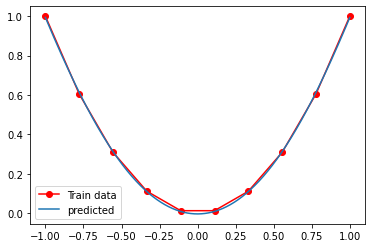

In [128]:
import matplotlib.pyplot as plt
x_pred = jnp.linspace(-1, 1, 10000)
x_pred = x_pred.reshape((10000, num_features))
y_pred = batched_prediction(params, x_pred)
plt.plot(x_train, y_train, "-ro", label="Train data")
plt.plot(x_pred, y_pred, label="predicted")
plt.legend()

In [120]:
x_pred.shape


(10000,)